# <ins>**Notebook 3**</ins>: **Análisis estadístico de base** ***Price Spells***

### **<ins>Propósito</ins>**

Este notebook tiene como objetivo **<ins>analizar las principales características de las variables empleadas en las modelizaciones de Machine Learning desarrolladas.</ins>** Como fue definido en la sección de  `Transformación y limpieza de los datos`, la base de *Price Spells* utilizada está compuesta por intervalos de precios para cada combinación existente de establecimiento-producto, siendo la variación de dichos precios lo que da inicio y fin a cada uno de los intervalos.

**<ins>El análisis exploratorio fue realizado sobre la base de datos utilizada para la modelización tradicional de Machine Learning</ins>**, la cual consiste en todas las combinaciones establecimiento-producto clasificadas como *Completed*, posterior a la depuración realizada por concepto de  *Outliers* y datos censurados.

**<ins>Las variables predictoras utilizadas para la modelización son:</ins>** *Categoría, Promoción, Cadena, Tipo de Establecimiento, Municipio, Mes, Día del Mes, Día de Semana, Var Precio % y Lag Duración1*.

---

### **<ins>Objetivos</ins>**

- **<ins>Analizar el comportamiento de las variables empleadas en el desarrollo de modelos tradicionales de Machine Learning.</ins>** **En especial su vinculación con la variable a predecir *Duración***.
- **<ins>Perfilar las variables que pueden llegar a instrumentarse en las modelizaciones de Machine Learning</ins>**, teniendo en consideración la relación entre estas y *Duración*.
- **<ins>Generar tablas y figuras resumen que se incorporaron en la tésis.</ins>**

---

### **<ins>Archivos necesarios</ins>**

1. **<ins>establecimiento.xlsx</ins>** -> Listado de establecimientos en base
2. **<ins>productos.csv</ins>** -> Listado de productos en base
3. **<ins>productos (Rubros y Categorías).csv<ins>** -> Contiene los Rubros y
Categorias asociados a cada uno de los productos en base
4. **<ins>Feriados.csv<ins>** -> Listado con los días feriados del período analizado
5. **<ins>Grilla de Productos.csv<ins>** -> Listado de productos considerados en el estudio
7. **<ins>df_Price_spells_SML.feather</ins>** -> Base que contiene las series temporales de Price Spells de los pares establecimiento-producto en Montevideo, correspondientes al período enero 2021 - junio 2024. Se utiliza para la modelización Survival Machine Learning.
2. **<ins>df_Price_spells_ML.feather</ins>** -> Base que contiene las series temporales de Price Spells de los pares establecimiento-producto en Montevideo, correspondientes al período enero 2021 - junio 2024. Se utiliza para la modelización tradicional de Machine Learning.

---

### **<ins>Archivos generados</ins>**

**<ins>Gráficas y tablas de:</ins>**

(generados en el entorno de trabajo)

- Estadísticos generales de la variable *Duración* y discriminados por la   variable *Promoción*
- Distribución de la base por *Rubro*; por *Día de la Semana*; por *Incremento* y *Reducción* de *Precio*; por *Cadena*; por *Tipo de Establecimiento*; por *Municipio*.
- Distribución de la *Duración* de los spells (Histograma)
- Evolución general y por rubros de la *Duración* promedio de los spells (Gráfico de líneas)
- Distribución de las duraciones de los spells por *Categoría* (Boxplot)
- Cantidad de spells por *Día del Mes* (Barras)
- Cantidad de spells y *Duración* media por *Mes* (Barras)
- Distribución de spells por *Categoría* (Barras)
- Mapas de calor por Rubros con la relación entre *Duración*, *Categoría* y *Tipo de Establecimiento*
- Relación entre la media de la *Duración* y la media de *Var_Precio_%* por Rubros discriminando entre Incrementos y Reducciones (Puntos)


---


# **0. Librerías**

In [ ]:
## INSTALACIÓN DE BIBLIOTECAS ##

# Instalamos las bibliotecas necesarias
!pip install openpyxl xlrd
!pip install folium

In [ ]:
## CARGA DE LIBRERÍAS ##

import pandas as pd #pandas
import os #os
import matplotlib.pyplot as plt #matplotlib
import matplotlib.colors as mcolors # paleta de colores
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mtick
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FuncFormatter
import seaborn as sns #seaborn
import folium # Mapa Interactivo
import warnings  # warnings
import ipywidgets as widgets #Widgets
from IPython.display import display #Display
from tqdm.notebook import tqdm # Timer
import numpy as np #Numpy
import folium # Folium
from tqdm import tqdm
import scipy.stats as stats
from scipy.stats import skew, kurtosis
from IPython.display import FileLink


In [ ]:
## OTROS ##

# Desactivamos todos los warnings
warnings.filterwarnings('ignore')

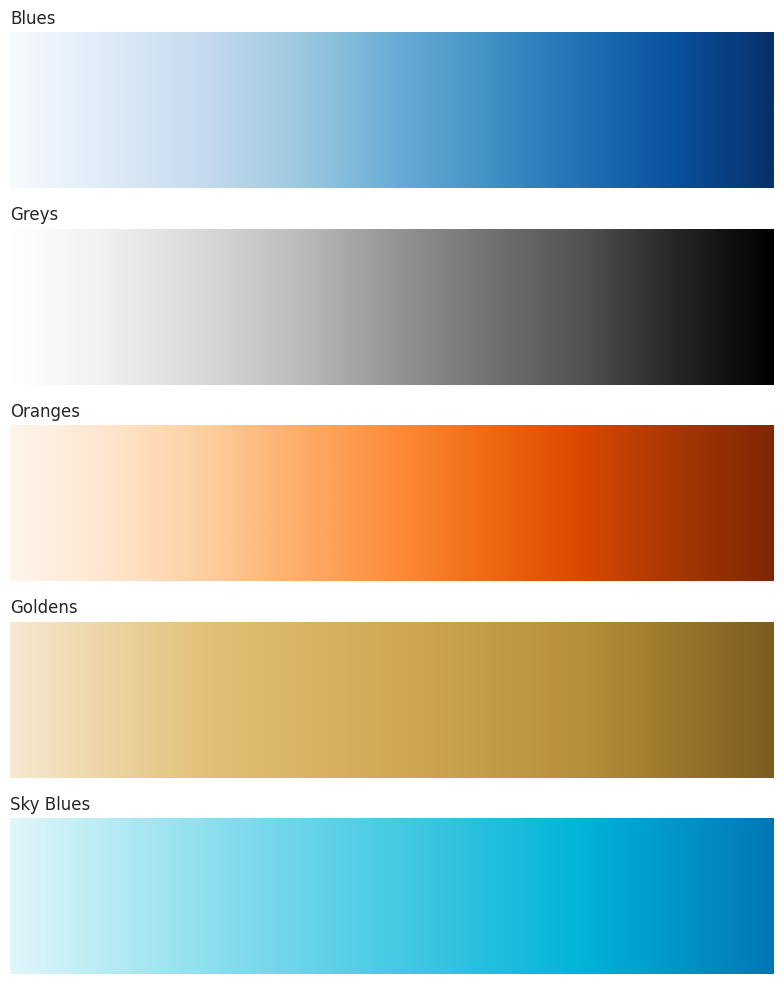

In [ ]:
## DEFINICIÓN DE PALETA DE COLORES A UTILIZAR EN LAS VISUALIZACIONES ##

# Paletas predefinidas en Matplotlib
paletas_predefinidas = ['Blues', 'Greys', 'Oranges']

# Ajustamos los colores para que los inicios sean mucho más claros en las paletas de dorados y celestes
colors_dorados_muy_suave = ["#f8e8d1", "#e2c178", "#d1a956", "#b69038", "#7d5d1f"]
colors_celestes_muy_suave = ["#e0f7fa", "#90e0ef", "#48cae4", "#00b4d8", "#0077b6"]

# Creamos los mapas de colores secuenciales ajustados para ser mucho más claros al inicio
cmap_dorados_muy_suave = LinearSegmentedColormap.from_list("goldens", colors_dorados_muy_suave)
cmap_celestes_muy_suave = LinearSegmentedColormap.from_list("aky_blues", colors_celestes_muy_suave)

# Definimos la nueva paleta de colores ajustada
color_dict = {
    'Alimentos': plt.get_cmap('Blues')(0.8),  # Color medio de la paleta Blues
    'Bebidas con Alcohol': plt.get_cmap('Oranges')(0.5),  # Color medio de la paleta Oranges
    'Bebidas sin Alcohol': cmap_dorados_muy_suave(0.5),  # Color medio de la paleta dorados
    'Cuidado Personal': cmap_celestes_muy_suave(0.5),  # Color medio de la paleta celestes
    'Limpieza': plt.get_cmap('Greys')(0.5),  # Color medio de la paleta Greys
}

# Función para mostrar múltiples paletas
def mostrar_paletas_combinadas(paletas, cmap_gradientes, nombres_gradientes):
    plt.figure(figsize=(8, 10))

    # Mostramos paletas predefinidas
    for i, paleta in enumerate(paletas):
        plt.subplot(len(paletas) + len(cmap_gradientes), 1, i + 1)
        plt.imshow([np.linspace(0, 1, 256)], aspect='auto', cmap=plt.get_cmap(paleta))
        plt.title(paleta, loc='left')
        plt.axis('off')

    # Mostramos gradientes personalizados (dorados y celestes)
    for i, (cmap, nombre) in enumerate(zip(cmap_gradientes, nombres_gradientes)):
        plt.subplot(len(paletas) + len(cmap_gradientes), 1, len(paletas) + i + 1)
        plt.imshow([np.linspace(0, 1, 256)], aspect='auto', cmap=cmap)
        plt.title(nombre, loc='left')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualizamos todas las paletas juntas
mostrar_paletas_combinadas(paletas_predefinidas, [cmap_dorados_muy_suave, cmap_celestes_muy_suave], ['Goldens', 'Sky Blues'])


# **1. Carga de <ins>referencias y bases de *Price Spells*</ins>** *(2021-1er Semestre 2024)*

## **1.1  <ins>Referencias</ins>**: *Establecimientos, Productos y Otros*

In [ ]:
## CARGA DE BASES DE REFERENCIAS ##

# Cargamos bases: 'productos', 'establecimientos', 'productos (Rubros y Categorías)', 'Feriados' y 'Grilla de Productos'

try:
    # Especificar un delimitador diferente si sospechas que no es una coma
    productos = pd.read_csv('productos.csv', encoding='latin1', delimiter=';')
    establecimientos = pd.read_excel('establecimientos.xlsx')
    productos_categorias_rubros = pd.read_csv('productos (Rubros y Categorías).csv', encoding='latin1', delimiter=';')
    feriados = pd.read_csv('Feriados.csv', encoding='latin1', delimiter=';')
    feriados['Fecha Celebrado'] = pd.to_datetime(feriados['Fecha Celebrado'], format='%d/%m/%Y', errors='coerce')
    productos_seleccionados = pd.read_csv('Grilla de Productos.csv', encoding='latin1', delimiter=';')
except pd.errors.ParserError as e:
    print("Error de parseo: ", e)

# Aseguramos que los nombres de las columnas coinciden
if 'id.producto' in productos.columns and 'id.producto' in productos_categorias_rubros.columns:
    # Hacemos merge entre productos y productos_categorias_rubros a través de id.producto
    productos = pd.merge(productos, productos_categorias_rubros, on='id.producto', how='left')

    # Reordenamos las columnas
    productos = productos[['id.producto', 'rubro', 'categoria', 'producto', 'marca', 'especificacion', 'nombre']]

    # Renombramos columnas
    productos = productos.rename(columns={'rubro': 'Rubro', 'categoria': 'Categoria'})

productos.head(5)


   id.producto      Rubro Categoria           producto            marca  \
0            1  Alimentos   Aceites  Aceite de girasol           Óptimo   
1            2  Alimentos   Aceites  Aceite de girasol  Río de la Plata   
2            3  Alimentos   Aceites  Aceite de girasol          Uruguay   
3            4  Alimentos   Aceites     Aceite de maíz          Delicia   
4            5  Alimentos   Aceites     Aceite de maíz  Río de la Plata   

  especificacion                                           nombre  
0  Envase 900 cc           Aceite de girasol Óptimo Envase 900 cc  
1  Envase 900 cc  Aceite de girasol Río de la Plata Envase 900 cc  
2  Envase 900 cc          Aceite de girasol Uruguay Envase 900 cc  
3  Envase 900 cc             Aceite de maíz Delicia Envase 900 cc  
4  Envase 900 cc     Aceite de maíz Río de la Plata Envase 900 cc  


In [ ]:
## AJUSTE DE VARIABLES PARA LOS DATAFRAMES DE PRODUCTOS Y ESTABLECIMIENTOS ##

# Función para convertir valores con comas y/o múltiples puntos a float
def convertir_a_float_mejorado(valor):
    if isinstance(valor, str):  # Si el valor es una cadena
        valor = valor.replace(',', '.')  # Elimina todas las comas
        # Si hay más de un punto, reconstruir el número manteniendo solo el primer punto
        partes = valor.split('.')
        if len(partes) > 2:
            valor = partes[0] + '.' + ''.join(partes[1:])
    try:
        return float(valor)
    except ValueError:
        return None  # Retorna None si no se puede convertir a float

# Transformación y clasificación de productos
productos.rename(columns={
    'id.producto': 'ID_producto',
    'producto': 'Producto',
    'marca': 'Marca',
    'especificacion': 'Especificación',
    'nombre': 'Nombre'
}, inplace=True)
for col in ['ID_producto', 'Producto', 'Marca', 'Especificación', 'Nombre']:
    productos[col] = productos[col].astype('category')

# Transformación y clasificación de establecimientos
establecimientos.rename(columns={
    'id.establecimientos': 'ID_establecimiento',
    'razon.social': 'Razon_social',
    'nombre.sucursal': 'Nombre_sucursal',
    'direccion': 'Dirección',
    'ccz': 'CCZ',
    'barrio': 'Barrio',
    'cajas': 'Cajas',
    'cadena': 'Cadena_old',
    'long': 'Long',
    'lat': 'Lat',
    'ciudad': 'Ciudad',
    'depto': 'Departamento',
    'id.depto': 'ID_departamento',
    'localidad': 'Localidad',
    'superficie (m2)': 'Superficie (m2)',
    'Cadena (Nuevo Criterio)': 'Cadena',
    'Tipo Establecimiento': 'Tipo_establecimiento'
}, inplace=True)
category_cols = ['ID_establecimiento', 'Razon_social', 'Nombre_sucursal', 'Dirección', 'CCZ', 'Barrio', 'Cadena_old', 'Ciudad', 'Departamento', 'ID_departamento', 'Localidad', 'Cadena', 'Tipo_establecimiento']
for col in category_cols:
    establecimientos[col] = establecimientos[col].astype('category')

# Convertimos cajas a int, y longitudes y latitudes después de correcciones de formato
establecimientos['Cajas'] = establecimientos['Cajas'].astype(int)
establecimientos['Long'] = establecimientos['Long'].apply(convertir_a_float_mejorado)
establecimientos['Lat'] = establecimientos['Lat'].apply(convertir_a_float_mejorado)
establecimientos['Superficie (m2)'] = establecimientos['Superficie (m2)'].astype(str).str.replace(',', '.').astype(float)

In [ ]:
establecimientos.info() # Composición base de 'establecimientos'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   ID_establecimiento    768 non-null    category
 1   Razon_social          768 non-null    category
 2   Nombre_sucursal       768 non-null    category
 3   Dirección             767 non-null    category
 4   CCZ                   209 non-null    category
 5   Barrio                768 non-null    category
 6   Cajas                 768 non-null    int64   
 7   Cadena_old            768 non-null    category
 8   Long                  765 non-null    float64 
 9   Lat                   765 non-null    float64 
 10  Ciudad                768 non-null    category
 11  Departamento          768 non-null    category
 12  ID_departamento       768 non-null    category
 13  Localidad             768 non-null    category
 14  Superficie (m2)       448 non-null    float64 
 15  Cadena

In [ ]:
productos.info() # Composición base de 'productos'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ID_producto     368 non-null    category
 1   Rubro           368 non-null    object  
 2   Categoria       368 non-null    object  
 3   Producto        368 non-null    category
 4   Marca           294 non-null    category
 5   Especificación  357 non-null    category
 6   Nombre          368 non-null    category
dtypes: category(5), object(2)
memory usage: 47.0+ KB


In [ ]:
productos_categorias_rubros.info() # Composición base 'productos (Rubros y Categorías)'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id.producto  368 non-null    int64 
 1   rubro        368 non-null    object
 2   categoria    368 non-null    object
dtypes: int64(1), object(2)
memory usage: 8.8+ KB


In [ ]:
feriados.info() # Composición base 'Feriados'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Fecha Feriado    56 non-null     object        
 1   Feriado          56 non-null     object        
 2   Laborable        56 non-null     object        
 3   Se corrió        56 non-null     object        
 4   Fecha Celebrado  56 non-null     datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 2.3+ KB


In [ ]:
productos_seleccionados.info() # Composición base 'Grilla de Productos'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID Producto  161 non-null    int64 
 1   Productos    161 non-null    object
 2   Rubro        161 non-null    object
 3   Categoría    161 non-null    object
dtypes: int64(1), object(3)
memory usage: 5.2+ KB


In [ ]:
## DICCIONARIO DE MUNICIPIOS POR BARRIO ##

municipios_montevideo = {
    'Municipio A': [
        'La Teja', 'Cerro', 'Paso de la Arena', 'Nuevo París', 'Casabó'
    ],
    'Municipio B': [
        'Cordón', 'Aguada', 'Palermo', 'Barrio Sur', 'Centro', 'Tres Cruces',
        'Ciudad Vieja', 'Parque Rodó', 'La Comercial'
    ],
    'Municipio C': [
        'Reducto', 'Belvedere', 'Paso Molino', 'Prado', 'Bella Vista',
        'Atahualpa', 'Aires Puros', 'Capurro', 'Goes'
    ],
    'Municipio CH': [
        'Pocitos', 'Parque Batlle', 'Punta Carretas', 'Buceo',
        'Parque Batlle y Villa Dolores'
    ],
    'Municipio D': [
        'La Blanqueada', 'Brazo Oriental', 'Pérez Castellanos',
        'Casavalle', 'Larrañaga', 'Mercado Modelo'
    ],
    'Municipio E': [
        'Malvín', 'Punta Gorda', 'Carrasco', 'Carrasco Norte',
        'Portones'
    ],
    'Municipio F': [
        'Unión', 'Cerrito', 'Malvín Norte', 'Maroñas', 'Punta de Rieles',
        'Piedras Blancas', 'Toledo Chico', 'Ituzaingó', 'Lavalleja',
        'Manga', 'Villa García', 'Jardines del Hipódromo'
    ],
    'Municipio G': [
        'Colón', 'Sayago', 'Colón Centro y Noroeste', 'Peñarol', 'Lezica'
    ]
}

## **1.2  Carga de <ins>bases de Price Spells</ins>**
(Obtenidas en Notebook 2)

In [ ]:
## BASE PRICE SPELLS SURVIVAL MACHINE LEARNING ##

# Cargamos base desde un archivo .feather
df_price_spell_SML = pd.read_feather('df_Price_spells_SML.feather')

df_price_spell_SML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352274 entries, 0 to 352273
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   ID_establecimiento     352274 non-null  int64         
 1   Nombre_sucursal        352274 non-null  object        
 2   Cadena                 352274 non-null  object        
 3   Tipo_establecimiento   352274 non-null  object        
 4   Barrio                 352274 non-null  object        
 5   Municipio              352274 non-null  object        
 6   ID_producto            352274 non-null  int64         
 7   Nombre                 352274 non-null  object        
 8   Rubro                  352274 non-null  object        
 9   Categoria              352274 non-null  object        
 10  Intervalo              352274 non-null  int64         
 11  Fecha_inicio           352274 non-null  datetime64[ns]
 12  Fecha_fin              352274 non-null  date

In [ ]:
## BASE PRICE SPELLS MODELOS TRADICIONALES DE MACHINE LEARNING ##

# Cargamos base desde un archivo .feather
df_price_spell_ML = pd.read_feather('df_Price_spells_ML.feather')

df_price_spell_ML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301026 entries, 0 to 301025
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   ID_establecimiento     301026 non-null  int64         
 1   Nombre_sucursal        301026 non-null  object        
 2   Cadena                 301026 non-null  object        
 3   Tipo_establecimiento   301026 non-null  object        
 4   Barrio                 301026 non-null  object        
 5   Municipio              301026 non-null  object        
 6   ID_producto            301026 non-null  int64         
 7   Nombre                 301026 non-null  object        
 8   Rubro                  301026 non-null  object        
 9   Categoria              301026 non-null  object        
 10  Intervalo              301026 non-null  int64         
 11  Fecha_inicio           301026 non-null  datetime64[ns]
 12  Fecha_fin              301026 non-null  date

# **2 <ins>Análisis estadístico</ins>** ***Modelos Tradicionales de Machine Learning***

#### **2.1**  **Frecuencialidad por <ins>PRODUCTO</ins>**


In [ ]:

# 1. Agrupamos el DataFrame por 'Nombre' (producto) y calculamos Establecimientos, Spells y Duración_Media
resumen_productos = df_price_spell_ML.groupby(['Nombre']).agg(
    Establecimientos=('ID_establecimiento', 'nunique'),
    Spells=('Intervalo', 'count'),  # Cuenta la cantidad de observaciones del campo Intervalo
    Duración_Media=('Duración', 'mean')  # Calcula la media de la duración
).reset_index()

# 2. Filtramos productos con al menos un establecimiento
resumen_productos = resumen_productos[resumen_productos['Establecimientos'] > 0]

# 3. Calculamos el porcentaje de establecimientos
num_establecimientos = df_price_spell_ML['ID_establecimiento'].nunique()  # Total de establecimientos
resumen_productos['%_establecimientos'] = (resumen_productos['Establecimientos'] / num_establecimientos * 100).round(2)

# 4. Calculamos %_Spells sobre el total
total_observaciones = len(df_price_spell_ML)  # Total de observaciones (Spells)
resumen_productos['%_Spells'] = (resumen_productos['Spells'] / total_observaciones * 100).round(2)

# 5. Redondeamos Duración_Media a 2 decimales
resumen_productos['Duración_Media'] = resumen_productos['Duración_Media'].round(2)

# 6. Unimos con el DataFrame productos utilizando una unión interna (inner)
resumen_productos = pd.merge(
    resumen_productos,
    productos[['Nombre', 'Categoria', 'Rubro']].drop_duplicates(),
    on='Nombre',
    how='inner'
)

# 7. Reordenamos las columnas
resumen_productos = resumen_productos[['Nombre', 'Categoria', 'Rubro', 'Establecimientos', '%_establecimientos', 'Spells', '%_Spells', 'Duración_Media']]

# 8. Ordenamos la tabla por 'Spells' en orden decreciente
resumen_productos = resumen_productos.sort_values(by='Spells', ascending=False)

# 9. Visualizamos los 30 Productos con menor cantidad de Spells
resumen_productos.tail(30)


Nombre          Categoria  \
142         Té negro en saquitos President Caja 10 us.       Estimulantes   
61   Gaseosa tipo cola (env. no ret.) Coca Cola_ Bo...           Gaseosas   
92                         Júpiter Crema,  80.0 gramos         Protección   
131   Sal fina yodada fluorada Urusal Paquete 500 grs.                Sal   
91                           Júpiter Aerosol,  165 cm3         Protección   
80            Jabón de Glicerina Ann Bow, 140.0 gramos   Higiene Personal   
89      Jabón para ropa en barra Nevex Unidad 200 grs.      Jabón de Ropa   
147          Yerba mate común Del Cebador Paquete1 kg.       Estimulantes   
127             Queso rallado Artesano Paquete 80 grs.            Lacteos   
9           Agua de mesa con gas Matutina Envase 2 lt.              Aguas   
103                       Off! Family Aerosol,  144cm3         Protección   
123            Protector solar SPF 60 Soundown 120 ml.         Protección   
148                          Yogur Calcar Sachet 1 lt.            Lacteos   
79      Huevos colorados Super huevo Envase 1/2 docena             Huevos   
59                           Gasa estéril 40 unidades   Primeros Auxilios   
26   Café envasado (no instantáneo) Saint Paquete 2...       Estimulantes   
71        Harina trigo común 0000 Primor Paquete 1 kg.            Harinas   
55   Fideos secos semolados Las Acacias - franja ce...             Fideos   
86       Jabón en polvo máquina Drive Paquete 800 grs.      Jabón de Ropa   
120    Protector solar SPF 30 Hawaiian Tropic 180 ml.          Protección   
84          Jabón de tocador Palmolive Unidad 125 grs.   Higiene Personal   
85             Jabón de tocador Rexona Unidad 125 grs.   Higiene Personal   
64   Hamburguesas carne vacun Burgy Paquete 3 unidades             Carnes   
141       Té negro en saquitos La Virginia Caja 10 us.       Estimulantes   
133            Talco Xanapie Aerosol, 175.0 mililitros   Higiene Personal   
14               Alcohol en gel Bioset 250 mililitros   Primeros Auxilios   
87   Jabón en polvo máquina Skip - Paquete azul Paq...      Jabón de Ropa   
36                         Champú Sedal Envase 350 ml.   Higiene Personal   
97             Margarina Doriana nueva Envase 250 grs.            Lacteos   
100      Mermelada de durazno El Hogar Envase 500 grs.             Dulces   

                   Rubro  Establecimientos  %_establecimientos  Spells  \
142  Bebidas sin Alcohol               102               35.29     535   
61   Bebidas sin Alcohol                49               16.96     522   
92      Cuidado Personal                82               28.37     515   
131            Alimentos               118               40.83     503   
91      Cuidado Personal                87               30.10     480   
80      Cuidado Personal                55               19.03     460   
89              Limpieza                46               15.92     453   
147  Bebidas sin Alcohol               119               41.18     440   
127            Alimentos                58               20.07     438   
9    Bebidas sin Alcohol                43               14.88     407   
103     Cuidado Personal                46               15.92     383   
123     Cuidado Personal                84               29.07     376   
148            Alimentos                33               11.42     354   
79             Alimentos                38               13.15     354   
59      Cuidado Personal                70               24.22     354   
26   Bebidas sin Alcohol                32               11.07     345   
71             Alimentos                41               14.19     315   
55             Alimentos                31               10.73     307   
86              Limpieza                36               12.46     288   
120     Cuidado Personal                70               24.22     284   
84      Cuidado Personal                40               13.84     284   
85      Cuidado Personal        

In [ ]:
# Visualizamos los 30 Productos con más Spells
resumen_productos.head(30)

Nombre             Categoria  \
114     Pañales Adultos Readysec Grande, 24.0 unidades      Higiene Personal   
139                  Tomate Americano,  1.0 kilogramos                Frutas   
93                         Lechuga Crespa,  1.0 unidad              Verduras   
102           Nalga vacuna Sin Hueso - Sin Marca 1 kg.                Carnes   
13            Aguja vacuna Sin Hueso - Sin Marca 1 kg.                Carnes   
106          Paleta vacuna Sin Hueso - Sin Marca 1 kg.            Chacinados   
116                      Peceto vacuno Sin Marca 1 kg.                Carnes   
109                        Papa Rosada, 1.0 kilogramos              Verduras   
98             Mayonesa común Hellmans Envase 500 grs.  Condimentos y Salsas   
118  Pollo entero fresco con menudos Avícola del Oe...                Carnes   
37   Chorizos mezcla sueltos - Cattivelli  - Extra ...            Chacinados   
149            Yogur Conaprole BIO TOP Sachet1,200 lt.               Lacteos   
62   Gaseosa tipo cola (env. no ret.) Pepsi Botella...              Gaseosas   
136   Tinta Garnier Nutrisse Intense N.8.0, 1.0 unidad              Estética   
83       Jabón de tocador Astral plata Unidad 125 grs.      Higiene Personal   
90           Jamón cocido no artesanal Ottonello 1 kg.            Chacinados   
38   Chorizos mezcla sueltos - Centenario - Extra 1...            Chacinados   
144  Vino tinto común tetrabrick Santa Teresa Clási...                 Vinos   
32                     Cerveza Zillertal Botella 1 lt.              Cervezas   
31                      Cerveza Pilsen Botella 960 ml.              Cervezas   
44   Desodorante en aerosol Dove Original Envase 10...      Higiene Personal   
19               Arroz blanco Saman Blanco Bolsa 1 kg.                 Arroz   
95           Manteca Conaprole sin sal Envase 200 grs.               Lacteos   
115  Pañales Babysec Premium Extra Extra Grande, 48...      Higiene Personal   
69      Harina trigo común 0000 Cañuelas Paquete 1 kg.               Harinas   
18                 Arroz blanco Green Chef Bolsa 1 kg.                 Arroz   
63   Gaseosa tipo cola (env. no ret.) Pepsi Botella...              Gaseosas   
25   Café envasado (no instantáneo) Chaná Paquete 2...          Estimulantes   
29     Carne picada vacuna Con Hasta 5% de grasa 1 kg.                Carnes   
30                    Cerveza Patricia Botella 960 ml.              Cervezas   

                   Rubro  Establecimientos  %_establecimientos  Spells  \
114     Cuidado Personal               107               37.02   28539   
139            Alimentos                77               26.64   13651   
93             Alimentos                74               25.61   11035   
102            Alimentos                78               26.99   11010   
13             Alimentos                80               27.68    8619   
106            Alimentos                86               29.76    7798   
116            Alimentos                81               28.03    7116   
109            Alimentos                81               28.03    5161   
98             Alimentos               112               38.75    4961   
118            Alimentos                82               28.37    4915   
37             Alimentos                80               27.68    4538   
149            Alimentos               119               41.18    4183   
62   Bebidas sin Alcohol               139               48.10    4102   
136     Cuidado Personal               213               73.70    4017   
83      Cuidado Personal               255               88.24    3983   
90             Alimentos                73               25.26    3729   
38             Alimentos                71               24.57    3725   
144  Bebidas con Alcohol               142               49.13    3513   
32   Bebidas con Alcohol               116               40.14    3407   
31   Bebidas con Alcohol               110               38.06    3226   
44      Cuida

#### **2.2**  **Frecuencialidad por <ins>CATEGORÍA</ins>**


In [ ]:
# 1. Agrupamos el DataFrame por 'Categoria' y calculamos la cantidad de establecimientos, productos, Spells y la media de Duración
resumen_categorias = df_price_spell_ML.groupby(['Categoria']).agg(
    Establecimientos=('ID_establecimiento', 'nunique'),
    Productos=('ID_producto', 'nunique'),
    Spells=('Intervalo', 'count'),  # Cuenta la cantidad de observaciones del campo Intervalo
    Duración_Media=('Duración', 'mean')  # Calcula la media de la duración para cada categoría
).reset_index()

# 2. Redondeamos la columna 'Duración_Media' a 2 decimales
resumen_categorias['Duración_Media'] = resumen_categorias['Duración_Media'].round(2)

# 3. Calculamos el porcentaje de establecimientos, productos y Spells
num_establecimientos = df_price_spell_ML['ID_establecimiento'].nunique()  # Total de establecimientos
num_productos = df_price_spell_ML['ID_producto'].nunique()  # Total de productos
total_observaciones = len(df_price_spell_ML)  # Total de observaciones (Spells)

resumen_categorias['%_establecimientos'] = (resumen_categorias['Establecimientos'] / num_establecimientos * 100).round(2)
resumen_categorias['%_productos'] = (resumen_categorias['Productos'] / num_productos * 100).round(2)
resumen_categorias['%_Spells'] = (resumen_categorias['Spells'] / total_observaciones * 100).round(2)  # Calcula el %_Spells

# 4. Unimos con el DataFrame de productos para obtener el 'Rubro' correspondiente
resumen_categorias = pd.merge(resumen_categorias, productos[['Categoria', 'Rubro']].drop_duplicates(), on='Categoria', how='left')

# 5. Reordenamos las columnas
resumen_categorias = resumen_categorias[['Categoria', 'Rubro', 'Establecimientos', '%_establecimientos', 'Productos', '%_productos', 'Spells', '%_Spells', 'Duración_Media']]

# 6. Ordenamos el DataFrame por 'Spells' en forma decreciente
resumen_categorias = resumen_categorias.sort_values(by='Spells', ascending=False)

# 7. Calculamos la media total de la columna 'Duración'
media_duracion_total = df_price_spell_ML['Duración'].mean().round(2)

# 8. Creamos una fila de totales
fila_total = pd.DataFrame({
    'Categoria': ['Total'],
    'Rubro': ['-'],
    'Establecimientos': [num_establecimientos],  # Total de establecimientos únicos
    '%_establecimientos': [100],
    'Productos': [num_productos],  # Total de productos únicos
    '%_productos': [100],
    'Spells': [total_observaciones],  # Sumatoria de Spells
    '%_Spells': [100],
    'Duración_Media': [media_duracion_total]  # Media total de la duración redondeada a 2 decimales
})

# 9. Añadimos la fila total al final del DataFrame
resumen_categorias = pd.concat([resumen_categorias, fila_total], ignore_index=True)

# 10. Visualizamos el DataFrame final con la fila de Total al final
resumen_categorias


Categoria                Rubro  Establecimientos  \
0       Higiene Personal     Cuidado Personal               259   
1                 Carnes            Alimentos               154   
2             Chacinados            Alimentos               150   
3               Verduras            Alimentos                82   
4                 Frutas            Alimentos                77   
5                Lacteos            Alimentos               156   
6   Condimentos y Salsas            Alimentos               155   
7                  Arroz            Alimentos               155   
8           Estimulantes  Bebidas sin Alcohol               240   
9               Gaseosas  Bebidas sin Alcohol               216   
10              Cervezas  Bebidas con Alcohol               116   
11               Harinas            Alimentos               155   
12                Fideos            Alimentos               158   
13               Aceites            Alimentos               171   
14              Estética     Cuidado Personal               213   
15                Dulces            Alimentos               155   
16     Limpieza de Hogar             Limpieza               215   
17            Protección     Cuidado Personal               169   
18                 Vinos  Bebidas con Alcohol               148   
19                 Aguas  Bebidas sin Alcohol               188   
20               Postres            Alimentos                74   
21                Huevos            Alimentos               105   
22                Azúcar            Alimentos               125   
23         Jabón de Ropa             Limpieza               125   
24     Primeros Auxilios     Cuidado Personal               180   
25           Panificados            Alimentos               154   
26             Enlatados            Alimentos                82   
27                   Sal            Alimentos               147   
28                 Total                    -               289   

    %_establecimientos  Productos  %_productos  Spells  %_Spells  \
0                89.62         26        17.33   62213     20.67   
1                53.29         10         6.67   41918     13.93   
2                51.90          9         6.00   27427      9.11   
3                28.37          3         2.00   18634      6.19   
4                26.64          1         0.67   13651      4.53   
5                53.98          8         5.33   11498      3.82   
6                53.63          5         3.33   11129      3.70   
7                53.63          5         3.33   10030      3.33   
8                83.04         11         7.33    9859      3.28   
9                74.74          4         2.67    9404      3.12   
10               40.14          3         2.00    9296      3.09   
11               53.63          6         4.00    8971      2.98   
12               54.67          4         2.67    7648      2.54   
13               59.17          7         4.67    7177      2.38   
14               73.70          3         2.00    7061      2.35   
15               53.63          6         4.00    6550      2.18   
16               74.39          5         3.33    6416      2.13   
17               58.48          9         6.00    5904      1.96   
18               51.21          2         1.33    4828      1.60   
19               65.05          3         2.00    3939      1.31   
20               25.61          2         1.33    2532      0.84   
21               36.33          3         2.00    2521      0.84   
22               43.25          2         1.33    2503      0.83   
23               43.25          4         2.67    2459      0.82   
24               62.28          4         2.67    2451      0.81   
25               53.29          2         1.33    2093      0.70   
26               28.37          1         0.67    1695      0.56   
27               50.87          2         1.33    1219      0.40   
28              100.00        15

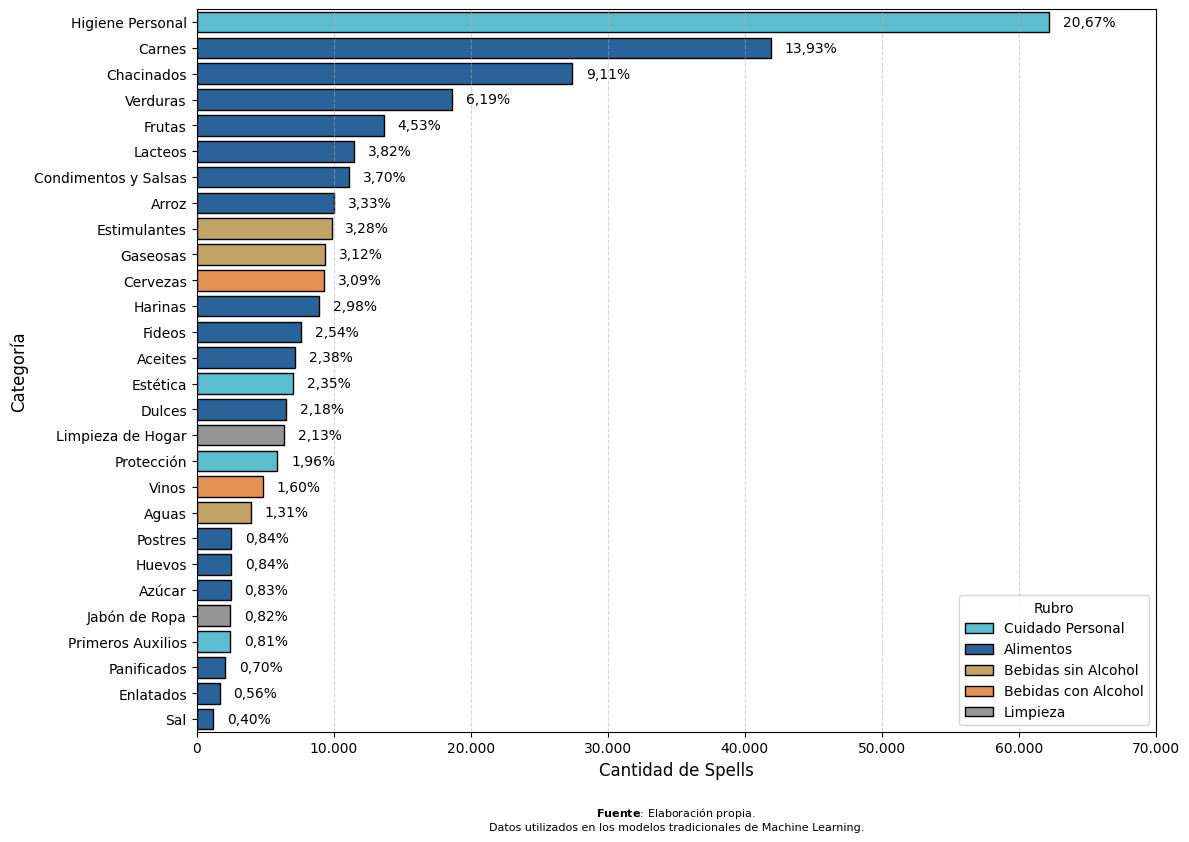

/content/Cantidad_spells_por_Categoria.png

In [ ]:
## CANTIDAD DE SPELLS POR CATEGORIA ##

# Filtramos el DataFrame para excluir la fila "Total"
resumen_categorias_sin_total = resumen_categorias[resumen_categorias['Categoria'] != 'Total']

# Ordenamos el DataFrame de mayor a menor cantidad de spells
resumen_categorias_sin_total = resumen_categorias_sin_total.sort_values(by='Spells', ascending=False)

# Creamos la figura
plt.figure(figsize=(12, 8))

# Gráfico de barras
ax = sns.barplot(
    data=resumen_categorias_sin_total,
    x='Spells',
    y='Categoria',
    hue='Rubro',
    palette=color_dict,
    dodge=False,
    edgecolor='black'
)

# Colocamos cuadrícula detrás de las barras
ax.grid(True, axis='x', linestyle='--', alpha=0.5, zorder=0)
for patch in ax.patches:
    patch.set_zorder(1)

# Formato del eje X: punto como separador de miles
ax.get_xaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, _: '{:,.0f}'.format(x).replace(",", "."))
)

# Establecemos límite del eje X hasta 70.000
ax.set_xlim(0, 70000)

# Agregamos porcentaje sobre cada barra
for i, row in resumen_categorias_sin_total.iterrows():
    ax.text(
        row['Spells'] + 1000,  # Posición X, un poco más allá del final de la barra
        i,  # Posición Y
        f"{row['%_Spells']:.2f}".replace('.', ',') + '%',
        va='center',
        ha='left',
        fontsize=10
    )

# Etiquetas
plt.xlabel('Cantidad de Spells', fontsize=12)
plt.ylabel('Categoría', fontsize=12)
plt.legend(title='Rubro')
plt.tight_layout()

# Agregamos leyenda/disclaimer
plt.text(0.5, -0.12,
         r'$\bf{Fuente}$: Elaboración propia.' + '\nDatos utilizados en los modelos tradicionales de Machine Learning.',
         ha='center', va='center', transform=plt.gca().transAxes, fontsize=8)

# Guardamos la imagen localmente en el directorio actual
filename = "Cantidad_spells_por_Categoria.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')

# Mostramos
plt.show()

# Creamos un enlace de descarga (queda guardado en entorno)
display(FileLink(filename))

In [ ]:
## Visualización ordenadada por 'Duración_Media' en forma descendente ##

# 1. Excluimos la fila de 'Total' antes de ordenar
resumen_sin_total = resumen_categorias[resumen_categorias['Categoria'] != 'Total']

# 2. Ordenamos el DataFrame por 'Duración_Media' en forma descendente
resumen_categorias_duracion = resumen_sin_total.sort_values(by='Duración_Media', ascending=False)

# 3. Obtenemos la fila de 'Total' para añadirla al final
fila_total = resumen_categorias[resumen_categorias['Categoria'] == 'Total']

# 4. Concatenamos la fila de 'Total' al final del DataFrame ordenado
resumen_categorias_duracion = pd.concat([resumen_categorias_duracion, fila_total], ignore_index=True)

# Visualizamos el DataFrame ordenado por 'Duración_Media' con la fila de Total al final
resumen_categorias_duracion

Categoria                Rubro  Establecimientos  \
0      Primeros Auxilios     Cuidado Personal               180   
1                    Sal            Alimentos               147   
2             Protección     Cuidado Personal               169   
3                 Azúcar            Alimentos               125   
4            Panificados            Alimentos               154   
5           Estimulantes  Bebidas sin Alcohol               240   
6                  Aguas  Bebidas sin Alcohol               188   
7          Jabón de Ropa             Limpieza               125   
8      Limpieza de Hogar             Limpieza               215   
9                 Huevos            Alimentos               105   
10              Estética     Cuidado Personal               213   
11                Dulces            Alimentos               155   
12               Lacteos            Alimentos               156   
13             Enlatados            Alimentos                82   
14              Gaseosas  Bebidas sin Alcohol               216   
15               Aceites            Alimentos               171   
16                 Arroz            Alimentos               155   
17                 Vinos  Bebidas con Alcohol               148   
18  Condimentos y Salsas            Alimentos               155   
19               Harinas            Alimentos               155   
20      Higiene Personal     Cuidado Personal               259   
21               Postres            Alimentos                74   
22                Fideos            Alimentos               158   
23              Cervezas  Bebidas con Alcohol               116   
24            Chacinados            Alimentos               150   
25                Carnes            Alimentos               154   
26              Verduras            Alimentos                82   
27                Frutas            Alimentos                77   
28                 Total                    -               289   

    %_establecimientos  Productos  %_productos  Spells  %_Spells  \
0                62.28          4         2.67    2451      0.81   
1                50.87          2         1.33    1219      0.40   
2                58.48          9         6.00    5904      1.96   
3                43.25          2         1.33    2503      0.83   
4                53.29          2         1.33    2093      0.70   
5                83.04         11         7.33    9859      3.28   
6                65.05          3         2.00    3939      1.31   
7                43.25          4         2.67    2459      0.82   
8                74.39          5         3.33    6416      2.13   
9                36.33          3         2.00    2521      0.84   
10               73.70          3         2.00    7061      2.35   
11               53.63          6         4.00    6550      2.18   
12               53.98          8         5.33   11498      3.82   
13               28.37          1         0.67    1695      0.56   
14               74.74          4         2.67    9404      3.12   
15               59.17          7         4.67    7177      2.38   
16               53.63          5         3.33   10030      3.33   
17               51.21          2         1.33    4828      1.60   
18               53.63          5         3.33   11129      3.70   
19               53.63          6         4.00    8971      2.98   
20               89.62         26        17.33   62213     20.67   
21               25.61          2         1.33    2532      0.84   
22               54.67          4         2.67    7648      2.54   
23               40.14          3         2.00    9296      3.09   
24               51.90          9         6.00   27427      9.11   
25               53.29         10         6.67   41918     13.93   
26               28.37          3         2.00   18634      6.19   
27               26.64          1         0.67   13651      4.53   
28              100.00        15

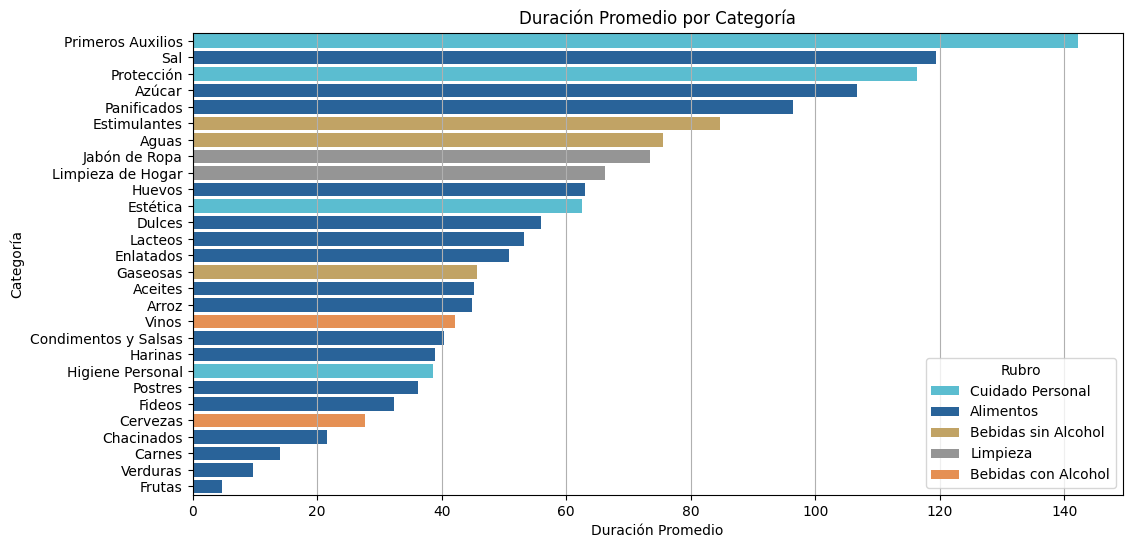

In [ ]:
## GRÁFICO DE DURACIÓN MEDIA POR CATEGORÍA ##

# Calculamos la duración promedio por categoría y rubro
duracion_promedio_categoria = df_price_spell_ML.groupby(['Categoria', 'Rubro'])['Duración'].mean().reset_index()

# Asignamos colores a cada rubro
duracion_promedio_categoria['Color'] = duracion_promedio_categoria['Rubro'].map(color_dict)

# Ordenamos el DataFrame por duración promedio en orden decreciente
duracion_promedio_categoria = duracion_promedio_categoria.sort_values(by='Duración', ascending=False)

# Gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(data=duracion_promedio_categoria, x='Duración', y='Categoria',
            hue='Rubro', dodge=False, palette=color_dict)  # Se establece hue para colorear por rubro

plt.title('Duración Promedio por Categoría')
plt.xlabel('Duración Promedio')
plt.ylabel('Categoría')
plt.grid(axis='x')
plt.legend(title='Rubro')
plt.show()


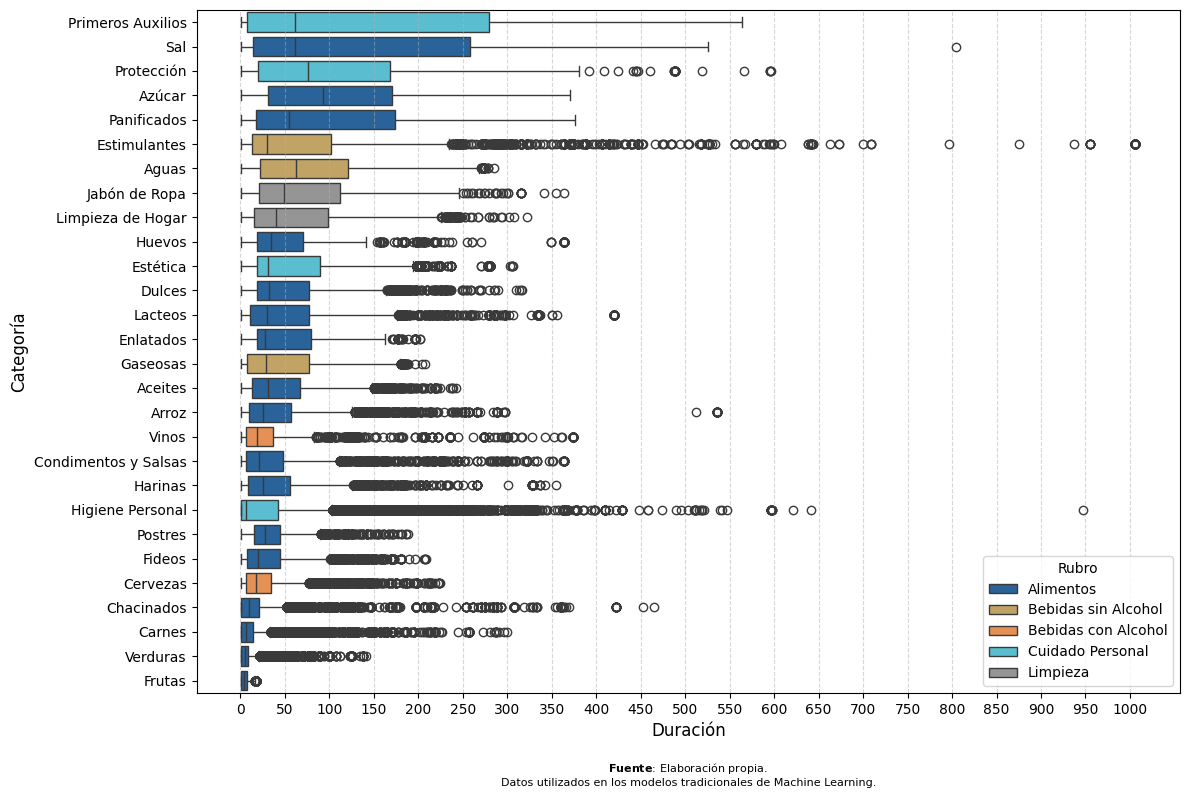

/content/Boxplot_Duracion_por_Categoria.png

In [ ]:
## BOXPLOT POR CATEGORÍA (ordenado por la media de la Duración en forma descendente) ##

# Ordenamos las categorías según la media de 'Duración' en forma descendente
ordered_categories = df_price_spell_ML.groupby('Categoria')['Duración'].mean().sort_values(ascending=False).index

plt.figure(figsize=(12, 8))

# Creamos el boxplot
ax = sns.boxplot(x='Duración', y='Categoria', data=df_price_spell_ML, hue='Rubro', palette=color_dict,
                 order=ordered_categories)  # Usamos la lista ordenada de categorías

# Ajustamos el zorder de las barras y la cuadrícula
ax.grid(True, axis='x', linestyle='--', alpha=0.5, zorder=0)  # Cuadrícula detrás de las barras
for patch in ax.patches:
    patch.set_zorder(1)  # Coloca las barras por encima de la cuadrícula

# Etiquetas de los ejes
plt.xlabel('Duración', fontsize=12)
plt.ylabel('Categoría', fontsize=12)

# Leyenda dentro del gráfico (en el vértice inferior derecho)
plt.legend(title='Rubro', bbox_to_anchor=(1, 0), loc='lower right', fontsize=10)

# Ajustamos los ticks en el eje X
max_value = df_price_spell_ML['Duración'].max()
ticks_50 = np.arange(0, max_value + 1, 50)  # Intervalos de 50 hasta el valor máximo
plt.xticks(ticks_50)  # Establece los ticks

# Agregamos un disclaimer en el gráfico
plt.text(0.5, -0.12,
         r'$\bf{Fuente}$: Elaboración propia.' + '\nDatos utilizados en los modelos tradicionales de Machine Learning.',
         ha='center', va='center', transform=plt.gca().transAxes, fontsize=8)

# Ajustamos el layout y aseguramos que el gráfico esté bien ajustado
plt.tight_layout()

# Guardamos la imagen localmente en el directorio actual
filename = "Boxplot_Duracion_por_Categoria.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')

# Mostramos
plt.show()

# Creamos un enlace de descarga (queda guardado en entorno)
display(FileLink(filename))

#### **2.3**  **Frecuencialidad por <ins>RUBRO</ins>**

In [ ]:
# 1. Agrupamos el DataFrame por 'Rubro' y calculamos todos los estadísticos
resumen_rubros = df_price_spell_ML.groupby(['Rubro']).agg(
    Establecimientos=('ID_establecimiento', 'nunique'),
    Productos=('ID_producto', 'nunique'),
    Spells=('Intervalo', 'count'),
    Spells_Promoción=('Promoción', 'sum'),  # Spells en promoción
    Duración_Media=('Duración', 'mean'),
    Duración_Mediana=('Duración', 'median'),
    Duración_Desvío=('Duración', 'std'),
    Duración_Máxima=('Duración', 'max'),
    Duración_Mínima=('Duración', 'min')
).reset_index()

# 2. Redondeamos las columnas estadísticas a 2 decimales
resumen_rubros[['Duración_Media', 'Duración_Mediana', 'Duración_Desvío',
                'Duración_Máxima', 'Duración_Mínima']] = resumen_rubros[
    ['Duración_Media', 'Duración_Mediana', 'Duración_Desvío',
     'Duración_Máxima', 'Duración_Mínima']
].round(2)

# 3. Calculamos los porcentajes
num_establecimientos = df_price_spell_ML['ID_establecimiento'].nunique()
num_productos = df_price_spell_ML['ID_producto'].nunique()
total_observaciones = len(df_price_spell_ML)

resumen_rubros['%_establecimientos'] = (resumen_rubros['Establecimientos'] / num_establecimientos * 100).round(2)
resumen_rubros['%_productos'] = (resumen_rubros['Productos'] / num_productos * 100).round(2)
resumen_rubros['%_Spells'] = (resumen_rubros['Spells'] / total_observaciones * 100).round(2)

# 3.1 Relación spells en promoción / total
resumen_rubros['Relación P/NP'] = (resumen_rubros['Spells_Promoción'] / resumen_rubros['Spells']).round(2)

# 4. Reordenamos las columnas
resumen_rubros = resumen_rubros[
    ['Rubro', 'Establecimientos', '%_establecimientos', 'Productos', '%_productos',
     'Spells', '%_Spells', 'Spells_Promoción', 'Relación P/NP',
     'Duración_Media', 'Duración_Mediana', 'Duración_Desvío',
     'Duración_Máxima', 'Duración_Mínima']
]

# 5. Ordenamos por 'Spells' descendente
resumen_rubros = resumen_rubros.sort_values(by='Spells', ascending=False)

# 6. Estadísticas totales
media_duracion_total = round(df_price_spell_ML['Duración'].mean(), 2)
mediana_duracion_total = round(df_price_spell_ML['Duración'].median(), 2)
std_duracion_total = round(df_price_spell_ML['Duración'].std(), 2)
max_duracion_total = round(df_price_spell_ML['Duración'].max(), 2)
min_duracion_total = round(df_price_spell_ML['Duración'].min(), 2)
total_promocion = df_price_spell_ML['Promoción'].sum()
relacion_total = round(total_promocion / total_observaciones, 2)

# 7. Fila de totales
fila_total = pd.DataFrame({
    'Rubro': ['Total'],
    'Establecimientos': [num_establecimientos],
    '%_establecimientos': [100],
    'Productos': [num_productos],
    '%_productos': [100],
    'Spells': [total_observaciones],
    '%_Spells': [100],
    'Spells_Promoción': [total_promocion],
    'Relación P/NP': [relacion_total],
    'Duración_Media': [media_duracion_total],
    'Duración_Mediana': [mediana_duracion_total],
    'Duración_Desvío': [std_duracion_total],
    'Duración_Máxima': [max_duracion_total],
    'Duración_Mínima': [min_duracion_total]
})

# 8. Añadimos la fila total al final
resumen_rubros = pd.concat([resumen_rubros, fila_total], ignore_index=True)

# 9. Mostramos el resultado final
resumen_rubros


Rubro  Establecimientos  %_establecimientos  Productos  \
0            Alimentos               255               88.24         76   
1     Cuidado Personal               259               89.62         42   
2  Bebidas sin Alcohol               240               83.04         18   
3  Bebidas con Alcohol               148               51.21          5   
4             Limpieza               223               77.16          9   
5                Total               289              100.00        150   

   %_productos  Spells  %_Spells  Spells_Promoción  Relación P/NP  \
0        50.67  177196     58.86             63789           0.36   
1        28.00   77629     25.79              6585           0.08   
2        12.00   23202      7.71              6988           0.30   
3         3.33   14124      4.69              7622           0.54   
4         6.00    8875      2.95               520           0.06   
5       100.00  301026    100.00             85504           0.28   

   Duración_Media  Duración_Mediana  Duración_Desvío  Duración_Máxima  \
0           29.22              12.0            48.59              805   
1           50.00              13.0            81.57              947   
2           67.37              32.0            97.46             1006   
3           32.65              18.0            48.09              374   
4           68.27              43.0            67.64              364   
5           38.83              14.0            65.25             1006   

   Duración_Mínima  
0                1  
1                1  
2                1  
3                1  
4                1  
5                1

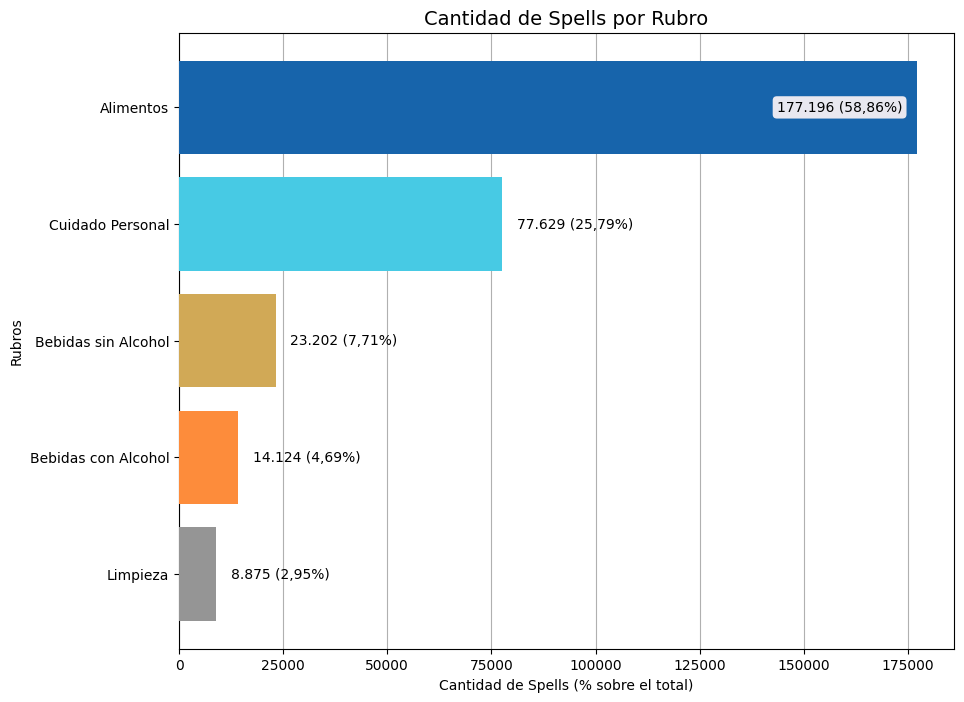

In [ ]:
## CANTIDAD DE SPELLS POR RUBRO ##

# Filtramos el DataFrame para excluir la fila "Total"
resumen_rubros_sin_total = resumen_rubros[resumen_rubros['Rubro'] != 'Total']

# Ordenamos el DataFrame de mayor a menor cantidad de spells
resumen_rubros_sin_total = resumen_rubros_sin_total.sort_values(by='Spells', ascending=False)

# Asignamos colores específicos según el rubro utilizando el diccionario de colores
resumen_rubros_sin_total['Color'] = resumen_rubros_sin_total['Rubro'].map(color_dict)

# Definimos el tamaño del gráfico
fig, ax = plt.subplots(figsize=(10, 8))

# Creamos el gráfico de barras horizontales utilizando los colores asignados
bars = ax.barh(resumen_rubros_sin_total['Rubro'], resumen_rubros_sin_total['Spells'], color=resumen_rubros_sin_total['Color'], zorder=3)

# Añadimos etiquetas con cantidad y porcentaje
for i, (spells, percent) in enumerate(zip(resumen_rubros_sin_total['Spells'], resumen_rubros_sin_total['%_Spells'])):
    # Formateamos cantidad de spells con separador de miles como punto
    spells_formatted = f"{spells:,.0f}".replace(",", ".")

    # Formateamos porcentaje con coma para decimales
    percent_formatted = f"{percent:.2f}".replace('.', ',')

    # Si la barra es demasiado larga y la etiqueta se sale del cuadrante
    if spells > resumen_rubros_sin_total['Spells'].max() * 0.9:
        # Colocar etiqueta dentro de la barra con un fondo gris, más alto y redondeado
        ax.text(spells - spells * 0.02, i, f'{spells_formatted} ({percent_formatted}%)',
                va='center', ha='right', fontsize=10, color='black',
                bbox=dict(facecolor='#e9e8f0', edgecolor='none', boxstyle='round,pad=0.3'))
    else:
        # Colocamos etiqueta al final de la barra
        ax.text(spells + resumen_rubros_sin_total['Spells'].max() * 0.02, i, f'{spells_formatted} ({percent_formatted}%)',
                va='center', ha='left', fontsize=10, color='black')

# Configuramos los ejes y el título
ax.set_xlabel('Cantidad de Spells (% sobre el total)')
ax.set_ylabel('Rubros')
ax.set_title('Cantidad de Spells por Rubro', fontsize=14)
ax.invert_yaxis()

# Eliminamos la cuadrícula horizontal y dejamos solo la vertical
ax.grid(True, axis='x', zorder=0)  # Muestra solo la cuadrícula vertical
ax.grid(False, axis='y')  # Eliminamos la cuadrícula horizontal

# Mostramos el gráfico
plt.show()


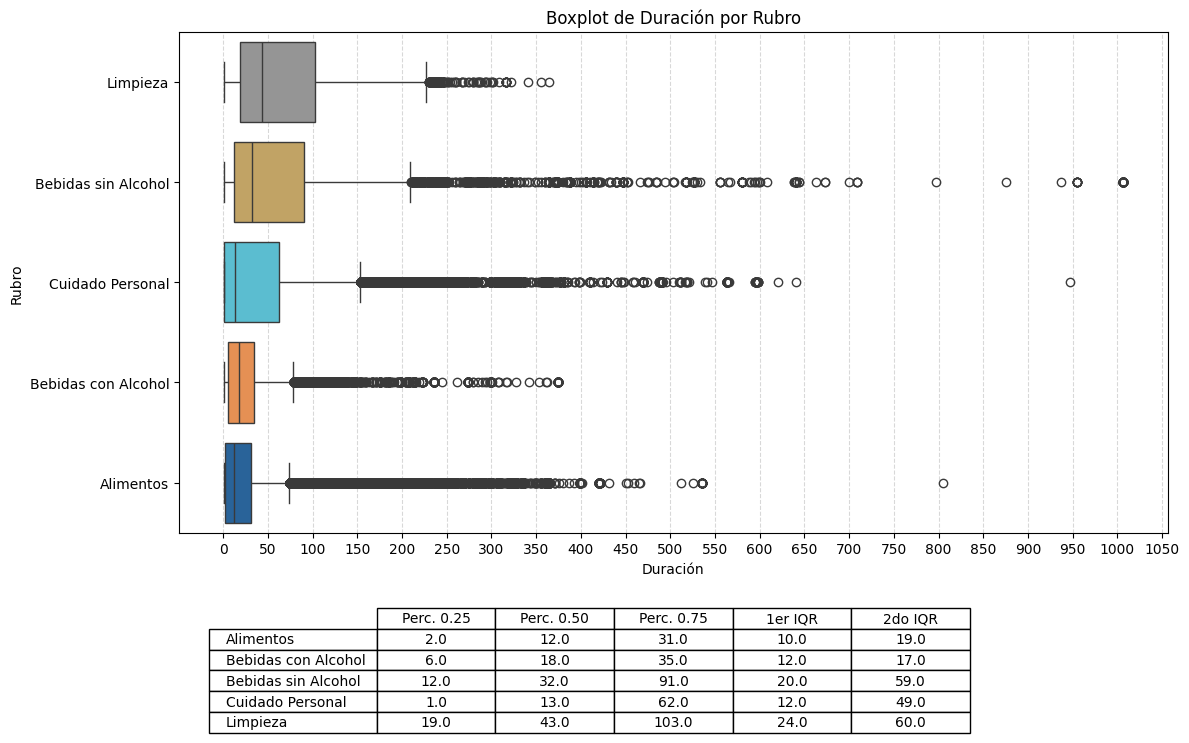

In [ ]:
## BOXPLOT POR RUBRO (ordenado por media de la Duración en forma descendente) ##

# Calculamos percentiles y rangos intercuartílicos para cada rubro
percentiles_rubros = df_price_spell_ML.groupby('Rubro')['Duración'].quantile([0.25, 0.5, 0.75]).unstack()
percentiles_rubros.columns = ['Perc. 0.25', 'Perc. 0.50', 'Perc. 0.75']
percentiles_rubros['1er IQR'] = percentiles_rubros['Perc. 0.50'] - percentiles_rubros['Perc. 0.25']
percentiles_rubros['2do IQR'] = percentiles_rubros['Perc. 0.75'] - percentiles_rubros['Perc. 0.50']

# Ordenamos los rubros según la media de 'Duración' en forma descendente
ordered_rubros = df_price_spell_ML.groupby('Rubro')['Duración'].mean().sort_values(ascending=False).index

plt.figure(figsize=(12, 8))
sns.boxplot(x='Duración', y='Rubro', data=df_price_spell_ML, hue='Rubro', palette=color_dict,
            order=ordered_rubros)  # Usamos la lista ordenada de rubros
plt.title('Boxplot de Duración por Rubro')
plt.xlabel('Duración')  # Etiqueta del eje X
plt.ylabel('Rubro')  # Etiqueta del eje Y

# Definimos los ticks en el eje X con intervalos de 50 hasta un máximo de 1050
ticks_50 = np.arange(0, 1051, 50)  # Intervalos de 50 hasta 1050
plt.xticks(ticks_50)  # Establecemos los ticks en el eje X

# Agregamos grid solo en el eje X, con transparencia
plt.grid(axis='x', linestyle='--', color='gray', alpha=0.3)

# Agregamos tabla con percentiles y rangos intercuartílicos
plt.table(cellText=percentiles_rubros.values,
          colLabels=percentiles_rubros.columns,
          rowLabels=percentiles_rubros.index,
          cellLoc='center',
          loc='bottom',
          bbox=[0.2, -0.4, 0.6, 0.25])  # Ajusta la posición y tamaño de la tabla

plt.tight_layout()
plt.show()

#### **2.4**  **Frecuencialidad por <ins>CADENA</ins>**


In [ ]:
# 1. Agrupamos por 'Cadena' y calculamos las métricas requeridas
resumen_cadenas = df_price_spell_ML.groupby(['Cadena']).agg(
    Spells=('Intervalo', 'count'),  # Cantidad de Spells
    Promoción=('Promoción', lambda x: (x == 1).sum()),  # Cantidad de Spells en Promoción
    Duración_Media=('Duración', 'mean'),  # Media de la duración
    Mediana=('Duración', 'median'),  # Mediana de la duración
    Desviación_estándar=('Duración', 'std'),  # Desviación estándar de la duración
    Establecimientos=('ID_establecimiento', 'nunique'),  # Cantidad de establecimientos
    Productos_informados=('ID_producto', 'nunique')  # Cantidad de productos informados
).reset_index()

# 2. Calculamos combinaciones únicas por 'Cadena'
combinaciones_unicas = df_price_spell_ML[['Cadena', 'ID_establecimiento', 'ID_producto']].drop_duplicates()
combinaciones_count = combinaciones_unicas.groupby(['Cadena']).size().reset_index(name='Combinaciones')

# 3. Unimos la tabla de combinaciones únicas con el resumen de cadenas
resumen_cadenas = pd.merge(resumen_cadenas, combinaciones_count, on=['Cadena'], how='left')

# 4. Calculamos los porcentajes
total_spells = df_price_spell_ML.shape[0]  # Total de Spells
num_establecimientos = df_price_spell_ML['ID_establecimiento'].nunique()  # Total de Establecimientos
num_productos = df_price_spell_ML['ID_producto'].nunique()  # Total de Productos
num_combinaciones_unicas = combinaciones_unicas.shape[0]  # Total de combinaciones

resumen_cadenas['%_Spells'] = (resumen_cadenas['Spells'] / total_spells * 100).round(2)
resumen_cadenas['%_Promoción'] = (resumen_cadenas['Promoción'] / resumen_cadenas['Spells'] * 100).round(2)
resumen_cadenas['%_establecimientos'] = (resumen_cadenas['Establecimientos'] / num_establecimientos * 100).round(2)
resumen_cadenas['%_productos'] = (resumen_cadenas['Productos_informados'] / num_productos * 100).round(2)

# 5. Redondeamos las métricas de duración a 2 decimales
resumen_cadenas['Duración_Media'] = resumen_cadenas['Duración_Media'].round(2)
resumen_cadenas['Mediana'] = resumen_cadenas['Mediana'].round(2)
resumen_cadenas['Desviación_estándar'] = resumen_cadenas['Desviación_estándar'].round(2)

# 6. Reordenamos las columnas
resumen_cadenas = resumen_cadenas[['Cadena', 'Spells', '%_Spells', 'Promoción', '%_Promoción',
                                   'Duración_Media', 'Mediana', 'Desviación_estándar',
                                   'Establecimientos', '%_establecimientos',
                                   'Productos_informados', '%_productos']]

# 7. Ordenamos la tabla por 'Spells' en orden decreciente
resumen_cadenas = resumen_cadenas.sort_values(by='Spells', ascending=False)

# 8. Calculamos las sumas totales
total_promocion = df_price_spell_ML['Promoción'].sum()
media_duracion_total = round(df_price_spell_ML['Duración'].mean(), 2)
mediana_duracion_total = round(df_price_spell_ML['Duración'].median(), 2)
std_duracion_total = round(df_price_spell_ML['Duración'].std(), 2)

# 9. Creamos una fila con los totales
fila_total = pd.DataFrame({
    'Cadena': ['Total'],
    'Spells': [total_spells],
    '%_Spells': [100.00],
    'Promoción': [total_promocion],
    '%_Promoción': [round(total_promocion / total_spells * 100, 2)],
    'Duración_Media': [media_duracion_total],
    'Mediana': [mediana_duracion_total],
    'Desviación_estándar': [std_duracion_total],
    'Establecimientos': [num_establecimientos],
    '%_establecimientos': [100.00],
    'Productos_informados': [num_productos],
    '%_productos': [100.00]
})

# 10. Añadimos la fila total al final del DataFrame
resumen_cadenas = pd.concat([resumen_cadenas, fila_total], ignore_index=True)

# 11. Visualizamos el DataFrame final
resumen_cadenas


Cadena  Spells  %_Spells  Promoción  %_Promoción  \
0                    Disco   66301     22.03      30879        46.57   
1           Devoto Express   56276     18.69      22485        39.95   
2                Farmashop   49308     16.38          0         0.00   
3                   Devoto   35390     11.76      17998        50.86   
4               Red Expres   22646      7.52       3917        17.30   
5               Sin Cadena    8658      2.88        820         9.47   
6     Supermercados Grupal    8067      2.68       1540        19.09   
7               Red Market    7630      2.53       1115        14.61   
8                San Roque    7442      2.47          0         0.00   
9           Tienda Inglesa    6651      2.21       1725        25.94   
10  Macromercado Mayorista    6528      2.17        315         4.83   
11                   Kinko    6218      2.07        447         7.19   
12                 Pigalle    4454      1.48       1936        43.47   
13              Super Tico    3008      1.00          4         0.13   
14                   Frigo    2695      0.90        546        20.26   
15       Supercados Grupal    1883      0.63        387        20.55   
16                   Géant    1815      0.60        869        47.88   
17             Micro Macro    1586      0.53         36         2.27   
18             La Colonial    1446      0.48          0         0.00   
19                  Ubesur    1364      0.45        368        26.98   
20                 Tamisur     932      0.31          0         0.00   
21                 Ta - Ta     367      0.12          3         0.82   
22                    Frog     361      0.12        114        31.58   
23                   Total  301026    100.00      85504        28.40   

    Duración_Media  Mediana  Desviación_estándar  Establecimientos  \
0            21.97      6.0                47.93                20   
1            30.99     12.0                58.97                28   
2            51.20      4.0                85.97                70   
3            30.39     12.0                59.88                17   
4            47.68     30.0                55.22                10   
5            56.27     31.0                68.42                 9   
6            47.60     29.0                59.14                 6   
7            57.48     33.0                63.98                 8   
8            27.25      3.0                62.14                15   
9            44.47     24.0                53.33                 8   
10           37.81     21.0                48.67                 4   
11           90.96     81.0                80.10                27   
12           64.90     41.0                80.04                17   
13           90.23     66.0                83.40                 5   
14           51.95     30.0                60.32                 3   
15           45.05     29.0                61.30                 1   
16           33.18     14.0                61.33                 1   
17           35.12     16.0                54.20                 2   
18           85.18     71.0                75.74                 4   
19           56.68     31.0                62.48                 1   
20           63.04     37.0                63.81                 1   
21           34.09     15.0                46.06                13   
22           44.58     31.0                36.56                19   
23           38.83     14.0                65.25               289   

    %_establecimientos  Productos_informados  %_productos  
0                 6.92                    80        53.33  
1                 9.69                    76        50.67  
2                24.22                    40        26.67  
3                 5.88                    80        53.33  
4                 3.46                   113        75.33  
5                 3.11                   133        88.67  
6                 2.08                   129    

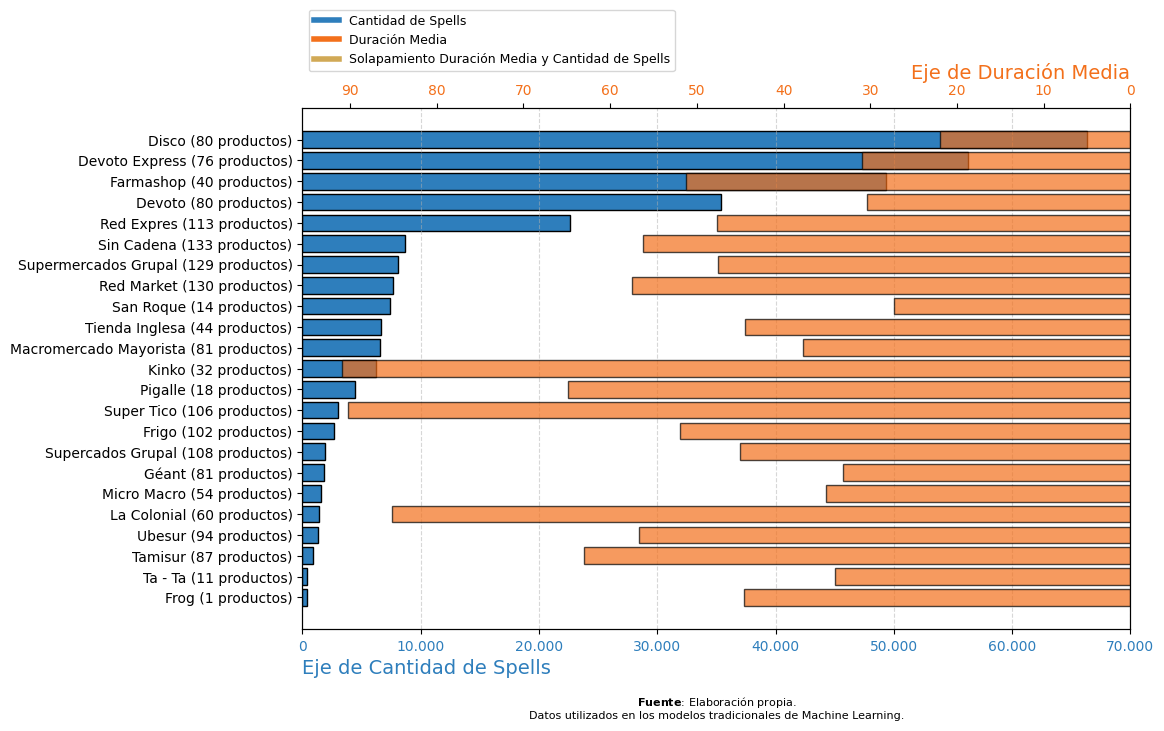

/content/Cantidad_spells_y_duracion_por_Cadena.png

In [ ]:
## GRÁFICO COMPARATIVO ENTRE SPELLS Y DURACIÓN MEDIO ##

# Filtramos y ordenamos datos
resumen_cadenas_filtrado = resumen_cadenas[resumen_cadenas['Cadena'] != 'Total']
resumen_cadenas_filtrado = resumen_cadenas_filtrado.sort_values(by='Spells', ascending=True)

# Creamos etiquetas personalizadas para cada cadena con la cantidad de productos informados
etiquetas_cadenas = [
    f"{cadena} ({productos} productos)"
    for cadena, productos in zip(resumen_cadenas_filtrado['Cadena'], resumen_cadenas_filtrado['Productos_informados'])
]

# Tamaño de la figura
fig, ax1 = plt.subplots(figsize=(12, 8))

# Paletas de color
color_barras_spells = cm.Blues(0.7)  # Color de Blues para Cantidad de Spells
color_barras_duracion = cm.Oranges(0.6)  # Color de Oranges para Duración Media
color_solape = cmap_dorados_muy_suave(0.5)  # Color de Goldens para el solapamiento

# Gráfico de barras horizontal para la cantidad de Spells (a la derecha)
ax1.barh(etiquetas_cadenas, resumen_cadenas_filtrado['Spells'], color=color_barras_spells, label='Cantidad de Spells', edgecolor='black')
ax1.set_xlabel('Eje de Cantidad de Spells', color=color_barras_spells, fontsize=14, ha='left', x=0)
ax1.tick_params(axis='x', labelcolor=color_barras_spells)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True, prune='upper'))
ax1.set_xticks(range(0, 70001, 10000))  # Establecer los ticks cada 10,000 hasta 70,000
ax1.set_xlim(0, 70000)  # Establecer el límite superior en 70,000

# Creamos segundo eje Y opuesto para la Duración Media (a la izquierda)
ax2 = ax1.twiny()
ax2.barh(etiquetas_cadenas, resumen_cadenas_filtrado['Duración_Media'], color=color_barras_duracion, label='Duración Media', alpha=0.7, edgecolor='black')
ax2.invert_xaxis()  # Invierte el eje para que las barras apunten hacia la izquierda
ax2.set_xlabel('Eje de Duración Media', color=color_barras_duracion, fontsize=14, ha='right', x=1)
ax2.tick_params(axis='x', labelcolor=color_barras_duracion)
ax2.xaxis.set_major_locator(MaxNLocator(integer=True, prune='upper'))

# Cambiamosel color de las barras donde se solapen
for i, duracion_media in enumerate(resumen_cadenas_filtrado['Duración_Media']):
    if resumen_cadenas_filtrado['Spells'].iloc[i] <= duracion_media:
        ax1.patches[i].set_color(color_solape)
        ax2.patches[i].set_color(color_solape)

# Agregamos la cuadrícula vertical detrás de las barras
ax1.grid(True, axis='x', linestyle='--', alpha=0.5, zorder=0)  # Cuadrícula detrás de las barras
for patch in ax1.patches:
    patch.set_zorder(1)  # Coloca las barras por encima de la cuadrícula

# Agregamos el separador de miles en el eje X
ax1.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.0f}'.format(x).replace(",", ".")))
ax2.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.0f}'.format(x).replace(",", ".")))

# Leyenda personalizada para los colores
custom_lines = [Line2D([0], [0], color=color_barras_spells, lw=4, label="Cantidad de Spells"),
                Line2D([0], [0], color=color_barras_duracion, lw=4, label="Duración Media"),
                Line2D([0], [0], color=color_solape, lw=4, label="Solapamiento Duración Media y Cantidad de Spells")]

# Colocamos la leyenda dentro del gráfico en la parte inferior derecha
plt.legend(handles=custom_lines, loc="upper left", bbox_to_anchor=(0, 1.2), fontsize=9)

# Agregamos un disclaimer en el gráfico
plt.text(0.5, -0.15,
         r'$\bf{Fuente}$: Elaboración propia.' + '\nDatos utilizados en los modelos tradicionales de Machine Learning.',
         ha='center', va='center', transform=plt.gca().transAxes, fontsize=8)

# Ajustamos el layout para evitar solapamientos
fig.tight_layout(pad=2)

# Guardamos la imagen localmente en el directorio actual
filename = "Cantidad_spells_y_duracion_por_Cadena.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')

# Mostramos
plt.show()

# Creamos un enlace de descarga (queda guardado en entorno)
display(FileLink(filename))


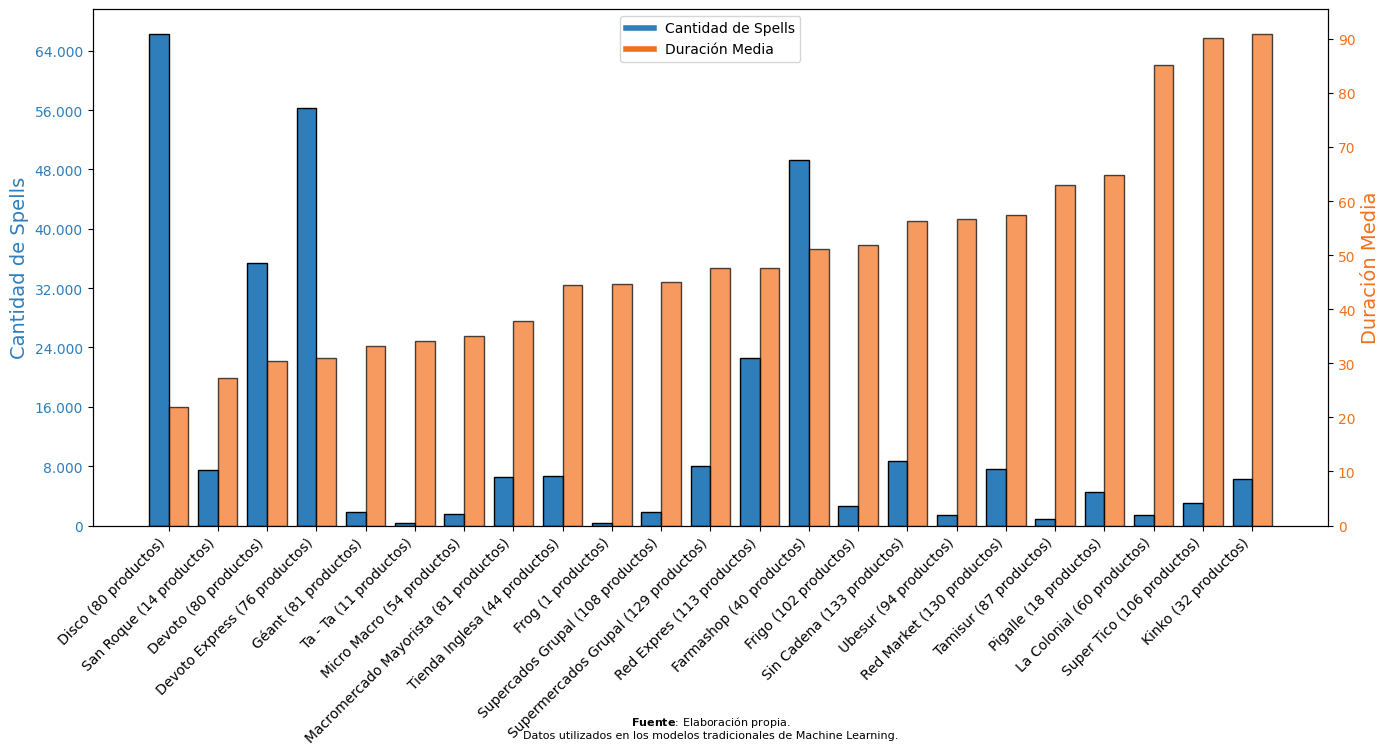

/content/Cantidad_spells_y_duracion_por_Cadena_vertical_ordenado.png

In [ ]:
## GRÁFICO COMPARATIVO ENTRE SPELLS Y DURACIÓN MEDIO (Barras Verticales) ##

# Filtramos y ordenamos datos por Duración Media en forma creciente
resumen_cadenas_filtrado = resumen_cadenas[resumen_cadenas['Cadena'] != 'Total']
resumen_cadenas_filtrado = resumen_cadenas_filtrado.sort_values(by='Duración_Media', ascending=True)

# Creamos etiquetas para el eje X con la cantidad de productos entre paréntesis
etiquetas_cadenas = [
    f"{cadena} ({productos} productos)"
    for cadena, productos in zip(resumen_cadenas_filtrado['Cadena'], resumen_cadenas_filtrado['Productos_informados'])
]

# Tamaño de la figura
fig, ax1 = plt.subplots(figsize=(14, 8))

# Colores para las barras respetando la paleta original
color_barras_spells = cm.Blues(0.7)  # Color de Blues para Cantidad de Spells
color_barras_duracion = cm.Oranges(0.6)  # Color de Oranges para Duración Media

# Ancho de las barras
bar_width = 0.4  # Ancho reducido para evitar solapamientos

# Creamos barras para la cantidad de Spells (eje Y izquierdo)
x_indices = range(len(etiquetas_cadenas))  # Índices para las etiquetas
ax1.bar(
    [x - bar_width / 2 for x in x_indices],  # Desplaza ligeramente hacia la izquierda
    resumen_cadenas_filtrado['Spells'],
    color=color_barras_spells,
    label='Cantidad de Spells',
    edgecolor='black',
    width=bar_width
)
ax1.set_ylabel('Cantidad de Spells', color=color_barras_spells, fontsize=14)
ax1.tick_params(axis='y', labelcolor=color_barras_spells)
ax1.yaxis.set_major_locator(MaxNLocator(integer=True, prune='upper'))

# Creamos el segundo eje Y para la Duración Media
ax2 = ax1.twinx()
ax2.bar(
    [x + bar_width / 2 for x in x_indices],  # Desplaza ligeramente hacia la derecha
    resumen_cadenas_filtrado['Duración_Media'],
    color=color_barras_duracion,
    label='Duración Media',
    alpha=0.7,
    edgecolor='black',
    width=bar_width
)
ax2.set_ylabel('Duración Media', color=color_barras_duracion, fontsize=14)
ax2.tick_params(axis='y', labelcolor=color_barras_duracion)
ax2.yaxis.set_major_locator(MaxNLocator(integer=True, prune='upper'))

# Configuramos el eje X con las etiquetas de cadenas
ax1.set_xticks(range(len(etiquetas_cadenas)))
ax1.set_xticklabels(etiquetas_cadenas, rotation=45, ha='right', fontsize=10)

# Cambiamos el separador de miles a punto
ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.0f}'.format(x).replace(",", ".")))
ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.0f}'.format(x).replace(",", ".")))

# Leyenda personalizada respetando los colores
custom_lines = [
    Line2D([0], [0], color=color_barras_spells, lw=4, label="Cantidad de Spells"),
    Line2D([0], [0], color=color_barras_duracion, lw=4, label="Duración Media")
]
ax1.legend(
    handles=custom_lines,
    loc="upper center",
    bbox_to_anchor=(0.5, 1),
    fontsize=10
)

# Agregamos un disclaimer debajo del gráfico
plt.text(
    0.5, -0.39,
    r'$\bf{Fuente}$: Elaboración propia.' + '\nDatos utilizados en los modelos tradicionales de Machine Learning.',
    ha='center', va='center', transform=plt.gca().transAxes, fontsize=8
)

# Ajustamos el diseño para evitar solapamientos
fig.tight_layout()

# Guardamos la imagen localmente en el directorio actual
filename = "Cantidad_spells_y_duracion_por_Cadena_vertical_ordenado.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')

# Mostramos
plt.show()

# Creamos un enlace de descarga (queda guardado en entorno)
display(FileLink(filename))


In [ ]:
# Filtramos datos para Farmashop
df_farmashop = df_price_spell_ML[df_price_spell_ML['Cadena'] == 'Farmashop']

# Agrupamos por Rubro para obtener cantidad de observaciones y productos distintos
df_farmashop_rubro = df_farmashop.groupby('Rubro').agg(
    Cantidad_observaciones=('Duración', 'size'),
    Cantidad_productos=('ID_producto', 'nunique')
).reset_index()

# Calculamos el total de spells
total_spells_farmashop = df_farmashop_rubro['Cantidad_observaciones'].sum()

# Agregamos columna de porcentaje
df_farmashop_rubro['%_spells'] = (df_farmashop_rubro['Cantidad_observaciones'] / total_spells_farmashop * 100).round(2)

# Creamos fila total
fila_total = pd.DataFrame({
    'Rubro': ['Total'],
    'Cantidad_observaciones': [total_spells_farmashop],
    'Cantidad_productos': [df_farmashop['ID_producto'].nunique()],
    '%_spells': [100.0]
})

# Concatenamos todo
df_farmashop_rubro = pd.concat([df_farmashop_rubro, fila_total], ignore_index=True)

df_farmashop_rubro

Rubro  Cantidad_observaciones  Cantidad_productos  %_spells
0            Alimentos                     704                   1      1.43
1  Bebidas sin Alcohol                    2326                   4      4.72
2     Cuidado Personal                   43256                  32     87.73
3             Limpieza                    3022                   3      6.13
4                Total                   49308                  40    100.00

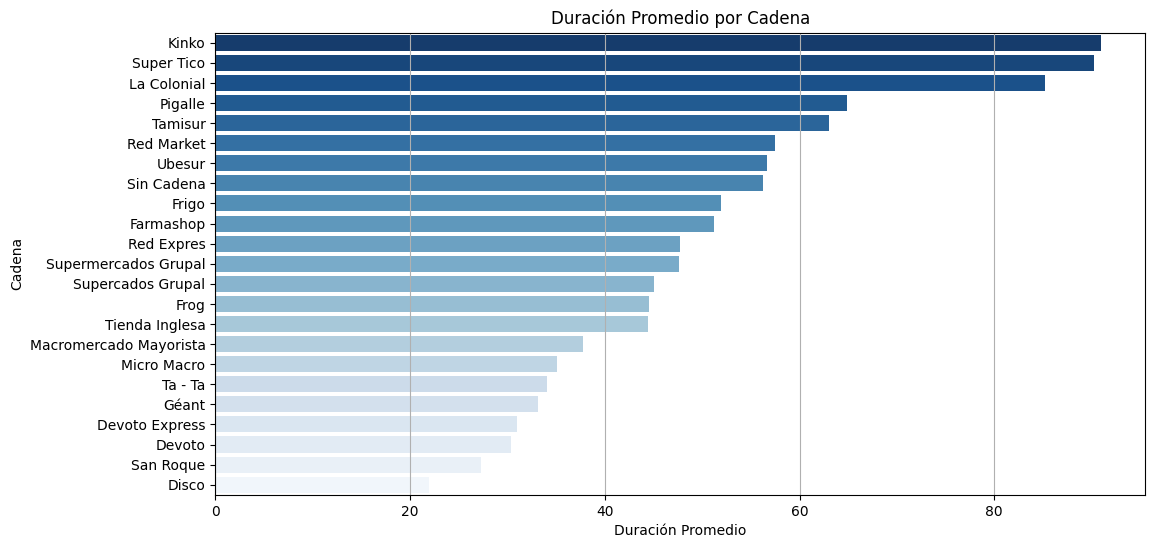

In [ ]:
## GRÁFICO DE DURACIÓN MEDIA POR CADENA ##

# Calculamos la duración promedio por cadena
duracion_promedio_cadena = df_price_spell_ML.groupby('Cadena')['Duración'].mean().reset_index()

# Ordenamos el DataFrame por duración promedio en orden decreciente
duracion_promedio_cadena = duracion_promedio_cadena.sort_values(by='Duración', ascending=False)

# Gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(data=duracion_promedio_cadena, x='Duración', y='Cadena', palette='Blues_r') # 'Blues_r' invierte el sentido para que empiece con el más oscuro
plt.title('Duración Promedio por Cadena')
plt.xlabel('Duración Promedio')
plt.ylabel('Cadena')
plt.grid(axis='x')
plt.show()


A continación se presenta **la <ins>distribución de cadenas</ins> según <ins>tipo de establecimiento</ins>**. Es importante aclarar que, exceptuando los tipos de establecimiento "Tiendas Express" y "Farmacias" que se definen por la especialidad de la cadena especifica, **los "Hipermercados", "Supermercados" y "Minimercados" se determinan en función de** **<ins>la cantidad de cajas disponibles en cada establecimiento</ins>**, lo que ocasiona que **algunas cadenas puedan tener más de un tipo de establecimiento a la vez**.

In [ ]:
## TABLA CON INFORMACIÓN DE CADENA Y TIPO DE ESTABLECIMIENTO ##

# 1. Agrupamos el DataFrame por 'Tipo_establecimiento' y 'Cadena'
resumen_cadenas = df_price_spell_ML.groupby(['Tipo_establecimiento', 'Cadena']).agg(
    Establecimientos=('ID_establecimiento', 'nunique'),
    Productos_informados=('ID_producto', 'nunique'),
    Spells=('Intervalo', 'count'),  # Cuenta la cantidad de observaciones del campo Intervalo
    Duración_Media=('Duración', 'mean')  # Calcula la media de la duración
).reset_index()

# 2. Filtramos las cadenas con registros (Productos_informados > 0)
resumen_cadenas = resumen_cadenas[resumen_cadenas['Productos_informados'] > 0]

# 3. Calculamos combinaciones únicas por 'Tipo_establecimiento' y 'Cadena'
combinaciones_unicas = df_price_spell_ML[['Tipo_establecimiento', 'Cadena', 'ID_establecimiento', 'ID_producto']].drop_duplicates()
combinaciones_count = combinaciones_unicas.groupby(['Tipo_establecimiento', 'Cadena']).size().reset_index(name='Combinaciones')

# 4. Unimos la tabla de combinaciones únicas con el resumen de cadenas
resumen_cadenas = pd.merge(resumen_cadenas, combinaciones_count, on=['Tipo_establecimiento', 'Cadena'], how='left')

# 5. Calculamos el porcentaje de establecimientos, productos y combinaciones
num_establecimientos = df_price_spell_ML['ID_establecimiento'].nunique()
num_productos = df_price_spell_ML['ID_producto'].nunique()
num_combinaciones_unicas = combinaciones_unicas.shape[0]

resumen_cadenas['%_establecimientos'] = (resumen_cadenas['Establecimientos'] / num_establecimientos * 100).round(2)
resumen_cadenas['%_productos'] = (resumen_cadenas['Productos_informados'] / num_productos * 100).round(2)
resumen_cadenas['%_combinaciones'] = (resumen_cadenas['Combinaciones'] / num_combinaciones_unicas * 100).round(2)

# 6. Calculamos %_Spells sobre el total
total_observaciones = len(df_price_spell_ML)  # Total de observaciones (Spells)
resumen_cadenas['%_Spells'] = (resumen_cadenas['Spells'] / total_observaciones * 100).round(2)

# 7. Redondeamos Duración_Media a 2 decimales
resumen_cadenas['Duración_Media'] = resumen_cadenas['Duración_Media'].round(2)

# 8. Reordenamos columnas
resumen_cadenas = resumen_cadenas[['Tipo_establecimiento', 'Cadena', 'Establecimientos', '%_establecimientos', 'Productos_informados', '%_productos', 'Combinaciones', '%_combinaciones', 'Spells', '%_Spells', 'Duración_Media']]

# 9. Ordenamos la tabla por 'Spells' en orden decreciente y luego por 'Cadena'
resumen_cadenas = resumen_cadenas.sort_values(by=['Cadena', 'Spells'], ascending=[True, True])

# 10. Calculamos las sumas de Establecimientos, Combinaciones y Spells
total_establecimientos = resumen_cadenas['Establecimientos'].sum()
total_combinaciones = resumen_cadenas['Combinaciones'].sum()
total_spells = resumen_cadenas['Spells'].sum()

# 11. Calculamos la media global de Duración
media_duracion_total = df_price_spell_ML['Duración'].mean().round(2)

# 12. Creamos una fila con los totales
fila_total = pd.DataFrame({
    'Tipo_establecimiento': ['Total'],
    'Cadena': ['Total'],
    'Establecimientos': [total_establecimientos],
    '%_establecimientos': [100.00],
    'Productos_informados': ['-'],
    '%_productos': ['-'],
    'Combinaciones': [total_combinaciones],
    '%_combinaciones': [100.00],
    'Spells': [total_spells],
    '%_Spells': [100.00],
    'Duración_Media': [media_duracion_total]
})

# 13. Añadimos la fila total al final del DataFrame
resumen_cadenas = pd.concat([resumen_cadenas, fila_total], ignore_index=True)

# 14. Visualización del DataFrame resultante
resumen_cadenas

Tipo_establecimiento                  Cadena  Establecimientos  \
0          Hipermercado                  Devoto                 4   
1          Supermercado                  Devoto                13   
2        Tienda Express          Devoto Express                28   
3          Hipermercado                   Disco                 4   
4          Supermercado                   Disco                16   
5              Farmacia               Farmashop                70   
6          Supermercado                   Frigo                 3   
7        Tienda Express                    Frog                19   
8          Hipermercado                   Géant                 1   
9        Tienda Express                   Kinko                27   
10          Minimercado             La Colonial                 4   
11         Hipermercado  Macromercado Mayorista                 1   
12         Supermercado  Macromercado Mayorista                 3   
13       Tienda Express             Micro Macro                 2   
14             Farmacia                 Pigalle                17   
15          Minimercado              Red Expres                 3   
16         Supermercado              Red Expres                 7   
17         Supermercado              Red Market                 1   
18          Minimercado              Red Market                 7   
19             Farmacia               San Roque                15   
20          Minimercado              Sin Cadena                 3   
21         Supermercado              Sin Cadena                 6   
22         Supermercado              Super Tico                 2   
23          Minimercado              Super Tico                 3   
24         Supermercado       Supercados Grupal                 1   
25          Minimercado    Supermercados Grupal                 1   
26         Supermercado    Supermercados Grupal                 5   
27         Hipermercado                 Ta - Ta                 1   
28          Minimercado                 Ta - Ta                 3   
29         Supermercado                 Ta - Ta                 9   
30         Supermercado                 Tamisur                 1   
31         Hipermercado          Tienda Inglesa                 3   
32         Supermercado          Tienda Inglesa                 5   
33          Minimercado                  Ubesur                 1   
34                Total                   Total               289   

    %_establecimientos Productos_informados %_productos  Combinaciones  \
0                 1.38                   80       53.33            319   
1                 4.50                   80       53.33           1010   
2                 9.69                   76       50.67           2111   
3                 1.38                   80       53.33            318   
4                 5.54                   80       53.33           1257   
5                24.22                   40       26.67           2800   
6                 1.04                  102        68.0            243   
7                 6.57                    1        0.67             19   
8                 0.35                   81        54.0             81   
9                 9.34                   32       21.33            864   
10                1.38                   60        40.0            240   
11                0.35                   76       50.67             76   
12                1.04                   79       52.67            217   
13                0.69                   54        36.0             63   
14                5.88                   18        12.0            306   
15                1.04                  111        74.0            333   
16                2.42                  113       75.33            778   
17                0.35                   65       43.33             65   
18                2.42                  129        86.0            578   
19                5.19                

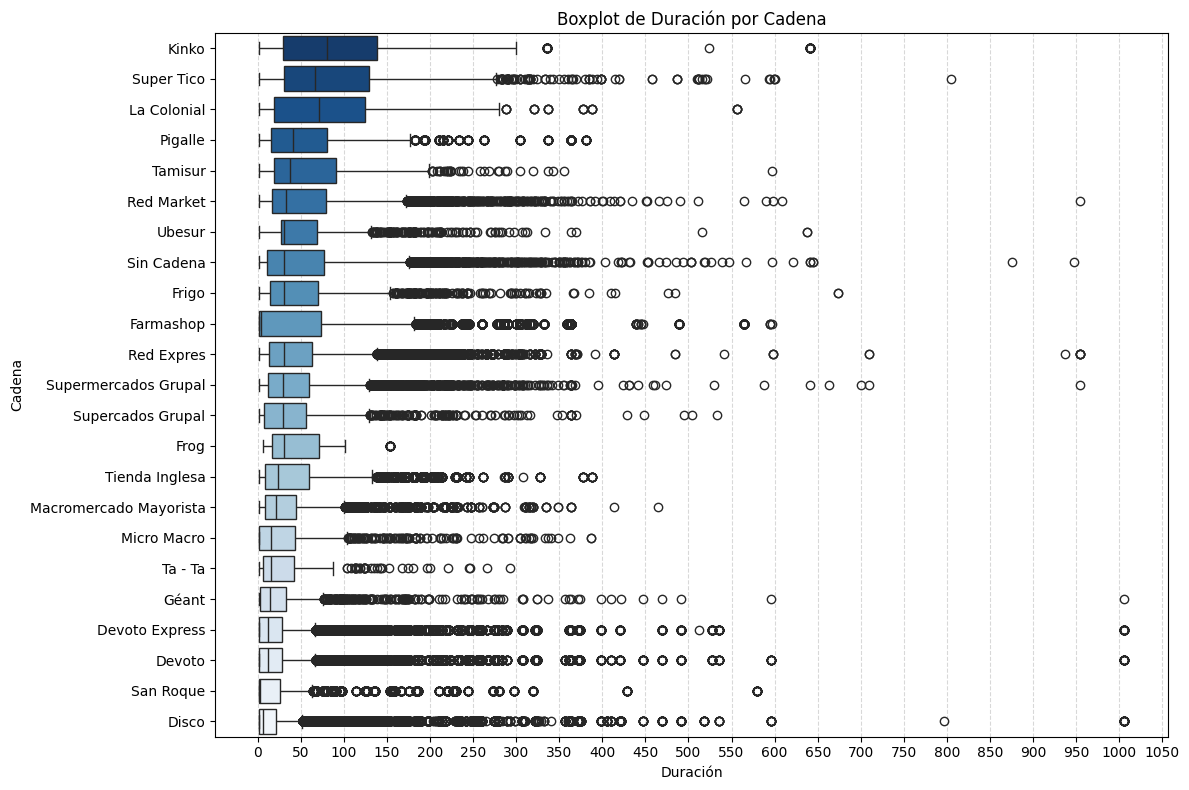

In [ ]:
## BOXPLOT POR CADENA (ordenado por la media de la Duración en forma descendente) ##

# Ordenamos las cadenas según la media de 'Duración' en forma descendente
ordered_cadenas = df_price_spell_ML.groupby('Cadena')['Duración'].mean().sort_values(ascending=False).index

plt.figure(figsize=(12, 8))
sns.boxplot(x='Duración', y='Cadena', data=df_price_spell_ML, palette='Blues_r',
            order=ordered_cadenas)  # Usamos la lista ordenada de cadenas
plt.title('Boxplot de Duración por Cadena')
plt.xlabel('Duración')  # Etiqueta del eje X
plt.ylabel('Cadena')  # Etiqueta del eje Y

# Definimos los ticks en el eje X con intervalos de 50 hasta un máximo de 1050
ticks_50 = np.arange(0, 1051, 50)  # Intervalos de 50 hasta 1050
plt.xticks(ticks_50)  # Establecer los ticks en el eje X

# Agregamos grid solo en el eje X, con transparencia
plt.grid(axis='x', linestyle='--', color='gray', alpha=0.3)

plt.tight_layout()
plt.show()


#### **2.5**  **Frecuencialidad por <ins>TIPO DE ESTABLECIMIENTO</ins>**


In [ ]:

# Agrupamos por 'Tipo_establecimiento' y calculamos las métricas
resumen_tipo_establecimiento = df_price_spell_ML.groupby('Tipo_establecimiento').agg(
    Spells=('Intervalo', 'count'),
    Promoción=('Promoción', 'sum'),  # Total de spells en promoción
    Duración_Media=('Duración', 'mean'),
    Mediana=('Duración', 'median'),
    Desviación_estándar=('Duración', 'std'),
    Establecimientos=('ID_establecimiento', 'nunique'),
    Productos_informados=('ID_producto', 'nunique')
).reset_index()

# Calculamos totales
total_spells = resumen_tipo_establecimiento['Spells'].sum()
total_promocion = resumen_tipo_establecimiento['Promoción'].sum()
num_establecimientos = df_price_spell_ML['ID_establecimiento'].nunique()
num_productos = df_price_spell_ML['ID_producto'].nunique()

# Calculamos porcentajes
resumen_tipo_establecimiento['%_Spells'] = (resumen_tipo_establecimiento['Spells'] / total_spells * 100).round(2)
resumen_tipo_establecimiento['%_Promoción'] = (resumen_tipo_establecimiento['Promoción'] / resumen_tipo_establecimiento['Spells'] * 100).round(2)
resumen_tipo_establecimiento['%_establecimientos'] = (resumen_tipo_establecimiento['Establecimientos'] / num_establecimientos * 100).round(2)
resumen_tipo_establecimiento['%_productos'] = (resumen_tipo_establecimiento['Productos_informados'] / num_productos * 100).round(2)

# Redondeamos valores
resumen_tipo_establecimiento['Duración_Media'] = resumen_tipo_establecimiento['Duración_Media'].round(2)
resumen_tipo_establecimiento['Mediana'] = resumen_tipo_establecimiento['Mediana'].round(2)
resumen_tipo_establecimiento['Desviación_estándar'] = resumen_tipo_establecimiento['Desviación_estándar'].round(2)

# Reordenamos columnas
resumen_tipo_establecimiento = resumen_tipo_establecimiento[[
    'Tipo_establecimiento',
    'Spells', '%_Spells',
    'Promoción', '%_Promoción',
    'Duración_Media', 'Mediana', 'Desviación_estándar',
    'Establecimientos', '%_establecimientos',
    'Productos_informados', '%_productos'
]]

# Ordenamos por número de spells en orden descendente
resumen_tipo_establecimiento = resumen_tipo_establecimiento.sort_values(by='Spells', ascending=False)

# Agregamos fila de totales con el cálculo correcto de %_Promoción
total_row = pd.DataFrame({
    'Tipo_establecimiento': ['Total'],
    'Spells': [total_spells],
    '%_Spells': [100.00],
    'Promoción': [total_promocion],
    '%_Promoción': [(total_promocion / total_spells * 100).round(2)],  # Cálculo corregido
    'Duración_Media': ['-'],
    'Mediana': ['-'],
    'Desviación_estándar': ['-'],
    'Establecimientos': [resumen_tipo_establecimiento['Establecimientos'].sum()],
    '%_establecimientos': [100.00],
    'Productos_informados': ['-'],
    '%_productos': ['-']
})

# Concatenamos fila total
resumen_tipo_establecimiento = pd.concat([resumen_tipo_establecimiento, total_row], ignore_index=True)

# Mostramos tabla final
resumen_tipo_establecimiento



Tipo_establecimiento  Spells  %_Spells  Promoción  %_Promoción  \
0         Supermercado  124164     41.25      44732        36.03   
1       Tienda Express   64441     21.41      23082        35.82   
2             Farmacia   61204     20.33       1936         3.16   
3         Hipermercado   30022      9.97      12799        42.63   
4          Minimercado   21195      7.04       2955        13.94   
5                Total  301026    100.00      85504        28.40   

  Duración_Media Mediana Desviación_estándar  Establecimientos  \
0          34.05    14.0                56.3                72   
1          36.95    14.0               63.63                76   
2          49.28     5.0               83.48               102   
3          26.63     9.0               52.53                14   
4          59.69    34.0               66.73                25   
5              -       -                   -               289   

   %_establecimientos Productos_informados %_productos  
0               24.91                  143       95.33  
1               26.30                   96        64.0  
2               35.29                   45        30.0  
3                4.84                  116       77.33  
4                8.65                  132        88.0  
5              100.00                    -           -

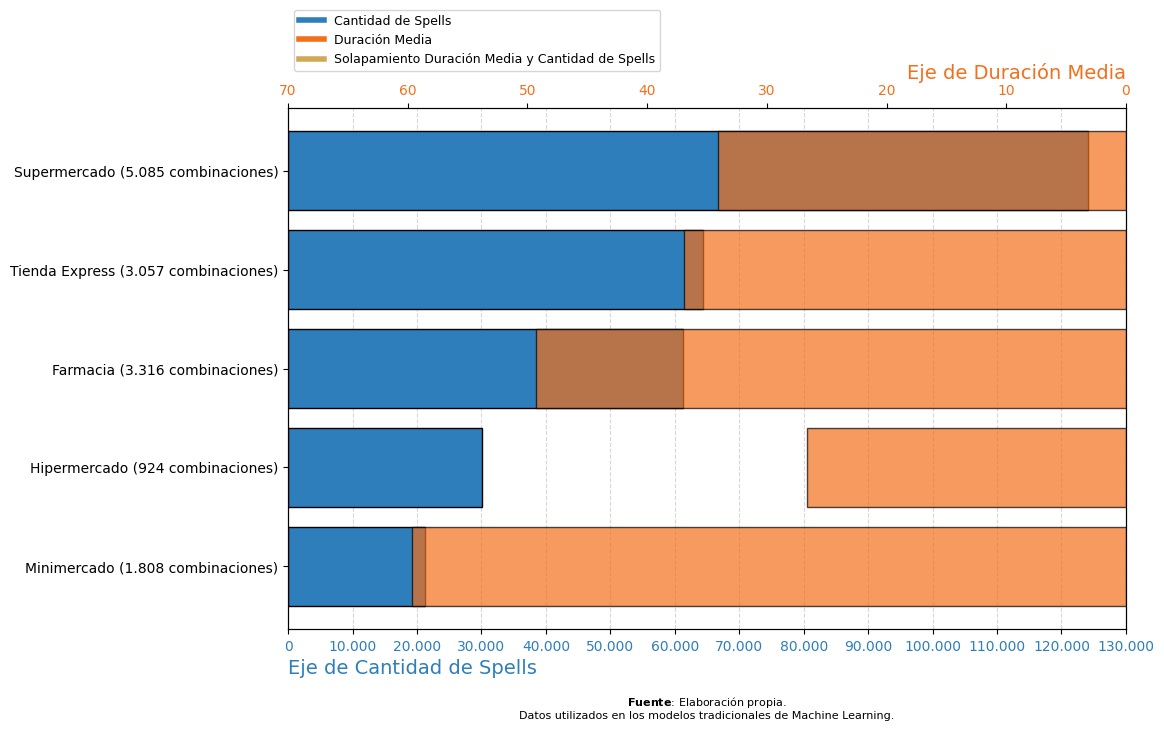

/content/Cantidad_spells_y_duracion_por_Establecimiento.png

In [ ]:
## CANTIDAD DE SPELLS Y DURACIÓN MEDIA POR TIPO DE ESTABLECIMIENTO ##

# Calculamos combinaciones únicas por tipo de establecimiento
combinaciones_por_tipo = df_price_spell_ML.groupby('Tipo_establecimiento').apply(
    lambda x: x[['ID_establecimiento', 'ID_producto']].drop_duplicates().shape[0]
)

# Asignamos las combinaciones calculadas al DataFrame resumen_tipo_establecimiento
resumen_tipo_establecimiento['Combinaciones'] = resumen_tipo_establecimiento['Tipo_establecimiento'].map(combinaciones_por_tipo)

# Filtramos y ordenamos
resumen_tipo_establecimiento_filtrado = resumen_tipo_establecimiento[resumen_tipo_establecimiento['Tipo_establecimiento'] != 'Total']
resumen_tipo_establecimiento_filtrado = resumen_tipo_establecimiento_filtrado.sort_values(by='Spells', ascending=True)

# Creamos etiquetas personalizadas con separador de miles
etiquetas_tipo_establecimiento = [
    f"{tipo} ({combinaciones:,.0f} combinaciones)".replace(",", ".")
    for tipo, combinaciones in zip(resumen_tipo_establecimiento_filtrado['Tipo_establecimiento'], resumen_tipo_establecimiento_filtrado['Combinaciones'])
]

# Tamaño de la figura
fig, ax1 = plt.subplots(figsize=(12, 8))

# Paletas de color
color_barras_spells = cm.Blues(0.7)
color_barras_duracion = cm.Oranges(0.6)
color_solape = cmap_dorados_muy_suave(0.5)

# Barras horizontales - Spells (derecha)
ax1.barh(etiquetas_tipo_establecimiento, resumen_tipo_establecimiento_filtrado['Spells'],
         color=color_barras_spells, label='Cantidad de Spells', edgecolor='black')
ax1.set_xlabel('Eje de Cantidad de Spells', color=color_barras_spells, fontsize=14, ha='left', x=0)
ax1.tick_params(axis='x', labelcolor=color_barras_spells)
ax1.set_xlim(0, 130000)
ax1.set_xticks(range(0, 130001, 10000))
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.0f}'.format(x).replace(",", ".")))

# Segundo eje X invertido - Duración media (izquierda)
ax2 = ax1.twiny()
ax2.barh(etiquetas_tipo_establecimiento, resumen_tipo_establecimiento_filtrado['Duración_Media'],
         color=color_barras_duracion, label='Duración Media', alpha=0.7, edgecolor='black')
ax2.invert_xaxis()
ax2.set_xlabel('Eje de Duración Media', color=color_barras_duracion, fontsize=14, ha='right', x=1)
ax2.tick_params(axis='x', labelcolor=color_barras_duracion)
ax2.set_xlim(70, 0)
ax2.set_xticks(range(0, 71, 10))
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.0f}'.format(x).replace(",", ".")))

# Color en solapamiento
for i, duracion_media in enumerate(resumen_tipo_establecimiento_filtrado['Duración_Media']):
    if resumen_tipo_establecimiento_filtrado['Spells'].iloc[i] <= duracion_media:
        ax1.patches[i].set_color(color_solape)
        ax2.patches[i].set_color(color_solape)

# Aseguramos que las grillas estén detrás de las barras
ax1.set_axisbelow(True)
ax2.set_axisbelow(True)

# Cuadrícula del eje X (spells)
ax1.grid(True, axis='x', linestyle='--', alpha=0.5, zorder=0)

# Aseguramos que todas las barras estén sobre la grilla
for patch in ax1.patches:
    patch.set_zorder(2)
for patch in ax2.patches:
    patch.set_zorder(2)

# Leyenda personalizada
custom_lines = [
    Line2D([0], [0], color=color_barras_spells, lw=4, label="Cantidad de Spells"),
    Line2D([0], [0], color=color_barras_duracion, lw=4, label="Duración Media"),
    Line2D([0], [0], color=color_solape, lw=4, label="Solapamiento Duración Media y Cantidad de Spells")
]
plt.legend(handles=custom_lines, loc="upper left", bbox_to_anchor=(0, 1.2), fontsize=9)

# Disclaimer
plt.text(0.5, -0.15,
         r'$\bf{Fuente}$: Elaboración propia.' + '\nDatos utilizados en los modelos tradicionales de Machine Learning.',
         ha='center', va='center', transform=plt.gca().transAxes, fontsize=8)

# Layout
fig.tight_layout(pad=2)

# Guardamos la imagen localmente en el directorio actual
filename = "Cantidad_spells_y_duracion_por_Establecimiento.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')

# Mostramos
plt.show()

# Creamos un enlace de descarga (queda guardado en entorno)
display(FileLink(filename))


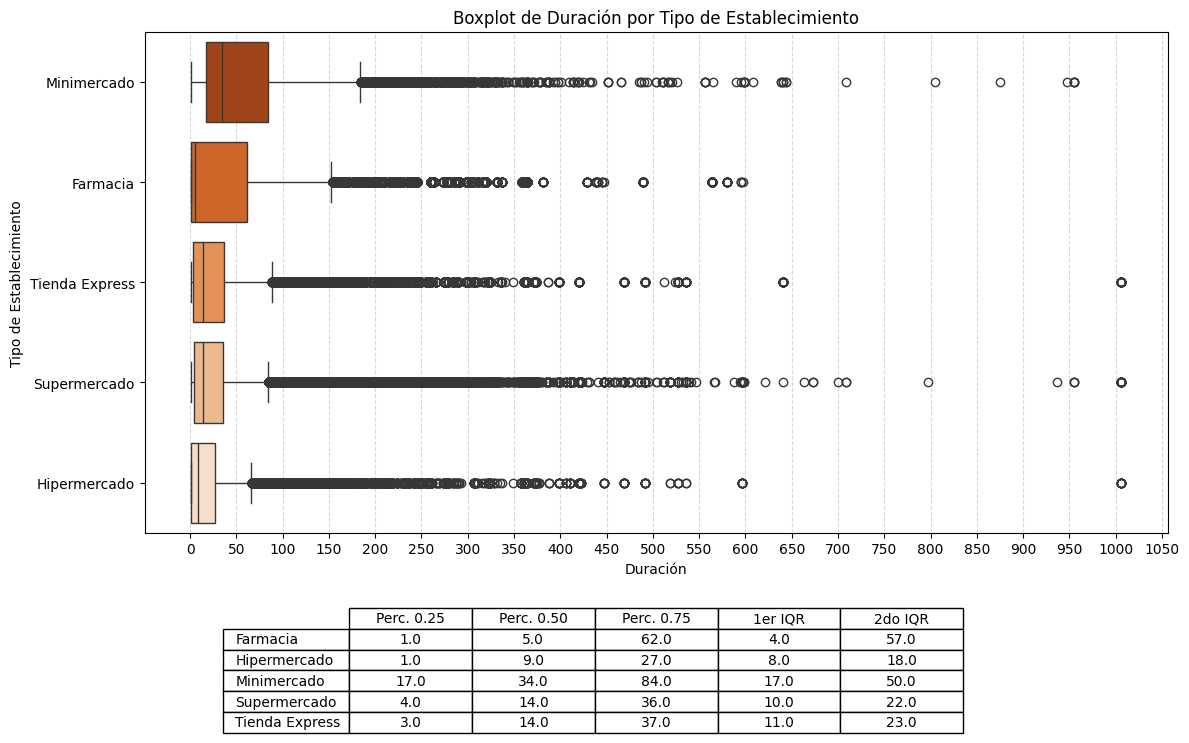

In [ ]:
## BOXPLOT POR TIPO DE ESTABLECIMIENTO (ordenado por media de la Duración en forma descendente) ##

# Calculamos percentiles y rangos intercuartílicos para cada tipo de establecimiento
percentiles_tipos = df_price_spell_ML.groupby('Tipo_establecimiento')['Duración'].quantile([0.25, 0.5, 0.75]).unstack()
percentiles_tipos.columns = ['Perc. 0.25', 'Perc. 0.50', 'Perc. 0.75']
percentiles_tipos['1er IQR'] = percentiles_tipos['Perc. 0.50'] - percentiles_tipos['Perc. 0.25']
percentiles_tipos['2do IQR'] = percentiles_tipos['Perc. 0.75'] - percentiles_tipos['Perc. 0.50']

# Ordenamos tipos de establecimiento según la media de 'Duración' en forma descendente
ordered_tipos = df_price_spell_ML.groupby('Tipo_establecimiento')['Duración'].mean().sort_values(ascending=False).index

# Configuramos el gráfico
plt.figure(figsize=(12, 8))
sns.boxplot(x='Duración', y='Tipo_establecimiento', data=df_price_spell_ML, palette='Oranges_r',
            order=ordered_tipos)  # Usamos la lista ordenada de tipos
plt.title('Boxplot de Duración por Tipo de Establecimiento')
plt.xlabel('Duración')  # Etiqueta del eje X
plt.ylabel('Tipo de Establecimiento')  # Etiqueta del eje Y

# Definimos los ticks en el eje X con intervalos de 50 hasta un máximo de 1050
ticks_50 = np.arange(0, 1051, 50)  # Intervalos de 50 hasta 1050
plt.xticks(ticks_50)  # Establecer los ticks en el eje X

# Agregamos grid solo en el eje X, con transparencia
plt.grid(axis='x', linestyle='--', color='gray', alpha=0.3)

# Agregamos tabla con percentiles y rangos intercuartílicos
plt.table(cellText=percentiles_tipos.values,
          colLabels=percentiles_tipos.columns,
          rowLabels=percentiles_tipos.index,
          cellLoc='center',
          loc='bottom',
          bbox=[0.2, -0.4, 0.6, 0.25])  # Ajusta la posición y tamaño de la tabla

plt.tight_layout()
plt.show()


#### **2.6**  **Frecuencialidad <ins>TEMPORAL</ins>** *(Día de la semana, Día del mes, Mes, Trimestre y Feriados)*

In [ ]:
## DÍA DE LA SEMANA ##

# Agrupamos el DataFrame por 'Día_de_la_semana' y calculamos las estadísticas
resumen_dia_semana = df_price_spell_ML.groupby(['Día_de_la_semana']).agg(
    Spells=('Intervalo', 'count'),  # Cuenta la cantidad de observaciones del campo Intervalo
    Duración_Media=('Duración', 'mean'),  # Calcula la media de la duración para cada día de la semana
    Duración_Mediana=('Duración', 'median'),  # Calcula la mediana de la duración
    Duración_Desvío=('Duración', 'std'),  # Calcula la desviación estándar de la duración
    Spells_Promoción=('Promoción', 'sum')  # Cuenta los spells en promoción (donde Promoción = 1)
).reset_index()

# Redondeamos las columnas de estadísticas a 2 decimales
resumen_dia_semana['Duración_Media'] = resumen_dia_semana['Duración_Media'].round(2)
resumen_dia_semana['Duración_Mediana'] = resumen_dia_semana['Duración_Mediana'].round(2)
resumen_dia_semana['Duración_Desvío'] = resumen_dia_semana['Duración_Desvío'].round(2)

# Calculamos el porcentaje de Spells en promoción sobre el total de Spells de cada Día_de_la_semana
resumen_dia_semana['%_Spells_Promoción'] = (resumen_dia_semana['Spells_Promoción'] / resumen_dia_semana['Spells'] * 100).round(2)

# Calculamos el porcentaje de Spells sobre el total de observaciones (total general)
total_observaciones = len(df_price_spell_ML)  # Total de observaciones (Spells)
resumen_dia_semana['%_Spells'] = (resumen_dia_semana['Spells'] / total_observaciones * 100).round(2)

# Reordenamos las columnas
resumen_dia_semana = resumen_dia_semana[['Día_de_la_semana', 'Spells', '%_Spells', 'Spells_Promoción', '%_Spells_Promoción',
                                         'Duración_Media', 'Duración_Mediana', 'Duración_Desvío']]

# Calculamos la media total de la columna 'Duración'
media_duracion_total = df_price_spell_ML['Duración'].mean().round(2)

# Creamos la fila de totales
fila_total = pd.DataFrame({
    'Día_de_la_semana': ['Total'],
    'Spells': [total_observaciones],
    '%_Spells': [100],
    'Spells_Promoción': [df_price_spell_ML['Promoción'].sum()],
    '%_Spells_Promoción': [100],
    'Duración_Media': [media_duracion_total],
    'Duración_Mediana': [round(df_price_spell_ML['Duración'].median(), 2)],
    'Duración_Desvío': [round(df_price_spell_ML['Duración'].std(), 2)]
})

# Ordenamos el DataFrame por 'Spells' en orden descendente y añadimos la fila de "Total" al final
resumen_dia_semana = pd.concat([resumen_dia_semana.sort_values(by='Spells', ascending=False), fila_total], ignore_index=True)

# Visualizamos la tabla final
resumen_dia_semana


Día_de_la_semana  Spells  %_Spells  Spells_Promoción  %_Spells_Promoción  \
0           Monday   65658     21.81             17065               25.99   
1        Wednesday   58902     19.57             18044               30.63   
2          Tuesday   51037     16.95             13993               27.42   
3         Thursday   41571     13.81             12132               29.18   
4           Friday   40536     13.47             14948               36.88   
5         Saturday   33210     11.03              8003               24.10   
6           Sunday   10112      3.36              1319               13.04   
7            Total  301026    100.00             85504              100.00   

   Duración_Media  Duración_Mediana  Duración_Desvío  
0           41.81              16.0            65.54  
1           42.04              19.0            63.66  
2           40.67              13.0            70.41  
3           37.29              14.0            70.18  
4           33.06               6.0            59.91  
5           34.80              11.0            57.02  
6           34.26               4.0            67.46  
7           38.83              14.0            65.25

In [ ]:
# DÍA DEL MES

# Agrupamos el DataFrame por 'Día_del_mes' y calculamos la cantidad de Spells y la media de Duración
resumen_dia_mes = df_price_spell_ML.groupby(['Día_del_mes']).agg(
    Spells=('Intervalo', 'count'),  # Cuenta la cantidad de observaciones del campo Intervalo
    Duración_Media=('Duración', 'mean')  # Cuenta la media de la duración para cada día del mes
).reset_index()

# Redondeamos la columna 'Duración_Media' a 2 decimales
resumen_dia_mes['Duración_Media'] = resumen_dia_mes['Duración_Media'].round(2)

# Calculamos el porcentaje de Spells
total_observaciones = len(df_price_spell_ML)  # Total de observaciones (Spells)
resumen_dia_mes['%_Spells'] = (resumen_dia_mes['Spells'] / total_observaciones * 100).round(2)

# Ordenamos el DataFrame por '%_Spells' en orden descendente
resumen_dia_mes = resumen_dia_mes.sort_values(by='%_Spells', ascending=False)

# Calculamos el acumulado de '%_Spells'
resumen_dia_mes['%_Spells_Acum'] = resumen_dia_mes['%_Spells'].cumsum().round(2)

# Reordenamos las columnas
resumen_dia_mes = resumen_dia_mes[['Día_del_mes', 'Spells', '%_Spells', '%_Spells_Acum', 'Duración_Media']]

# Calculamos la media total de la columna 'Duración'
media_duracion_total = df_price_spell_ML['Duración'].mean().round(2)

# Creamos la fila de totales
fila_total = pd.DataFrame({
    'Día_del_mes': ['Total'],
    'Spells': [total_observaciones],
    '%_Spells': [100],
    '%_Spells_Acum': [100],
    'Duración_Media': [media_duracion_total]
})

# Añadimos la fila total al final del DataFrame
resumen_dia_mes = pd.concat([resumen_dia_mes, fila_total], ignore_index=True)

# Visualizamos la tabla final
resumen_dia_mes

Día_del_mes  Spells  %_Spells  %_Spells_Acum  Duración_Media
0            2   23240      7.72           7.72           25.31
1            1   21361      7.10          14.82           48.33
2            3   16770      5.57          20.39           63.42
3            4   10574      3.51          23.90           38.66
4           22   10565      3.51          27.41           40.29
5           15   10035      3.33          30.74           34.13
6           27    9500      3.16          33.90           31.47
7           29    9446      3.14          37.04           41.65
8           18    9374      3.11          40.15           43.48
9            5    9346      3.10          43.25           38.66
10          24    9285      3.08          46.33           35.13
11          28    9038      3.00          49.33           39.55
12          13    8990      2.99          52.32           38.23
13           8    8975      2.98          55.30           38.51
14          17    8985      2.98          58.28           49.92
15          16    8823      2.93          61.21           39.40
16          21    8730      2.90          64.11           31.95
17          30    8696      2.89          67.00           35.36
18          14    8372      2.78          69.78           42.22
19          12    8188      2.72          72.50           35.66
20           6    8168      2.71          75.21           42.91
21          26    8045      2.67          77.88           31.40
22          11    7926      2.63          80.51           31.96
23          10    7683      2.55          83.06           29.76
24          25    7631      2.53          85.59           32.48
25          23    7541      2.51          88.10           36.85
26           7    7435      2.47          90.57           31.85
27          19    7364      2.45          93.02           43.38
28           9    7246      2.41          95.43           41.16
29          20    7227      2.40          97.83           35.88
30          31    6467      2.15          99.98           37.38
31       Total  301026    100.00         100.00           38.83

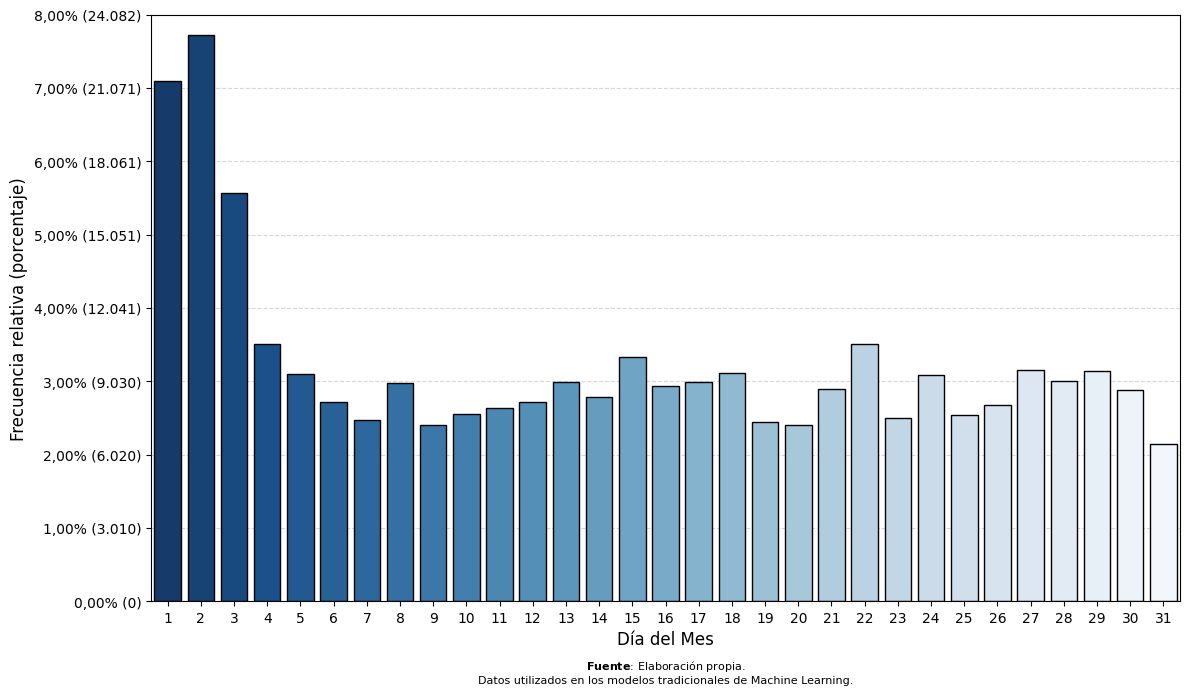

/content/Spells por Dia del Mes - Eje Y en Porcentaje..png

In [ ]:
## CANTIDAD DE SPELLS POR DÍA DEL MES ##

# Filtramos el DataFrame para excluir la fila de 'Total'
resumen_filtrado = resumen_dia_mes[resumen_dia_mes['Día_del_mes'] != 'Total'].copy()

# Convertimos 'Día_del_mes' a tipo entero
resumen_filtrado['Día_del_mes'] = resumen_filtrado['Día_del_mes'].astype(int)

# Calculamos el total de Spells para obtener proporciones
total_spells = resumen_filtrado['Spells'].sum()
resumen_filtrado['Porcentaje'] = resumen_filtrado['Spells'] / total_spells

# Creamos el gráfico de barras
plt.figure(figsize=(12, 7))
ax = sns.barplot(x='Día_del_mes', y='Porcentaje', data=resumen_filtrado, palette='Blues_r', edgecolor='black')

# Aseguramos que las gridlines queden detrás de las barras
ax.set_axisbelow(True)

# Agregamos gridlines horizontales de tipo "--" con alpha = 0.5
ax.grid(True, linestyle='--', axis='y', alpha=0.5)

# Establecemos el límite del eje Y de 0% a 8%
ax.set_ylim(0, 0.08)

# Definimos los ticks del eje Y cada 1%
yticks = [i / 100 for i in range(0, 9)]  # De 0.00 a 0.08
ax.set_yticks(yticks)

# Etiquetas personalizadas: porcentaje con coma y valor absoluto con puntos
ylabels = []
for y in yticks:
    porcentaje = f"{y*100:.2f}".replace('.', ',')  # % con coma
    valor_abs = int(y * total_spells)
    valor_abs_formateado = f'{valor_abs:,}'.replace(',', '.')  # valor con punto como separador de miles
    etiqueta = f"{porcentaje}% ({valor_abs_formateado})"
    ylabels.append(etiqueta)

# Asignamos etiquetas personalizadas
ax.set_yticklabels(ylabels)

# Asignamos etiquetas al eje X sin inclinación
plt.xticks(rotation=0)

# Añadimos etiquetas de los ejes
plt.xlabel('Día del Mes', fontsize=12)
plt.ylabel('Frecuencia relativa (porcentaje)', fontsize=12)

# Agregamos leyenda/disclaimer
plt.text(0.5, -0.12,
         r'$\bf{Fuente}$: Elaboración propia.' + '\nDatos utilizados en los modelos tradicionales de Machine Learning.',
         ha='center', va='center', transform=plt.gca().transAxes, fontsize=8)

plt.tight_layout()

# Guardamos la imagen localmente en el directorio actual
filename = "Spells por Dia del Mes - Eje Y en Porcentaje..png"
plt.savefig(filename, dpi=300, bbox_inches='tight')

# Mostramos
plt.show()

# Creamos un enlace de descarga (queda guardado en entorno)
display(FileLink(filename))


In [ ]:
## MES ##

# 1. Agrupamos el DataFrame por 'Mes' y calculamos la cantidad de Spells, la media y la mediana de Duración
resumen_mes = df_price_spell_ML.groupby(['Mes']).agg(
    Spells=('Intervalo', 'count'),  # Cuenta la cantidad de observaciones del campo Intervalo
    Duración_Media=('Duración', 'mean'),  # Calcula la media de la duración para cada mes
    Duración_Mediana=('Duración', 'median')  # Calcula la mediana de la duración para cada mes
).reset_index()

# 2. Redondeamos las columnas 'Duración_Media' y 'Duración_Mediana' a 2 decimales
resumen_mes[['Duración_Media', 'Duración_Mediana']] = resumen_mes[['Duración_Media', 'Duración_Mediana']].round(2)

# 3. Calculamos el porcentaje de Spells
total_observaciones = len(df_price_spell_ML)  # Total de observaciones (Spells)
resumen_mes['%_Spells'] = (resumen_mes['Spells'] / total_observaciones * 100).round(2)

# 4. Reordenamos las columnas
resumen_mes = resumen_mes[['Mes', 'Spells', '%_Spells', 'Duración_Media', 'Duración_Mediana']]

# 5. Calculamos la media y la mediana total de la columna 'Duración'
media_duracion_total = round(df_price_spell_ML['Duración'].mean(), 2)
mediana_duracion_total = round(df_price_spell_ML['Duración'].median(), 2)

# 6. Creamos la fila de totales
fila_total = pd.DataFrame({
    'Mes': ['Total'],
    'Spells': [total_observaciones],
    '%_Spells': [100],
    'Duración_Media': [media_duracion_total],
    'Duración_Mediana': [mediana_duracion_total]
})

# 7. Ordenamos el DataFrame por 'Spells' en orden descendente y añadimos la fila de "Total" al final
resumen_mes = pd.concat([resumen_mes.sort_values(by='Spells', ascending=False), fila_total], ignore_index=True)

# Visualización de la tabla final
resumen_mes


Mes  Spells  %_Spells  Duración_Media  Duración_Mediana
0       1   41381     13.75           42.08              15.0
1       3   34021     11.30           44.40              17.0
2       4   30636     10.18           44.25              14.0
3       5   26914      8.94           31.72              14.0
4       2   25455      8.46           36.17              13.0
5       8   23465      7.80           45.93              17.0
6       6   22244      7.39           40.46              13.0
7       9   21355      7.09           35.16              14.0
8       7   21335      7.09           37.59              12.0
9      10   21099      7.01           34.00              13.0
10     11   18580      6.17           36.62              16.0
11     12   14541      4.83           26.11              11.0
12  Total  301026    100.00           38.83              14.0

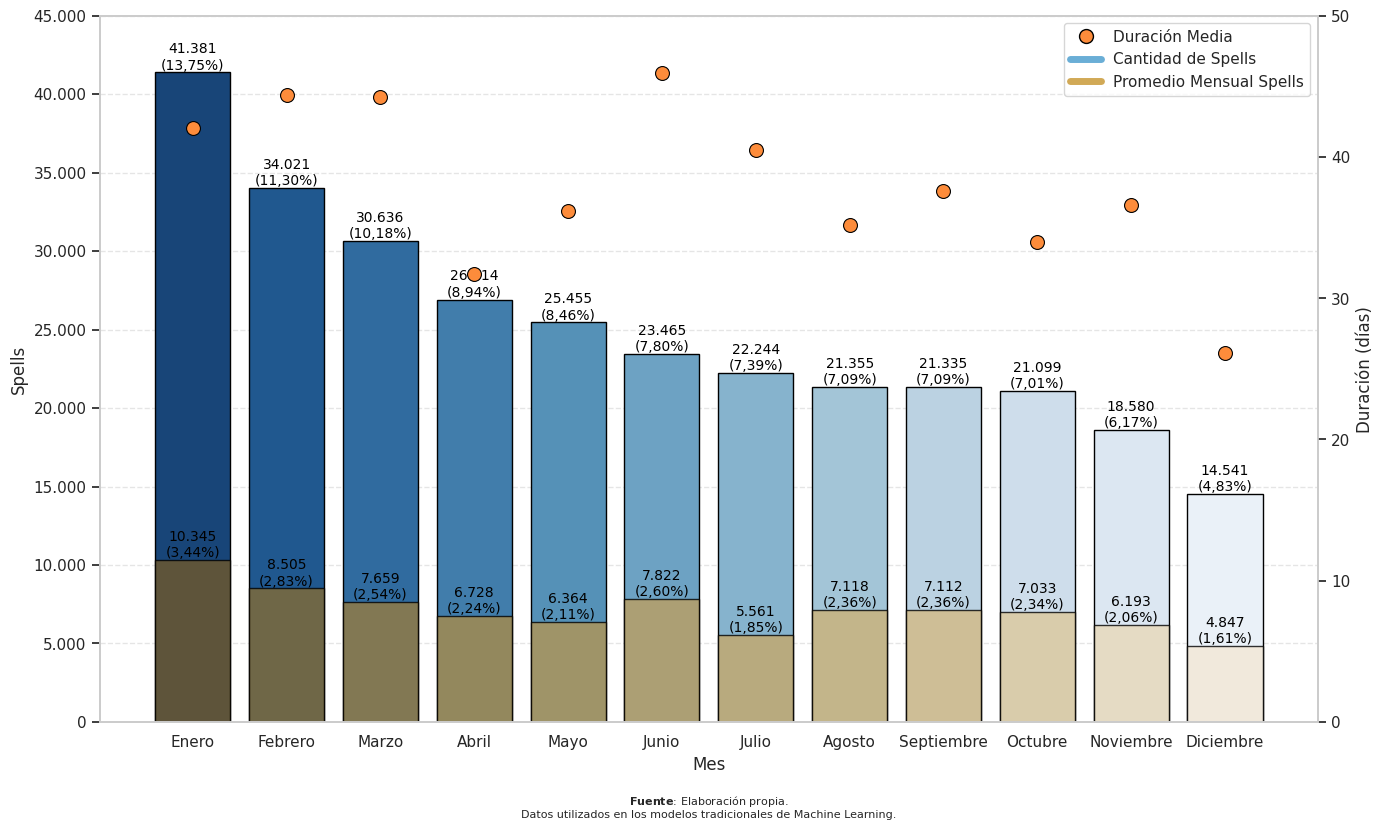

/content/Spells y Duracion Media por Mes.png

In [ ]:
## CANTIDAD DE SPELLS Y DURACIÓN MEDIA POR MES ##

# Convertimos la columna 'Mes' a tipo numérico (si no se ha hecho)
resumen_mes['Mes'] = pd.to_numeric(resumen_mes['Mes'], errors='coerce')

# Filtramos solo los meses del 1 al 12 (sin Total)
resumen_mes_filtrado = resumen_mes[resumen_mes['Mes'] <= 12].reset_index(drop=True)

# Calculamos el promedio de Spells por mes según el criterio indicado
resumen_mes_filtrado['Promedio_Spells'] = resumen_mes_filtrado.apply(
    lambda row: row['Spells'] / 4 if row['Mes'] <= 6 else row['Spells'] / 3, axis=1
)

# Función personalizada para formato con punto como separador de miles y coma como separador de decimales
def format_miles(valor, _):
    return f'{int(valor):,}'.replace(',', '.')

def format_porcentaje(valor):
    return f'{valor:.2f}'.replace('.', ',')

# Generamos colores dorados en orden inverso (más oscuro al más claro)
colores_dorados = cmap_dorados_muy_suave(np.linspace(1, 0, len(resumen_mes_filtrado)))

# Configuración de estilo
sns.set(style="whitegrid")

# Tamaño de la figura
fig, ax1 = plt.subplots(figsize=(14, 8))

# Crear gráfico de barras para cantidad de Spells
bar_plot = sns.barplot(
    data=resumen_mes_filtrado, x=resumen_mes_filtrado.index, y='Spells',
    palette='Blues_r', edgecolor='black', ax=ax1, label='Cantidad de Spells'
)

# Superponer barras para Promedio de Spells con colores dorados y ancho más delgado
bar_plot_avg = sns.barplot(
    data=resumen_mes_filtrado, x=resumen_mes_filtrado.index, y='Promedio_Spells',
    palette=colores_dorados, edgecolor='black', alpha=0.8, ax=ax1, label='Promedio Mensual Spells'
)

# Crear segundo eje Y
ax2 = ax1.twinx()

# Graficar solo la Duración Media con bordes negros en los puntos naranja (sin leyenda automática)
scatter_media = sns.scatterplot(
    data=resumen_mes_filtrado, x=resumen_mes_filtrado.index, y='Duración_Media',
    color=cm.Oranges(0.5), edgecolor='black', s=100, zorder=2, ax=ax2, legend=False  # Cambiar zorder para evitar superposición
)

# Configurar límites y formato de ejes
ax1.set_ylim(0, 45000)  # Límite del eje Y para Spells
ax2.set_ylim(0, 50)  # Límite del eje Y para Duración (días)

# Configurar etiquetas de los ejes
meses_nombres = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
                 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
ax1.set_xticks(resumen_mes_filtrado.index)
ax1.set_xticklabels(meses_nombres, rotation=0)
ax1.set_xlabel("Mes", fontsize=12)
ax1.set_ylabel("Spells", fontsize=12)
ax2.set_ylabel("Duración (días)", fontsize=12)

# Formatear el eje Y de "Spells" con puntos como separador de miles
ax1.yaxis.set_major_formatter(plt.FuncFormatter(format_miles))

# Configurar gridlines horizontales
ax1.grid(True, linestyle='--', axis='y', alpha=0.5)
ax1.set_axisbelow(True)  # Asegurar que las gridlines queden detrás de las barras
ax2.grid(False)  # Desactivar gridlines en el eje secundario

# Agregar anotaciones en las barras de "Spells" con valores enteros y porcentaje ajustado
for p in bar_plot.patches:  # Iterar sobre las barras de "Spells"
    absolute_value = round(p.get_height())  # Redondear a entero
    percentage = (absolute_value / total_spells) * 100  # Calcular el porcentaje
    text = f"{format_miles(absolute_value, None)}\n({format_porcentaje(percentage)}%)"  # Formato ajustado
    ax1.annotate(text,
                 (p.get_x() + p.get_width() / 2., p.get_height() + 10),  # Ajustar altura para evitar superposición
                 ha='center', va='bottom', fontsize=10, color='black')

# Configurar leyendas personalizadas
legend_elements = [
    Line2D([0], [0], marker='o', color=cm.Oranges(0.5), markersize=10, markeredgecolor='black', label='Duración Media', linestyle=''),
    Line2D([0], [0], color=cm.Blues(0.5), lw=5, label='Cantidad de Spells'),  # Barra azul
    Line2D([0], [0], color=cmap_dorados_muy_suave(0.5), lw=5, label='Promedio Mensual Spells')  # Barra dorada más clara
]

# Agregar la leyenda al gráfico
ax1.legend(handles=legend_elements, loc='upper right', title=None)  # Eliminar título de la leyenda

# Ajustar diseño
plt.tight_layout()

# Agregar leyenda/disclaimer
plt.text(0.5, -0.12,
         r'$\bf{Fuente}$: Elaboración propia.' + '\nDatos utilizados en los modelos tradicionales de Machine Learning.',
         ha='center', va='center', transform=plt.gca().transAxes, fontsize=8)

# Guardamos la imagen localmente en el directorio actual
filename = "Spells y Duracion Media por Mes.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')

# Mostramos
plt.show()

# Creamos un enlace de descarga (queda guardado en entorno)
display(FileLink(filename))


In [ ]:
## TRIMESTRE ##

# 1. Agrupamos el DataFrame por 'Trimestre' y calculamos la cantidad de Spells y la media de Duración
resumen_trimestre = df_price_spell_ML.groupby(['Trimestre']).agg(
    Spells=('Intervalo', 'count'),  # Cuenta la cantidad de observaciones del campo Intervalo
    Duración_Media=('Duración', 'mean')  # Calcula la media de la duración para cada trimestre
).reset_index()

# 2. Redondeamos la columna 'Duración_Media' a 2 decimales
resumen_trimestre['Duración_Media'] = resumen_trimestre['Duración_Media'].round(2)

# 3. Calculamos el porcentaje de Spells
total_observaciones = len(df_price_spell_ML)  # Total de observaciones (Spells)
resumen_trimestre['%_Spells'] = (resumen_trimestre['Spells'] / total_observaciones * 100).round(2)

# 4. Reordenamos las columnas
resumen_trimestre = resumen_trimestre[['Trimestre', 'Spells', '%_Spells', 'Duración_Media']]

# 5. Calculamos la media total de la columna 'Duración'
media_duracion_total = df_price_spell_ML['Duración'].mean().round(2)

# 6. Creamos la fila de totales
fila_total = pd.DataFrame({
    'Trimestre': ['Total'],
    'Spells': [total_observaciones],
    '%_Spells': [100],
    'Duración_Media': [media_duracion_total]
})

# 7. Ordenamos el DataFrame por 'Spells' en orden descendente y añadimos la fila de "Total" al final
resumen_trimestre = pd.concat([resumen_trimestre.sort_values(by='Spells', ascending=False), fila_total], ignore_index=True)

# Visualizamos la tabla final
resumen_trimestre

Trimestre  Spells  %_Spells  Duración_Media
0        Q1  100857     33.50           41.37
1        Q2   79794     26.51           38.96
2        Q3   66155     21.98           39.77
3        Q4   54220     18.01           32.78
4     Total  301026    100.00           38.83

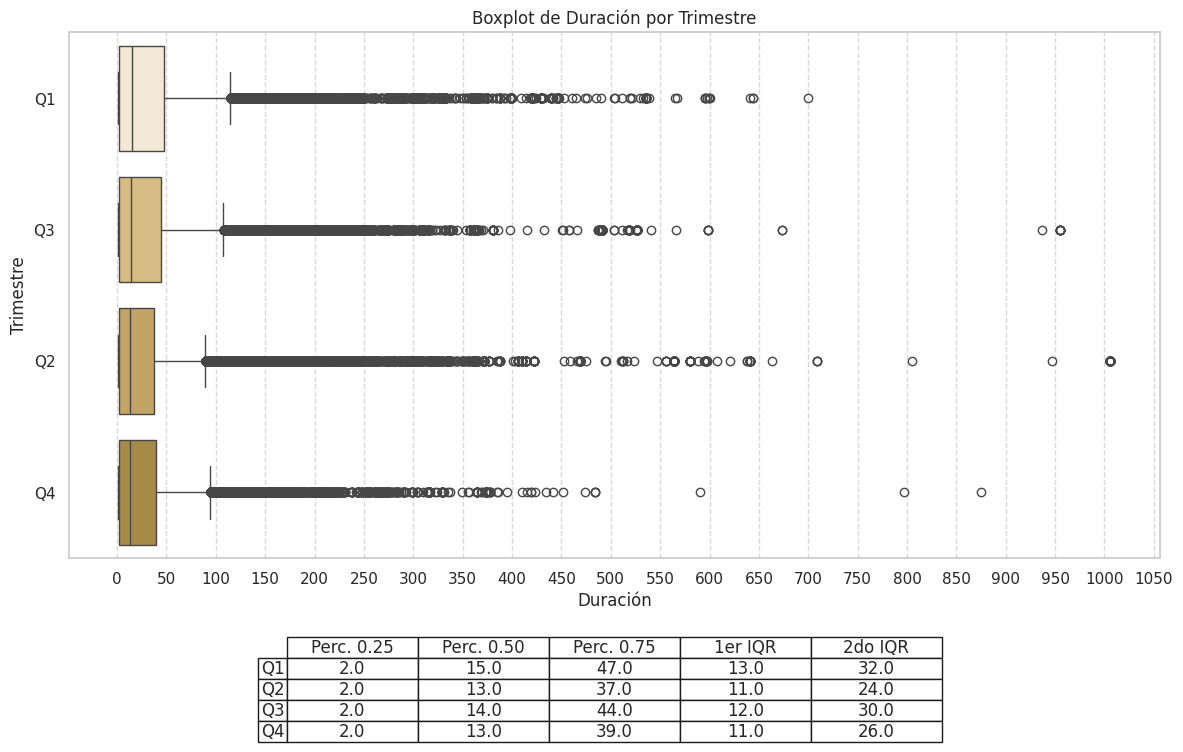

In [ ]:
## BOXPLOT POR TRIMESTRE (ordenado por la media de la Duración en forma descendente) ##

# Calculamos percentiles y rangos intercuartílicos para cada trimestre
percentiles = df_price_spell_ML.groupby('Trimestre')['Duración'].quantile([0.25, 0.5, 0.75]).unstack()
percentiles.columns = ['Perc. 0.25', 'Perc. 0.50', 'Perc. 0.75']
percentiles['1er IQR'] = percentiles['Perc. 0.50'] - percentiles['Perc. 0.25']
percentiles['2do IQR'] = percentiles['Perc. 0.75'] - percentiles['Perc. 0.50']

# Ordenamos trimestres según la media de 'Duración' en forma descendente
ordered_trimestres = df_price_spell_ML.groupby('Trimestre')['Duración'].mean().sort_values(ascending=False).index

# Configuramos el gráfico
plt.figure(figsize=(12, 8))
sns.boxplot(x='Duración', y='Trimestre', data=df_price_spell_ML, palette=colors_dorados_muy_suave,
            order=ordered_trimestres)  # Usamos la lista ordenada de trimestres
plt.title('Boxplot de Duración por Trimestre')
plt.xlabel('Duración')  # Etiqueta del eje X
plt.ylabel('Trimestre')  # Etiqueta del eje Y

# Definimos los ticks en el eje X con intervalos de 50 hasta un máximo de 1050
ticks_50 = np.arange(0, 1051, 50)  # Intervalos de 50 hasta 1050
plt.xticks(ticks_50)  # Establecer los ticks en el eje X

# Agregamos grid solo en el eje X, con transparencia
plt.grid(axis='x', linestyle='--', color='gray', alpha=0.3)

# Agregamos tabla con percentiles y rangos intercuartílicos
plt.table(cellText=percentiles.values,
          colLabels=percentiles.columns,
          rowLabels=percentiles.index,
          cellLoc='center',
          loc='bottom',
          bbox=[0.2, -0.35, 0.6, 0.2])  # Ajusta la posición y tamaño de la tabla

plt.tight_layout()
plt.show()

In [ ]:
## FERIADOS ##

# 1. Agrupamos el DataFrame por 'Feriado' y calculamos la cantidad de Spells
resumen_feriado = df_price_spell_ML.groupby('Feriado').agg(
    Spells=('Intervalo', 'count')  # Cuenta la cantidad de observaciones del campo Intervalo
).reset_index()

# 2. Calculamos el porcentaje de Spells
total_spells = df_price_spell_ML['Intervalo'].count()  # Total de Spells
resumen_feriado['%_Spells'] = (resumen_feriado['Spells'] / total_spells * 100).round(2)

# 3. Reordenamos las columnas
resumen_feriado = resumen_feriado[['Feriado', 'Spells', '%_Spells']]

# 4. Visualizamos la tabla final
resumen_feriado

Feriado  Spells  %_Spells
0        0  289723     96.25
1        1   11303      3.75

#### **2.7**  **Frecuencialidad <ins>PROMOCIÓN</ins>**

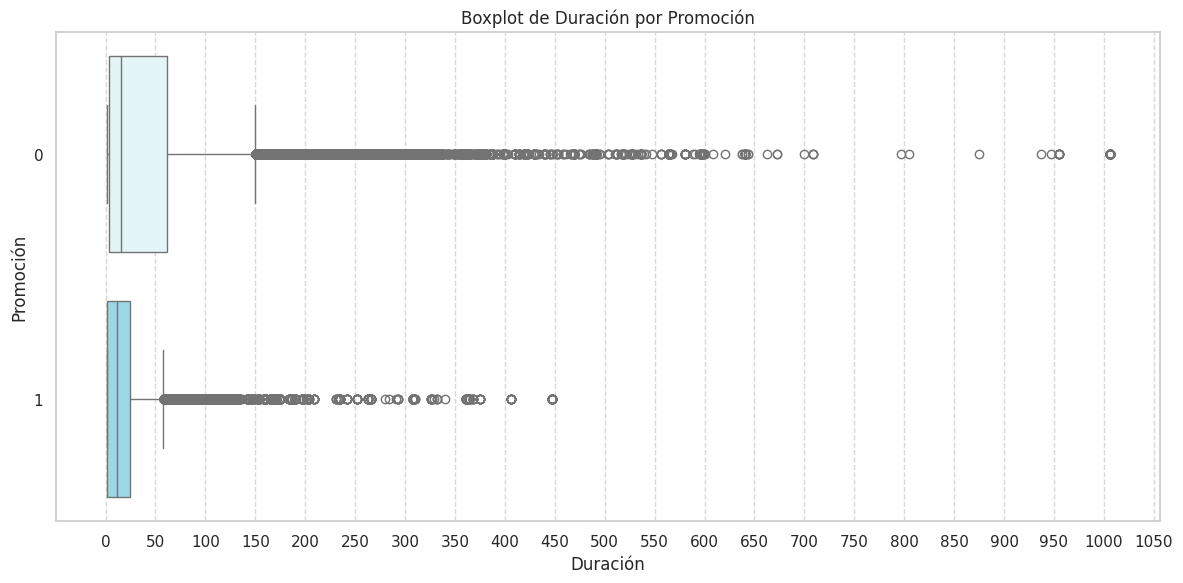

In [ ]:
## BOXPLOT POR PROMOCIÓN ##

# Aseguramos que la variable Promoción es tratada como categórica
df_price_spell_ML['Promoción'] = df_price_spell_ML['Promoción'].astype('category')

# Creamos el boxplot con las dos cajas separadas para Promoción
plt.figure(figsize=(12, 6))
sns.boxplot(x='Duración', y='Promoción', data=df_price_spell_ML, palette=colors_celestes_muy_suave)
plt.title('Boxplot de Duración por Promoción')
plt.xlabel('Duración')  # Etiqueta del eje X
plt.ylabel('Promoción')  # Etiqueta del eje Y

# Definimos ticks en el eje X (para Duración)
ticks_50 = np.arange(0, 1051, 50)  # Intervalos de 50 hasta 1050
plt.xticks(ticks_50)  # Establecer los ticks en el eje X

# Agregamos grid solo en el eje X, con transparencia
plt.grid(axis='x', linestyle='--', color='gray', alpha=0.3)

plt.tight_layout()
plt.show()


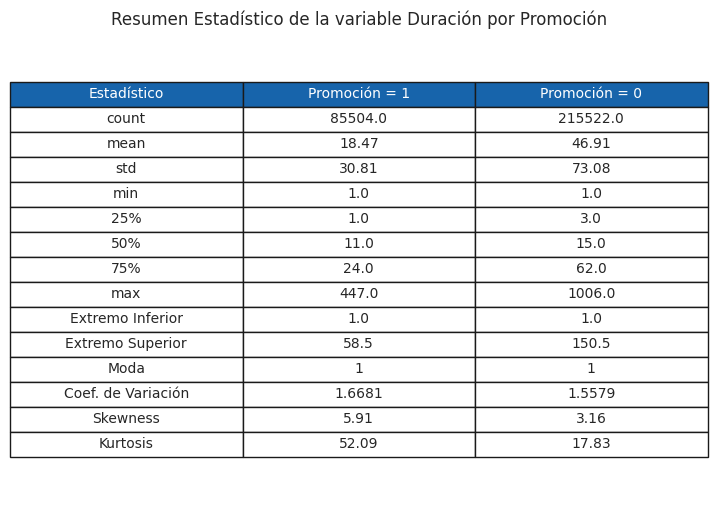

In [ ]:
## ESTADÍSTICOS ##

# Aseguramos que la variable 'Promoción' sea categórica
df_price_spell_ML['Promoción'] = df_price_spell_ML['Promoción'].astype('category')

# Filtramos observaciones según promoción
promocion_1 = df_price_spell_ML[df_price_spell_ML['Promoción'] == 1]['Duración']
promocion_0 = df_price_spell_ML[df_price_spell_ML['Promoción'] == 0]['Duración']

# Estadísticos básicos
summary_stats_1 = promocion_1.describe().round(2)
summary_stats_0 = promocion_0.describe().round(2)

# IQR
iqr_1 = summary_stats_1['75%'] - summary_stats_1['25%']
iqr_0 = summary_stats_0['75%'] - summary_stats_0['25%']

# Bigotes del boxplot
lower_whisker_1 = max(summary_stats_1['min'], summary_stats_1['25%'] - 1.5 * iqr_1)
upper_whisker_1 = min(summary_stats_1['max'], summary_stats_1['75%'] + 1.5 * iqr_1)

lower_whisker_0 = max(summary_stats_0['min'], summary_stats_0['25%'] - 1.5 * iqr_0)
upper_whisker_0 = min(summary_stats_0['max'], summary_stats_0['75%'] + 1.5 * iqr_0)

# Agregamos bigotes al resumen
summary_stats_1['Extremo Inferior'] = round(lower_whisker_1, 2)
summary_stats_1['Extremo Superior'] = round(upper_whisker_1, 2)
summary_stats_0['Extremo Inferior'] = round(lower_whisker_0, 2)
summary_stats_0['Extremo Superior'] = round(upper_whisker_0, 2)

# Moda
mode_1 = promocion_1.mode().tolist()
mode_0 = promocion_0.mode().tolist()
mode_1_str = ', '.join([str(round(val, 2)) for val in mode_1]) if mode_1 else 'N/A'
mode_0_str = ', '.join([str(round(val, 2)) for val in mode_0]) if mode_0 else 'N/A'

# Skewness y Kurtosis
skewness_1 = round(skew(promocion_1), 2)
kurtosis_1 = round(kurtosis(promocion_1), 2)
skewness_0 = round(skew(promocion_0), 2)
kurtosis_0 = round(kurtosis(promocion_0), 2)

# Coeficiente de variación
cv_1 = round(summary_stats_1['std'] / summary_stats_1['mean'], 4)
cv_0 = round(summary_stats_0['std'] / summary_stats_0['mean'], 4)

# Creamos DataFrame resumen
df_summary = pd.DataFrame({
    'Estadístico': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max',
                    'Extremo Inferior', 'Extremo Superior', 'Moda',
                    'Coef. de Variación', 'Skewness', 'Kurtosis'],
    'Promoción = 1': [summary_stats_1['count'], summary_stats_1['mean'], summary_stats_1['std'],
                      summary_stats_1['min'], summary_stats_1['25%'], summary_stats_1['50%'],
                      summary_stats_1['75%'], summary_stats_1['max'],
                      summary_stats_1['Extremo Inferior'], summary_stats_1['Extremo Superior'],
                      mode_1_str, cv_1, skewness_1, kurtosis_1],
    'Promoción = 0': [summary_stats_0['count'], summary_stats_0['mean'], summary_stats_0['std'],
                      summary_stats_0['min'], summary_stats_0['25%'], summary_stats_0['50%'],
                      summary_stats_0['75%'], summary_stats_0['max'],
                      summary_stats_0['Extremo Inferior'], summary_stats_0['Extremo Superior'],
                      mode_0_str, cv_0, skewness_0, kurtosis_0]
})

# Gráfico: tabla con Matplotlib
fig, ax = plt.subplots(figsize=(9, 6))
ax.axis('tight')
ax.axis('off')

# Creamos la tabla
tabla = ax.table(cellText=df_summary.values,
                 colLabels=df_summary.columns,
                 cellLoc='center',
                 loc='center')

tabla.scale(1, 1.5)
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)

# Color de cabecera
header_color = plt.cm.Blues(0.8)
for i in range(len(df_summary.columns)):
    tabla[0, i].set_facecolor(header_color)
    tabla[0, i].set_text_props(color='white')

plt.title('Resumen Estadístico de la variable Duración por Promoción', pad=10)
plt.show()


#### **2.8**  **Frecuencialidad <ins>Municipio</ins>**

In [ ]:

# Agrupamos el DataFrame por 'Municipio' y calculamos las métricas requeridas
resumen_municipio = df_price_spell_ML.groupby('Municipio').agg(
    Spells=('Intervalo', 'count'),  # Cantidad de Spells
    Promoción=('Promoción', lambda x: (x == 1).sum()),  # Cantidad de Spells en Promoción
    Duración_Media=('Duración', 'mean'),  # Media de la duración
    Mediana=('Duración', 'median'),  # Mediana de la duración
    Desviación_estándar=('Duración', 'std'),  # Desviación estándar de la duración
    Establecimientos=('ID_establecimiento', 'nunique'),  # Cantidad de establecimientos
    Productos_informados=('ID_producto', 'nunique')  # Cantidad de productos informados
).reset_index()

# Calculamos combinaciones únicas por municipio
combinaciones_unicas = df_price_spell_ML[['Municipio', 'ID_establecimiento', 'ID_producto']].drop_duplicates()
combinaciones_count = combinaciones_unicas.groupby(['Municipio']).size().reset_index(name='Combinaciones')

# Unimos la tabla de combinaciones únicas con el resumen de municipios
resumen_municipio = pd.merge(resumen_municipio, combinaciones_count, on=['Municipio'], how='left')

# Calculamos los totales
df_price_spell_ML['Promoción'] = pd.to_numeric(df_price_spell_ML['Promoción'], errors='coerce')
total_spells = df_price_spell_ML.shape[0]  # Total de Spells
total_promocion = df_price_spell_ML['Promoción'].sum()  # Total de spells en promoción
num_establecimientos = df_price_spell_ML['ID_establecimiento'].nunique()  # Total de establecimientos
num_productos = df_price_spell_ML['ID_producto'].nunique()  # Total de productos
num_combinaciones_unicas = combinaciones_unicas.shape[0]  # Total de combinaciones

# Calculamos los porcentajes
resumen_municipio['%_Spells'] = (resumen_municipio['Spells'] / total_spells * 100).round(2)
resumen_municipio['%_Promoción'] = (resumen_municipio['Promoción'] / resumen_municipio['Spells'] * 100).round(2)
resumen_municipio['%_establecimientos'] = (resumen_municipio['Establecimientos'] / num_establecimientos * 100).round(2)
resumen_municipio['%_productos'] = (resumen_municipio['Productos_informados'] / num_productos * 100).round(2)

# Redondeamos las métricas de duración a 2 decimales
resumen_municipio['Duración_Media'] = resumen_municipio['Duración_Media'].round(2)
resumen_municipio['Mediana'] = resumen_municipio['Mediana'].round(2)
resumen_municipio['Desviación_estándar'] = resumen_municipio['Desviación_estándar'].round(2)

# Reordenamos las columnas
resumen_municipio = resumen_municipio[['Municipio', 'Spells', '%_Spells', 'Promoción', '%_Promoción',
                                       'Duración_Media', 'Mediana', 'Desviación_estándar',
                                       'Establecimientos', '%_establecimientos',
                                       'Productos_informados', '%_productos']]

# Ordenamos la tabla por 'Spells' en orden decreciente
resumen_municipio = resumen_municipio.sort_values(by='Spells', ascending=False)

# Creamos la fila de totales
fila_total = pd.DataFrame({
    'Municipio': ['Total'],
    'Spells': [total_spells],
    '%_Spells': [100.00],
    'Promoción': [total_promocion],
    '%_Promoción': [round(total_promocion / total_spells * 100, 2)],
    'Duración_Media': [round(df_price_spell_ML['Duración'].mean(), 2)],
    'Mediana': [round(df_price_spell_ML['Duración'].median(), 2)],
    'Desviación_estándar': [round(df_price_spell_ML['Duración'].std(), 2)],
    'Establecimientos': [num_establecimientos],
    '%_establecimientos': [100.00],
    'Productos_informados': [num_productos],
    '%_productos': [100.00]
})

# Concatenamos la fila total
resumen_municipio = pd.concat([resumen_municipio, fila_total], ignore_index=True)

# Visualizamos el DataFrame final
resumen_municipio


Municipio  Spells  %_Spells  Promoción  %_Promoción  Duración_Media  \
0  Municipio CH   76106     25.28      22829        30.00           36.99   
1   Municipio B   69422     23.06      23843        34.35           35.15   
2   Municipio F   39669     13.18       8264        20.83           42.17   
3   Municipio E   34039     11.31       9973        29.30           37.92   
4   Municipio C   27279      9.06       9751        35.75           32.46   
5   Municipio D   22472      7.47       5240        23.32           44.29   
6   Municipio A   16073      5.34       1677        10.43           49.14   
7   Municipio G   15966      5.30       3927        24.60           50.15   
8         Total  301026    100.00      85504        28.40           38.83   

   Mediana  Desviación_estándar  Establecimientos  %_establecimientos  \
0     10.0                66.64                81               28.03   
1     12.0                62.85                70               24.22   
2     19.0                63.37                32               11.07   
3     10.0                68.66                35               12.11   
4     10.0                61.14                19                6.57   
5     19.0                68.43                21                7.27   
6     28.0                62.24                14                4.84   
7     27.0                67.59                17                5.88   
8     14.0                65.25               289              100.00   

   Productos_informados  %_productos  
0                   149        99.33  
1                   150       100.00  
2                   150       100.00  
3                   143        95.33  
4                   149        99.33  
5                   150       100.00  
6                   145        96.67  
7                   149        99.33  
8                   150       100.00

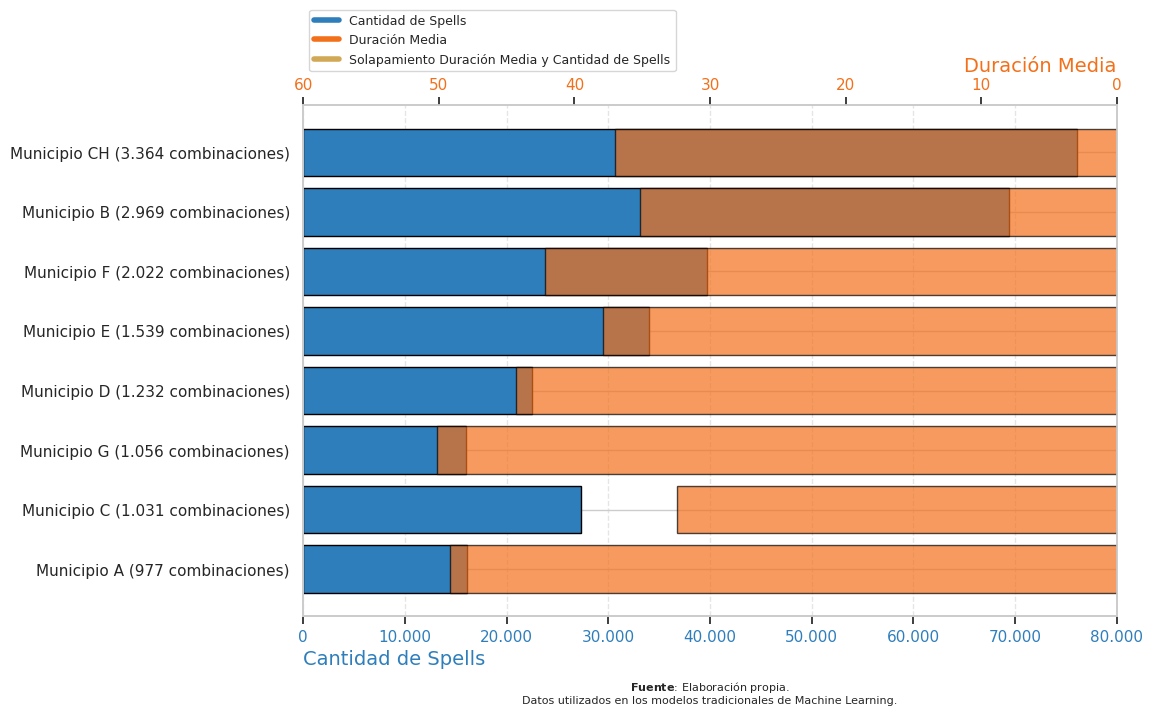

/content/Cantidad_spells_y_duracion_por_Municipio.png

In [ ]:
# CANTIDAD DE SPELLS Y DURACIÓN MEDIA POR MUNICIPIO #

# Calculamos combinaciones únicas por municipio
combinaciones_unicas = df_price_spell_ML[['Municipio', 'ID_establecimiento', 'ID_producto']].drop_duplicates()
combinaciones_count = combinaciones_unicas.groupby(['Municipio']).size().reset_index(name='Combinaciones')

# Unimos la tabla de combinaciones únicas con el resumen de municipios
resumen_municipio = pd.merge(resumen_municipio, combinaciones_count, on=['Municipio'], how='left')

# Filtramos y ordenamos los datos
resumen_municipio_filtrado = resumen_municipio[resumen_municipio['Municipio'] != 'Total']
resumen_municipio_filtrado = resumen_municipio_filtrado.sort_values(by='Combinaciones', ascending=True)

# Creamos etiquetas personalizadas para cada municipio con separador de miles
etiquetas_municipio = [
    f"{municipio} ({combinaciones:,.0f} combinaciones)".replace(",", ".")
    for municipio, combinaciones in zip(resumen_municipio_filtrado['Municipio'], resumen_municipio_filtrado['Combinaciones'])
]

# Tamaño de la figura
fig, ax1 = plt.subplots(figsize=(12, 8))

# Paletas de color
color_barras_spells = cm.Blues(0.7)
color_barras_duracion = cm.Oranges(0.6)
color_solape = cmap_dorados_muy_suave(0.5)  # Definido por el usuario

# Gráfico de barras horizontal para la cantidad de Spells (a la derecha)
ax1.barh(etiquetas_municipio, resumen_municipio_filtrado['Spells'],
         color=color_barras_spells, label='Cantidad de Spells', edgecolor='black')
ax1.set_xlabel('Cantidad de Spells', color=color_barras_spells, fontsize=14, ha='left', x=0)
ax1.tick_params(axis='x', labelcolor=color_barras_spells)
ax1.set_xlim(0, 80000)
ax1.set_xticks(range(0, 80001, 10000))
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.0f}'.format(x).replace(",", ".")))

# Segundo eje X invertido - Duración media (izquierda)
ax2 = ax1.twiny()
ax2.barh(etiquetas_municipio, resumen_municipio_filtrado['Duración_Media'],
         color=color_barras_duracion, label='Duración Media', alpha=0.7, edgecolor='black')
ax2.invert_xaxis()
ax2.set_xlabel('Duración Media', color=color_barras_duracion, fontsize=14, ha='right', x=1)
ax2.tick_params(axis='x', labelcolor=color_barras_duracion)
ax2.set_xlim(60, 0)
ax2.set_xticks(range(0, 61, 10))
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.0f}'.format(x).replace(",", ".")))

# Solape: cambiar colores
for i, duracion_media in enumerate(resumen_municipio_filtrado['Duración_Media']):
    if resumen_municipio_filtrado['Spells'].iloc[i] <= duracion_media:
        ax1.patches[i].set_color(color_solape)
        ax2.patches[i].set_color(color_solape)

# Aseguramos que las grillas estén detrás de las barras
ax1.set_axisbelow(True)
ax2.set_axisbelow(True)

# Cuadrícula del eje Y (solo verticales)
ax1.grid(True, axis='x', linestyle='--', alpha=0.5, zorder=0)
ax2.grid(False)  # Desactivar las gridlines del eje secundario (Duración Media)

# Aseguramos que todas las barras estén sobre la grilla
for patch in ax1.patches:
    patch.set_zorder(2)
for patch in ax2.patches:
    patch.set_zorder(2)

# Leyenda personalizada
custom_lines = [
    Line2D([0], [0], color=color_barras_spells, lw=4, label="Cantidad de Spells"),
    Line2D([0], [0], color=color_barras_duracion, lw=4, label="Duración Media"),
    Line2D([0], [0], color=color_solape, lw=4, label="Solapamiento Duración Media y Cantidad de Spells")
]
plt.legend(handles=custom_lines, loc="upper left", bbox_to_anchor=(0, 1.2), fontsize=9)

# Disclaimer
plt.text(0.5, -0.15,
         r'$\bf{Fuente}$: Elaboración propia.' + '\nDatos utilizados en los modelos tradicionales de Machine Learning.',
         ha='center', va='center', transform=plt.gca().transAxes, fontsize=8)

# Layout
fig.tight_layout(pad=2)

# Guardamos la imagen localmente en el directorio actual
filename = "Cantidad_spells_y_duracion_por_Municipio.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')

# Mostramos
plt.show()

# Creamos un enlace de descarga (queda guardado en entorno)
display(FileLink(filename))

# **3 <ins>Análisis variable a predecir:</ins>** ***DURACIÓN***

#### **3.1**  **Distribución<ins></ins>** (Histogramas de frecuencia)

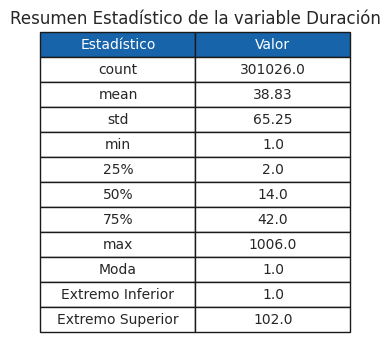

In [ ]:
## RESUMEN ESTADÍSTICO ##

# Generamos el resumen estadístico con describe() y redondeamos a 2 decimales
summary_stats = df_price_spell_ML['Duración'].describe().round(2)

# Calculamos la moda con Pandas
moda = df_price_spell_ML['Duración'].mode()

# En caso de que haya más de una moda, tomamos la primera
moda_valor = moda.iloc[0] if not moda.empty else None

# Agregamos al resumen (si hay moda)
if moda_valor is not None:
    summary_stats['Moda'] = round(moda_valor, 2)

# Calculamos IQR (Rango Intercuartílico)
iqr = summary_stats['75%'] - summary_stats['25%']

# Calculamos los límites de los bigotes del boxplot
lower_whisker = max(summary_stats['min'], summary_stats['25%'] - 1.5 * iqr)
upper_whisker = min(summary_stats['max'], summary_stats['75%'] + 1.5 * iqr)

# Agregamos los bigotes al resumen estadístico
summary_stats['Extremo Inferior'] = round(lower_whisker, 2)
summary_stats['Extremo Superior'] = round(upper_whisker, 2)

# Convertimos el resumen a DataFrame con los estadísticos como índices y los valores como una columna
df_summary = summary_stats.reset_index()
df_summary.columns = ['Estadístico', 'Valor']  # Renombrar las columnas

# Creamos la figura
fig, ax = plt.subplots(figsize=(4, 4))  # Ajusta el tamaño de la figura
ax.axis('tight')  # Ajusta los límites de los ejes
ax.axis('off')  # Oculta los ejes

# Creamos la tabla
tabla = ax.table(cellText=df_summary.values,
                 colLabels=df_summary.columns,
                 cellLoc='center',
                 loc='center')

# Ajustamos el formato de la tabla
tabla.scale(1, 1.5)  # Ajusta el tamaño de las celdas
tabla.auto_set_font_size(False)  # Evita ajuste automático de tamaño
tabla.set_fontsize(10)  # Tamaño de la fuente más pequeño

# Establecemos color para la primera fila (cabecera)
header_color = plt.cm.Blues(0.8)  # Un tono de la paleta 'Blues'

# Aplicamos el color de fondo y texto blanco a las celdas de la cabecera (primera fila)
for i in range(len(df_summary.columns)):
    tabla[0, i].set_facecolor(header_color)
    tabla[0, i].set_text_props(color='white')

# Ajustamos espacio entre título y tabla
plt.title('Resumen Estadístico de la variable Duración', pad=2)  # Menor espacio entre título y tabla

# Mostramos el gráfico
plt.show()



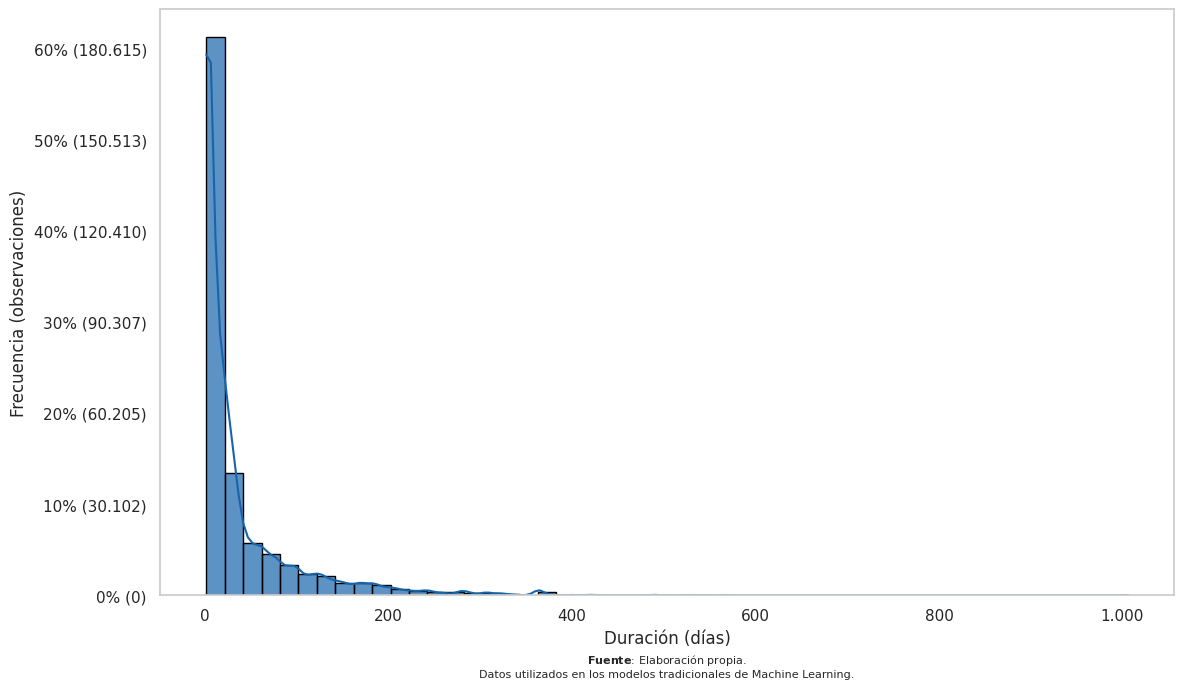

/content/Distribucion de la Duracion-Eje Y porcentaje.png

In [ ]:
## DISTRIBUCIÓN DE LA DURACIÓN (HISTOGRAMA) ##

# Calculamos el total de observaciones para el cálculo de porcentajes
total_observaciones = len(df_price_spell_ML['Duración'])

# Creamos la figura y el histograma con nuevo tamaño
plt.figure(figsize=(12, 7))
histplot = sns.histplot(
    df_price_spell_ML['Duración'],
    kde=True,
    bins=50,
    alpha=0.7,
    color=header_color,
    edgecolor='black',
    kde_kws={'cut': 0}
)

# Ajustamos las etiquetas (sin título)
plt.xlabel('Duración (días)', fontsize=12)
plt.ylabel('Frecuencia (observaciones)', fontsize=12)

# Eliminamos la cuadrícula
plt.grid(False)

# Obtenemos los valores actuales del eje Y (frecuencias absolutas)
y_ticks_abs = np.arange(0, 0.61, 0.10) * total_observaciones  # De 0% a 60% en saltos de 10%
histplot.set_yticks(y_ticks_abs)

# Etiquetas con porcentaje + valor absoluto
y_labels = [f"{(y / total_observaciones) * 100:.0f}% ({int(y):,})".replace(",", ".") for y in y_ticks_abs]
histplot.set_yticklabels(y_labels)

# Formateamos el eje X con separador de miles
histplot.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(",", ".")))

# Agregamos leyenda/disclaimer
plt.text(0.5, -0.12,
         r'$\bf{Fuente}$: Elaboración propia.' + '\nDatos utilizados en los modelos tradicionales de Machine Learning.',
         ha='center', va='center', transform=plt.gca().transAxes, fontsize=8)

plt.tight_layout()

# Guardamos la imagen localmente en el directorio actual
filename = "Distribucion de la Duracion-Eje Y porcentaje.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')

# Mostramos
plt.show()

# Creamos un enlace de descarga (queda guardado en entorno)
display(FileLink(filename))


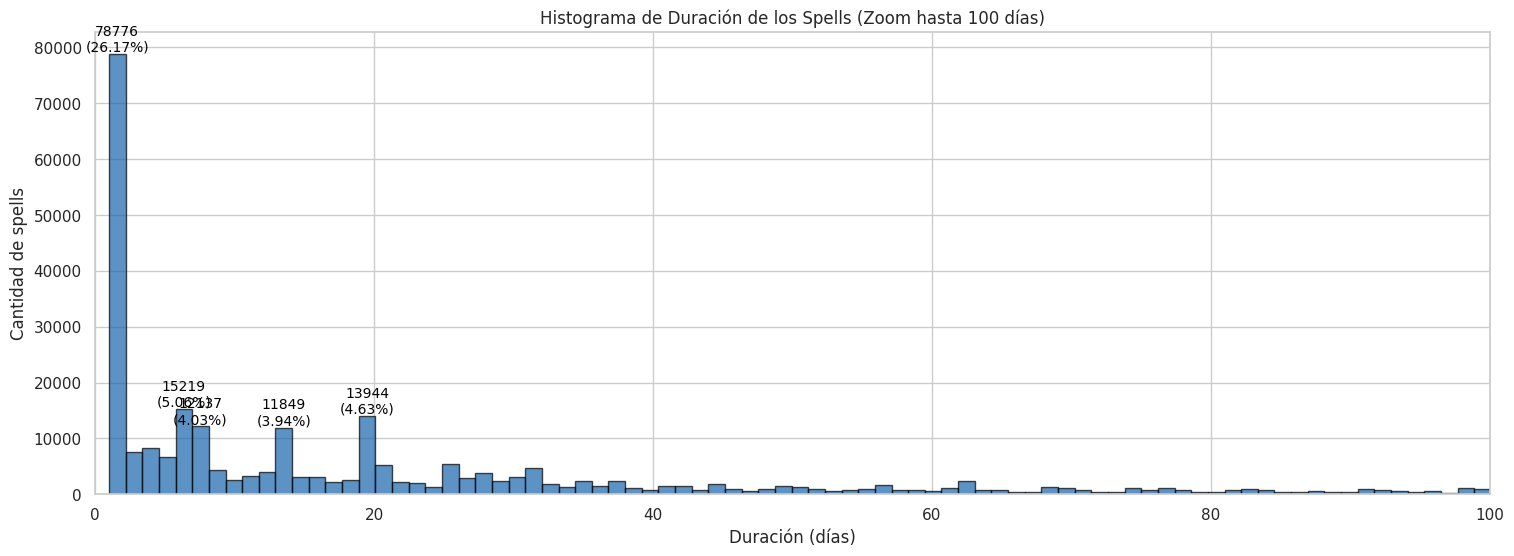

In [ ]:
## ZOOM DE SPELLS HASTA 100 DÍAS DE DURACIÓN ##

total_observaciones = len(df_price_spell_ML['Duración'])

# Creamos el histograma de la Duración
plt.figure(figsize=(18, 6))
counts, bins, _ = plt.hist(df_price_spell_ML['Duración'], bins='auto', edgecolor='black', alpha=0.7, color=header_color)

# Ajustamos límites del eje X para hacer zoom en los primeros 100 días
plt.xlim(0, 100)

# Obtenemos los índices de los 5 mayores conteos
top_5_indices = np.argsort(counts)[-5:]

# Añadimos etiquetas a los 5 bins con mayor frecuencia
for idx in top_5_indices:
    bin_center = (bins[idx] + bins[idx + 1]) / 2  # Calcula el centro del bin
    frequency = counts[idx]
    percentage = (frequency / total_observaciones) * 100  # Calcula el porcentaje
    plt.text(bin_center, frequency, f'{int(frequency)}\n({percentage:.2f}%)',
             ha='center', va='bottom', fontsize=10, color='black')

plt.title('Histograma de Duración de los Spells (Zoom hasta 100 días)')
plt.xlabel('Duración (días)')
plt.ylabel('Cantidad de spells')
plt.grid(True)
plt.show()

**Estadísticos Base Price Spells SURVIVAL MACHINE LEARNING**


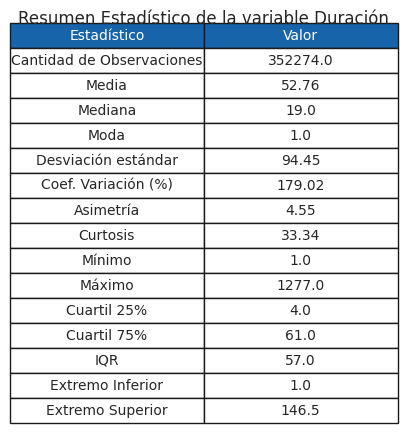

In [ ]:
# ESTADÍSTICOS BASE SURVIVAL #

# Generamos el resumen estadístico básico con describe() y redondear a 2 decimales
summary_stats = df_price_spell_SML['Duración'].describe().round(2)

# Calculamos la moda (puede haber más de una, tomamos la primera)
moda = df_price_spell_SML['Duración'].mode()
moda_valor = moda.iloc[0] if not moda.empty else None

# Calculamos el coeficiente de variación (CV = desviación estándar / media)
cv = (summary_stats['std'] / summary_stats['mean']) * 100  # Expresado en %

# Calculamos asimetría y curtosis
asimetría = skew(df_price_spell_SML['Duración'])
curtosis_valor = kurtosis(df_price_spell_SML['Duración'])

# Calculamos el rango intercuartílico (IQR)
iqr = summary_stats['75%'] - summary_stats['25%']

# Calculamos los límites de los bigotes del boxplot
lower_whisker = max(summary_stats['min'], summary_stats['25%'] - 1.5 * iqr)
upper_whisker = min(summary_stats['max'], summary_stats['75%'] + 1.5 * iqr)

# Creamos un DataFrame con todos los valores calculados
df_summary = pd.DataFrame({
    'Estadístico': [
        'Cantidad de Observaciones', 'Media', 'Mediana', 'Moda',
        'Desviación estándar', 'Coef. Variación (%)', 'Asimetría', 'Curtosis',
        'Mínimo', 'Máximo', 'Cuartil 25%', 'Cuartil 75%', 'IQR',
        'Extremo Inferior', 'Extremo Superior'
    ],
    'Valor': [
        int(summary_stats['count']), summary_stats['mean'], summary_stats['50%'], moda_valor,
        summary_stats['std'], cv, asimetría, curtosis_valor,
        summary_stats['min'], summary_stats['max'], summary_stats['25%'], summary_stats['75%'], iqr,
        lower_whisker, upper_whisker
    ]
}).round(2)

# Visualizamos como tabla con Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.axis('tight')
ax.axis('off')

tabla = ax.table(cellText=df_summary.values,
                 colLabels=df_summary.columns,
                 cellLoc='center',
                 loc='center')

tabla.scale(1, 1.5)
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)

# Resaltamos cabecera
header_color = plt.cm.Blues(0.8)
for i in range(len(df_summary.columns)):
    tabla[0, i].set_facecolor(header_color)
    tabla[0, i].set_text_props(color='white')

# Título
plt.title('Resumen Estadístico de la variable Duración', pad=5)

# Mostramos
plt.show()


#### **3.2**  **Relaciones entre Duración y Variación Relativa de Precio por: <ins>Cadena, Tipo de Establecimiento, Categoría y Rubro</ins>** (Scatter plots discriminando entre incrementos y reducciones)

In [ ]:
# RELACIÓN ENTRE DURACIÓN Y VARIACIÓN RELATIVA DEL PRECIO PROMEDIOS POR CADENA (DISCRIMINANDO ENTRE INCREMENTOS Y REDUCCIONES)

# Calculamos las medias para incrementos
incrementos = df_price_spell_ML[df_price_spell_ML['Var_Precio_%'] > 0]
medias_incrementos = incrementos.groupby('Cadena').agg(
    Media_Duracion=('Duración', 'mean'),
    Media_Var_Precio=('Var_Precio_%', 'mean')
).reset_index()

# Calculamos las medias para reducciones
reducciones = df_price_spell_ML[df_price_spell_ML['Var_Precio_%'] < 0]
medias_reducciones = reducciones.groupby('Cadena').agg(
    Media_Duracion=('Duración', 'mean'),
    Media_Var_Precio=('Var_Precio_%', 'mean')
).reset_index()

# Unimos los resultados
media_duracion_var_precio = pd.merge(
    medias_incrementos,
    medias_reducciones,
    on='Cadena',
    suffixes=('_Incremento', '_Reduccion'),
    how='outer'
).round(2)

# Visualizamos tabla final
media_duracion_var_precio

Cadena  Media_Duracion_Incremento  \
0                   Devoto                      43.24   
1           Devoto Express                      42.38   
2                    Disco                      32.61   
3                Farmashop                      70.38   
4                    Frigo                      61.07   
5                     Frog                      39.10   
6                    Géant                      46.02   
7                    Kinko                     102.93   
8              La Colonial                      95.09   
9   Macromercado Mayorista                      45.86   
10             Micro Macro                      42.54   
11                 Pigalle                      82.26   
12              Red Expres                      53.38   
13              Red Market                      66.61   
14               San Roque                      34.87   
15              Sin Cadena                      66.94   
16              Super Tico                     101.59   
17       Supercados Grupal                      54.69   
18    Supermercados Grupal                      55.74   
19                 Ta - Ta                      39.97   
20                 Tamisur                      77.13   
21          Tienda Inglesa                      48.60   
22                  Ubesur                      67.65   

    Media_Var_Precio_Incremento  Media_Duracion_Reduccion  \
0                         17.04                     14.47   
1                         17.83                     16.67   
2                         17.13                      9.57   
3                         34.36                     23.16   
4                         10.00                     35.71   
5                          8.32                     50.67   
6                         17.36                     17.35   
7                         17.16                     48.52   
8                          8.63                     38.47   
9                          9.86                     25.95   
10                        18.22                     25.65   
11                        52.46                     39.38   
12                         9.03                     39.12   
13                         9.17                     40.89   
14                        17.58                     19.52   
15                        10.94                     37.42   
16                         9.05                     58.36   
17                        27.12                     31.05   
18                        14.47                     35.38   
19                        12.81                     26.32   
20                         8.32                     36.35   
21                        13.00                     37.67   
22                        18.77                     38.65   

    Media_Var_Precio_Reduccion  
0                       -14.47  
1                       -14.97  
2                       -14.79  
3                       -14.74  
4                        -9.57  
5                        -5.44  
6                       -14.60  
7                       -19.95  
8                       -16.74  
9                       -10.15  
10                      -16.19  
11                      -26.63  
12                       -8.54  
13                       -9.84  
14                       -8.71  
15                      -10.61  
16                      -11.15  
17                      -19.63  
18                      -12.74  
19                      -10.40  
20                      -10.23  
21                      -11.45  
22                      -16.89

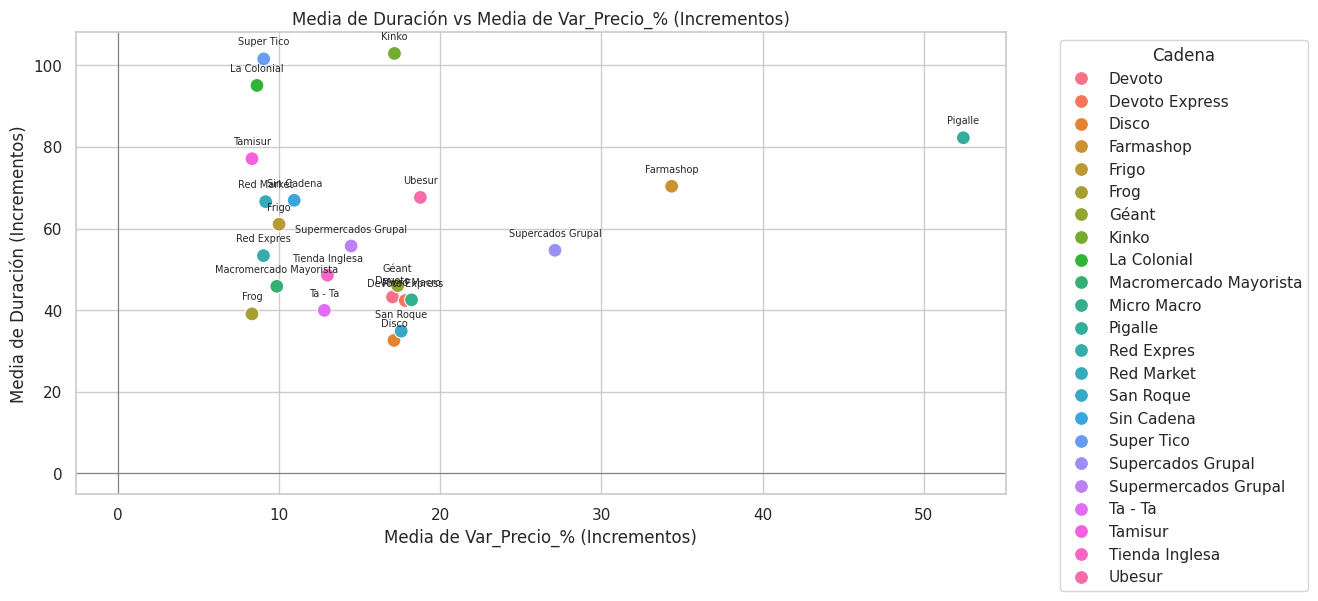

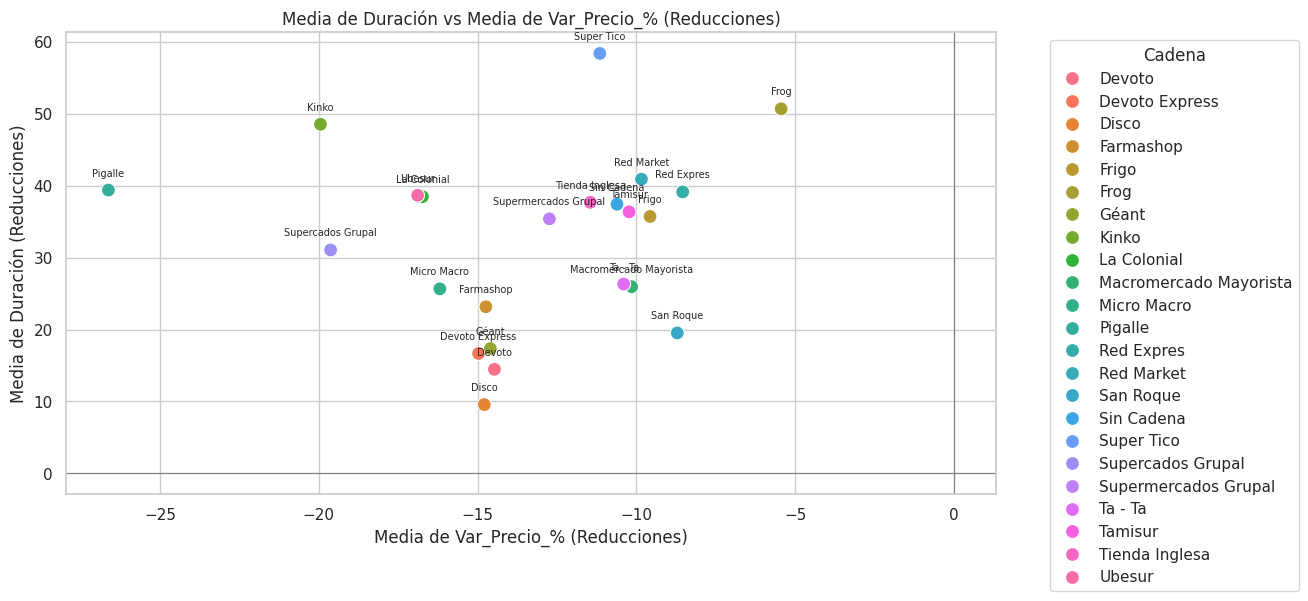

In [ ]:
# Configuramos el estilo de los gráficos
sns.set(style="whitegrid")

# Gráfica para incrementos
plt.figure(figsize=(12, 6))
sns.scatterplot(data=media_duracion_var_precio, x='Media_Var_Precio_Incremento', y='Media_Duracion_Incremento', hue='Cadena', s=100)
plt.title('Media de Duración vs Media de Var_Precio_% (Incrementos)')
plt.xlabel('Media de Var_Precio_% (Incrementos)')
plt.ylabel('Media de Duración (Incrementos)')
plt.axhline(0, color='grey', lw=0.8)
plt.axvline(0, color='grey', lw=0.8)

# Anotamos los puntos con el nombre de la Cadena y flechas solo si están cerca
for i in range(media_duracion_var_precio.shape[0]):
    # Ajustamos la longitud e inclinación de las flechas
    distance = 0.1  # Distancia que defines como "cercano"
    # Ubicación del texto
    text_x_offset = 30  # Aumenta el desplazamiento en x
    text_y_offset = 30  # Aumenta el desplazamiento en y

    # Añadimos flechas a puntos cercanos
    for j in range(i + 1, media_duracion_var_precio.shape[0]):
        if abs(media_duracion_var_precio['Media_Var_Precio_Incremento'].iloc[i] - media_duracion_var_precio['Media_Var_Precio_Incremento'].iloc[j]) < distance and \
           abs(media_duracion_var_precio['Media_Duracion_Incremento'].iloc[i] - media_duracion_var_precio['Media_Duracion_Incremento'].iloc[j]) < distance:
            # Si están cercanos, añadimos flecha con texto
            plt.annotate(media_duracion_var_precio['Cadena'].iloc[i],
                         (media_duracion_var_precio['Media_Var_Precio_Incremento'].iloc[i],
                          media_duracion_var_precio['Media_Duracion_Incremento'].iloc[i]),
                         textcoords="offset points",
                         xytext=(text_x_offset, text_y_offset),  # Mueve el texto con offsets
                         ha='center',
                         fontsize=7,
                         arrowprops=dict(arrowstyle='->', lw=1.5, color='black', connectionstyle="arc3,rad=0.5"))

            # Ajustamos la longitud de la flecha
            text_x_offset += 20  # Ajuste para alejar el texto de la flecha
            text_y_offset += 20

    # Aseguramos la agregación de anotaciones a puntos no cercanos
    plt.annotate(media_duracion_var_precio['Cadena'].iloc[i],
                 (media_duracion_var_precio['Media_Var_Precio_Incremento'].iloc[i],
                  media_duracion_var_precio['Media_Duracion_Incremento'].iloc[i]),
                 textcoords="offset points",
                 xytext=(0, 10),  # Texto estándar para otros
                 ha='center',
                 fontsize=7)

plt.legend(title='Cadena', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 6. Gráfica para reducciones
plt.figure(figsize=(12, 6))
sns.scatterplot(data=media_duracion_var_precio, x='Media_Var_Precio_Reduccion', y='Media_Duracion_Reduccion', hue='Cadena', s=100)
plt.title('Media de Duración vs Media de Var_Precio_% (Reducciones)')
plt.xlabel('Media de Var_Precio_% (Reducciones)')
plt.ylabel('Media de Duración (Reducciones)')
plt.axhline(0, color='grey', lw=0.8)
plt.axvline(0, color='grey', lw=0.8)

# Anotamos los puntos con el nombre de la Cadena y flechas solo si están cerca
for i in range(media_duracion_var_precio.shape[0]):
    # Ajustamos la longitud e inclinación de las flechas
    distance = 0.1  # Distancia que defines como "cercano"
    # Ubicación del texto
    text_x_offset = 30  # Aumenta el desplazamiento en x
    text_y_offset = 30  # Aumenta el desplazamiento en y

    # Añadimos flechas a puntos cercanos
    for j in range(i + 1, media_duracion_var_precio.shape[0]):
        if abs(media_duracion_var_precio['Media_Var_Precio_Reduccion'].iloc[i] - media_duracion_var_precio['Media_Var_Precio_Reduccion'].iloc[j]) < distance and \
           abs(media_duracion_var_precio['Media_Duracion_Reduccion'].iloc[i] - media_duracion_var_precio['Media_Duracion_Reduccion'].iloc[j]) < distance:
            # Si están cercanos, se añadimos flecha con texto
            plt.annotate(media_duracion_var_precio['Cadena'].iloc[i],
                         (media_duracion_var_precio['Media_Var_Precio_Reduccion'].iloc[i],
                          media_duracion_var_precio['Media_Duracion_Reduccion'].iloc[i]),
                         textcoords="offset points",
                         xytext=(text_x_offset, text_y_offset),  # Mueve el texto con offsets
                         ha='center',
                         fontsize=7,
                         arrowprops=dict(arrowstyle='->', lw=1.5, color='black', connectionstyle="arc3,rad=0.5"))

            # Ajustamos la longitud de la flecha
            text_x_offset += 20  # Ajuste para alejar el texto de la flecha
            text_y_offset += 20

    # Aseguramos la agregación de anotaciones a puntos no cercanos
    plt.annotate(media_duracion_var_precio['Cadena'].iloc[i],
                 (media_duracion_var_precio['Media_Var_Precio_Reduccion'].iloc[i],
                  media_duracion_var_precio['Media_Duracion_Reduccion'].iloc[i]),
                 textcoords="offset points",
                 xytext=(0, 10),  # Texto estándar para otros
                 ha='center',
                 fontsize=7)

plt.legend(title='Cadena', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


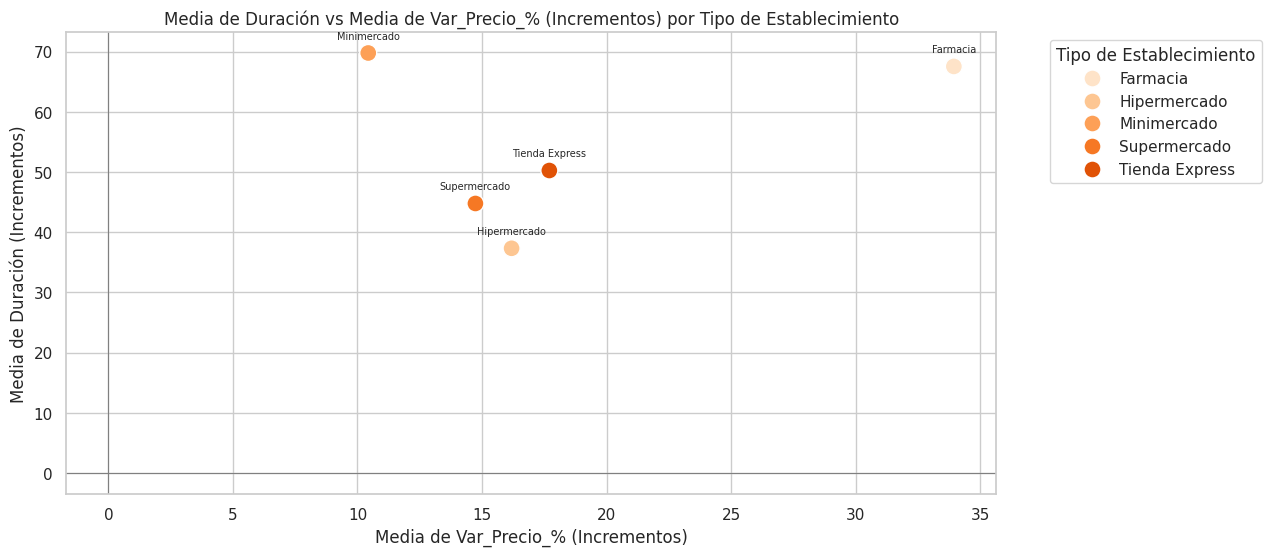

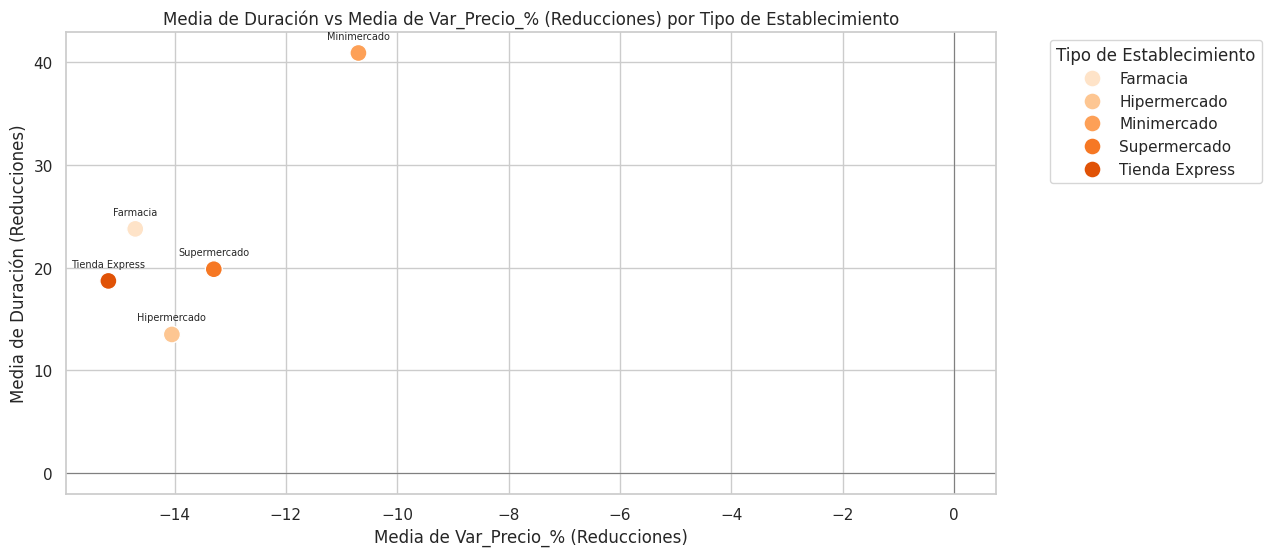

In [ ]:
## RELACIÓN ENTRE DURACIÓN Y VARIACIÓN RELATIVA DEL PRECIO PROMEDIOS POR TIPO DE ESTABLECIMIENTO (DISCRIMINANDO ENTRE INCREMENTOS Y REDUCCIONES) ##

# Calculamos las medias para incrementos
incrementos = df_price_spell_ML[df_price_spell_ML['Var_Precio_%'] > 0]
medias_incrementos = incrementos.groupby('Tipo_establecimiento').agg(
    Media_Duracion=('Duración', 'mean'),
    Media_Var_Precio=('Var_Precio_%', 'mean')
).reset_index()

# Calculamos las medias para reducciones
reducciones = df_price_spell_ML[df_price_spell_ML['Var_Precio_%'] < 0]
medias_reducciones = reducciones.groupby('Tipo_establecimiento').agg(
    Media_Duracion=('Duración', 'mean'),
    Media_Var_Precio=('Var_Precio_%', 'mean')
).reset_index()

# Unimos los resultados
media_duracion_var_precio = pd.merge(
    medias_incrementos,
    medias_reducciones,
    on='Tipo_establecimiento',
    suffixes=('_Incremento', '_Reduccion'),
    how='outer'
)

# Configuramos el estilo de los gráficos
sns.set(style="whitegrid")

# Configuramos la paleta de colores antes de crear los gráficos
sns.set_palette(sns.color_palette('Oranges'))

# Gráfica para incrementos
plt.figure(figsize=(12, 6))
sns.scatterplot(data=media_duracion_var_precio, x='Media_Var_Precio_Incremento', y='Media_Duracion_Incremento', hue='Tipo_establecimiento', s=150)
plt.title('Media de Duración vs Media de Var_Precio_% (Incrementos) por Tipo de Establecimiento')
plt.xlabel('Media de Var_Precio_% (Incrementos)')
plt.ylabel('Media de Duración (Incrementos)')
plt.axhline(0, color='grey', lw=0.8)
plt.axvline(0, color='grey', lw=0.8)

# Anotamos los puntos con el nombre de la Tipo_establecimiento y flechas solo si están cerca
for i in range(media_duracion_var_precio.shape[0]):
    # Ajustamos la longitud e inclinación de las flechas
    distance = 0.1  # Distancia que defines como "cercano"
    # Ubicación del texto
    text_x_offset = 30  # Aumenta el desplazamiento en x
    text_y_offset = 30  # Aumenta el desplazamiento en y

    # Añadimos flechas a puntos cercanos
    for j in range(i + 1, media_duracion_var_precio.shape[0]):
        if abs(media_duracion_var_precio['Media_Var_Precio_Incremento'].iloc[i] - media_duracion_var_precio['Media_Var_Precio_Incremento'].iloc[j]) < distance and \
           abs(media_duracion_var_precio['Media_Duracion_Incremento'].iloc[i] - media_duracion_var_precio['Media_Duracion_Incremento'].iloc[j]) < distance:
            # Si están cercanos, se añade flecha con texto
            plt.annotate(media_duracion_var_precio['Tipo_establecimiento'].iloc[i],
                         (media_duracion_var_precio['Media_Var_Precio_Incremento'].iloc[i],
                          media_duracion_var_precio['Media_Duracion_Incremento'].iloc[i]),
                         textcoords="offset points",
                         xytext=(text_x_offset, text_y_offset),  # Mueve el texto con offsets
                         ha='center',
                         fontsize=7,
                         arrowprops=dict(arrowstyle='->', lw=1.5, color='black', connectionstyle="arc3,rad=0.5"))

            # Ajustamo la longitud de la flecha
            text_x_offset += 20  # Ajuste para alejar el texto de la flecha
            text_y_offset += 20

    # Aseguramos la agregación de anotaciones a puntos no cercanos
    plt.annotate(media_duracion_var_precio['Tipo_establecimiento'].iloc[i],
                 (media_duracion_var_precio['Media_Var_Precio_Incremento'].iloc[i],
                  media_duracion_var_precio['Media_Duracion_Incremento'].iloc[i]),
                 textcoords="offset points",
                 xytext=(0, 10),  # Texto estándar para otros
                 ha='center',
                 fontsize=7)

plt.legend(title='Tipo de Establecimiento', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Gráfica para reducciones
plt.figure(figsize=(12, 6))
sns.scatterplot(data=media_duracion_var_precio, x='Media_Var_Precio_Reduccion', y='Media_Duracion_Reduccion', hue='Tipo_establecimiento', s=150)
plt.title('Media de Duración vs Media de Var_Precio_% (Reducciones) por Tipo de Establecimiento')
plt.xlabel('Media de Var_Precio_% (Reducciones)')
plt.ylabel('Media de Duración (Reducciones)')
plt.axhline(0, color='grey', lw=0.8)
plt.axvline(0, color='grey', lw=0.8)

# Anotamos los puntos con el nombre de la Tipo_establecimiento y flechas solo si están cerca
for i in range(media_duracion_var_precio.shape[0]):
    # Ajustamos la longitud e inclinación de las flechas
    distance = 0.1  # Distancia que defines como "cercano"
    # Ubicación del texto
    text_x_offset = 30  # Aumenta el desplazamiento en x
    text_y_offset = 30  # Aumenta el desplazamiento en y

    # Añadimos flechas a puntos cercanos
    for j in range(i + 1, media_duracion_var_precio.shape[0]):
        if abs(media_duracion_var_precio['Media_Var_Precio_Reduccion'].iloc[i] - media_duracion_var_precio['Media_Var_Precio_Reduccion'].iloc[j]) < distance and \
           abs(media_duracion_var_precio['Media_Duracion_Reduccion'].iloc[i] - media_duracion_var_precio['Media_Duracion_Reduccion'].iloc[j]) < distance:
            # Si están cercanos, se añade flecha con texto
            plt.annotate(media_duracion_var_precio['Tipo_establecimiento'].iloc[i],
                         (media_duracion_var_precio['Media_Var_Precio_Reduccion'].iloc[i],
                          media_duracion_var_precio['Media_Duracion_Reduccion'].iloc[i]),
                         textcoords="offset points",
                         xytext=(text_x_offset, text_y_offset),  # Mueve el texto con offsets
                         ha='center',
                         fontsize=7,
                         arrowprops=dict(arrowstyle='->', lw=1.5, color='black', connectionstyle="arc3,rad=0.5"))

            # Ajustamos la longitud de la flecha
            text_x_offset += 20  # Ajuste para alejar el texto de la flecha
            text_y_offset += 20

    # Aseguramos la agregación de anotaciones a puntos no cercanos
    plt.annotate(media_duracion_var_precio['Tipo_establecimiento'].iloc[i],
                 (media_duracion_var_precio['Media_Var_Precio_Reduccion'].iloc[i],
                  media_duracion_var_precio['Media_Duracion_Reduccion'].iloc[i]),
                 textcoords="offset points",
                 xytext=(0, 10),  # Texto estándar para otros
                 ha='center',
                 fontsize=7)

plt.legend(title='Tipo de Establecimiento', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


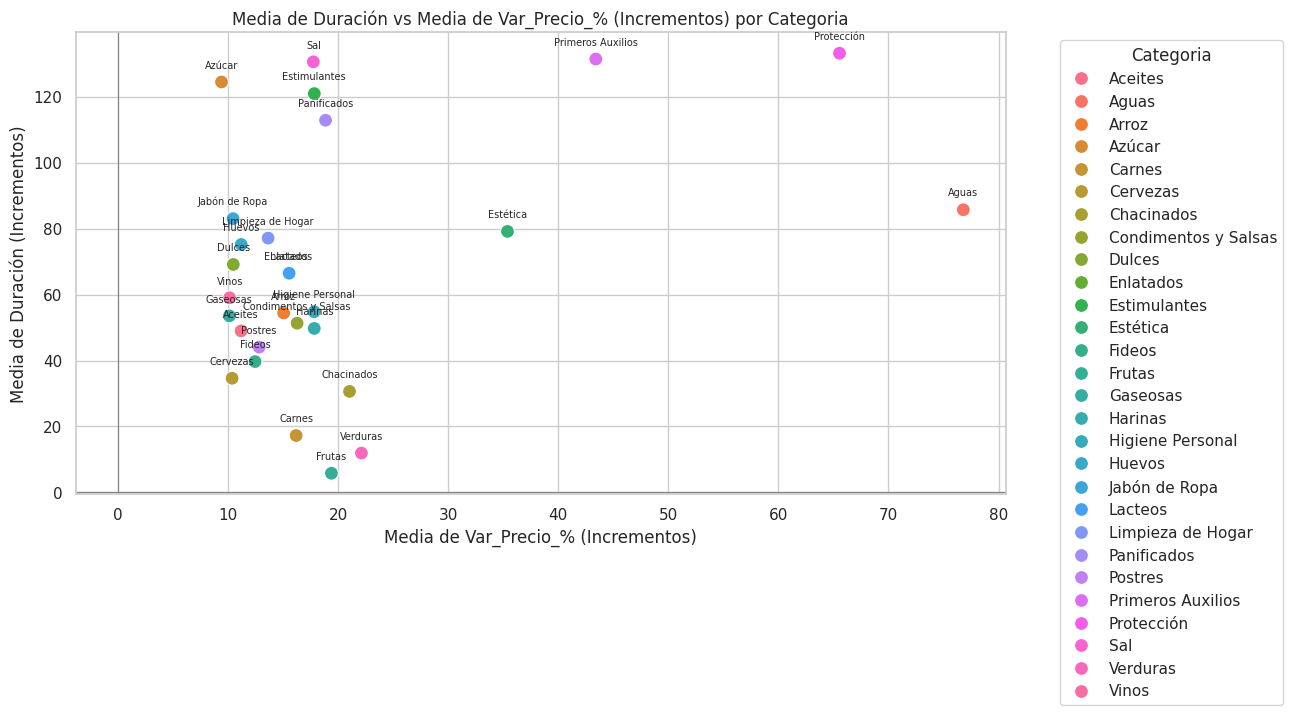

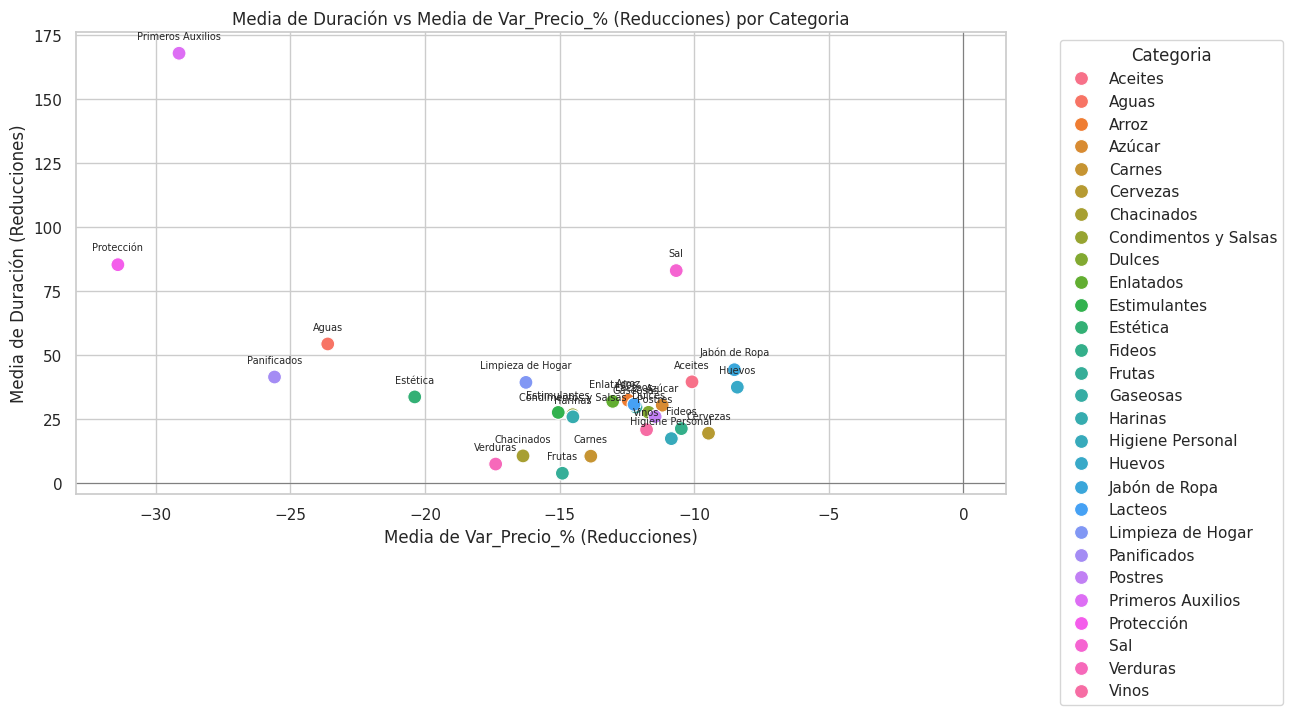

In [ ]:
## RELACIÓN ENTRE DURACIÓN Y VARIACIÓN RELATIVA DEL PRECIO PROMEDIOS POR CATEGORÍA (DISCRIMINANDO ENTRE INCREMENTOS Y REDUCCIONES) ##

# Calculamos las medias para incrementos por Categoria
incrementos = df_price_spell_ML[df_price_spell_ML['Var_Precio_%'] > 0]
medias_incrementos = incrementos.groupby('Categoria').agg(
    Media_Duracion=('Duración', 'mean'),
    Media_Var_Precio=('Var_Precio_%', 'mean')
).reset_index()

# Calculamos las medias para reducciones por Categoria
reducciones = df_price_spell_ML[df_price_spell_ML['Var_Precio_%'] < 0]
medias_reducciones = reducciones.groupby('Categoria').agg(
    Media_Duracion=('Duración', 'mean'),
    Media_Var_Precio=('Var_Precio_%', 'mean')
).reset_index()

# Unimos los resultados por Categoria
media_duracion_var_precio = pd.merge(
    medias_incrementos,
    medias_reducciones,
    on='Categoria',
    suffixes=('_Incremento', '_Reduccion'),
    how='outer'
)

# Configuramos el estilo de los gráficos
sns.set(style="whitegrid")

# Gráfica para incrementos por Categoria
plt.figure(figsize=(12, 6))
sns.scatterplot(data=media_duracion_var_precio, x='Media_Var_Precio_Incremento', y='Media_Duracion_Incremento', hue='Categoria', s=100)
plt.title('Media de Duración vs Media de Var_Precio_% (Incrementos) por Categoria')
plt.xlabel('Media de Var_Precio_% (Incrementos)')
plt.ylabel('Media de Duración (Incrementos)')
plt.axhline(0, color='grey', lw=0.8)
plt.axvline(0, color='grey', lw=0.8)

# Anotamos los puntos con el nombre de Categoria y flechas solo si están cerca
for i in range(media_duracion_var_precio.shape[0]):
    distance = 0.1  # Distancia que defines como "cercano"
    text_x_offset = 30  # Aumenta el desplazamiento en x
    text_y_offset = 30  # Aumenta el desplazamiento en y

    # Añadimos flechas a puntos cercanos
    for j in range(i + 1, media_duracion_var_precio.shape[0]):
        if abs(media_duracion_var_precio['Media_Var_Precio_Incremento'].iloc[i] - media_duracion_var_precio['Media_Var_Precio_Incremento'].iloc[j]) < distance and \
           abs(media_duracion_var_precio['Media_Duracion_Incremento'].iloc[i] - media_duracion_var_precio['Media_Duracion_Incremento'].iloc[j]) < distance:
            # Si están cercanos, se añade flecha con texto
            plt.annotate(media_duracion_var_precio['Categoria'].iloc[i],
                         (media_duracion_var_precio['Media_Var_Precio_Incremento'].iloc[i],
                          media_duracion_var_precio['Media_Duracion_Incremento'].iloc[i]),
                         textcoords="offset points",
                         xytext=(text_x_offset, text_y_offset),  # Mueve el texto con offsets
                         ha='center',
                         fontsize=7,
                         arrowprops=dict(arrowstyle='->', lw=1.5, color='black', connectionstyle="arc3,rad=0.5"))

            # Ajustamos la longitud de la flecha
            text_x_offset += 20  # Ajuste para alejar el texto de la flecha
            text_y_offset += 20

    # Aseguramos la agregación de anotaciones a puntos no cercanos
    plt.annotate(media_duracion_var_precio['Categoria'].iloc[i],
                 (media_duracion_var_precio['Media_Var_Precio_Incremento'].iloc[i],
                  media_duracion_var_precio['Media_Duracion_Incremento'].iloc[i]),
                 textcoords="offset points",
                 xytext=(0, 10),  # Texto estándar para otros
                 ha='center',
                 fontsize=7)

plt.legend(title='Categoria', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Gráfica para reducciones por Categoria
plt.figure(figsize=(12, 6))
sns.scatterplot(data=media_duracion_var_precio, x='Media_Var_Precio_Reduccion', y='Media_Duracion_Reduccion', hue='Categoria', s=100)
plt.title('Media de Duración vs Media de Var_Precio_% (Reducciones) por Categoria')
plt.xlabel('Media de Var_Precio_% (Reducciones)')
plt.ylabel('Media de Duración (Reducciones)')
plt.axhline(0, color='grey', lw=0.8)
plt.axvline(0, color='grey', lw=0.8)

# Anotamos los puntos con el nombre de Categoria y flechas solo si están cerca
for i in range(media_duracion_var_precio.shape[0]):
    distance = 0.1  # Distancia que defines como "cercano"
    text_x_offset = 30  # Aumenta el desplazamiento en x
    text_y_offset = 30  # Aumenta el desplazamiento en y

    # Añadimos flechas a puntos cercanos
    for j in range(i + 1, media_duracion_var_precio.shape[0]):
        if abs(media_duracion_var_precio['Media_Var_Precio_Reduccion'].iloc[i] - media_duracion_var_precio['Media_Var_Precio_Reduccion'].iloc[j]) < distance and \
           abs(media_duracion_var_precio['Media_Duracion_Reduccion'].iloc[i] - media_duracion_var_precio['Media_Duracion_Reduccion'].iloc[j]) < distance:
            # Si están cercanos, se añade flecha con texto
            plt.annotate(media_duracion_var_precio['Categoria'].iloc[i],
                         (media_duracion_var_precio['Media_Var_Precio_Reduccion'].iloc[i],
                          media_duracion_var_precio['Media_Duracion_Reduccion'].iloc[i]),
                         textcoords="offset points",
                         xytext=(text_x_offset, text_y_offset),  # Mueve el texto con offsets
                         ha='center',
                         fontsize=7,
                         arrowprops=dict(arrowstyle='->', lw=1.5, color='black', connectionstyle="arc3,rad=0.5"))

            # Ajustamos la longitud de la flecha
            text_x_offset += 20  # Ajuste para alejar el texto de la flecha
            text_y_offset += 20

    # Aseguramos la agregación de anotaciones a puntos no cercanos
    plt.annotate(media_duracion_var_precio['Categoria'].iloc[i],
                 (media_duracion_var_precio['Media_Var_Precio_Reduccion'].iloc[i],
                  media_duracion_var_precio['Media_Duracion_Reduccion'].iloc[i]),
                 textcoords="offset points",
                 xytext=(0, 10),  # Texto estándar para otros
                 ha='center',
                 fontsize=7)

plt.legend(title='Categoria', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


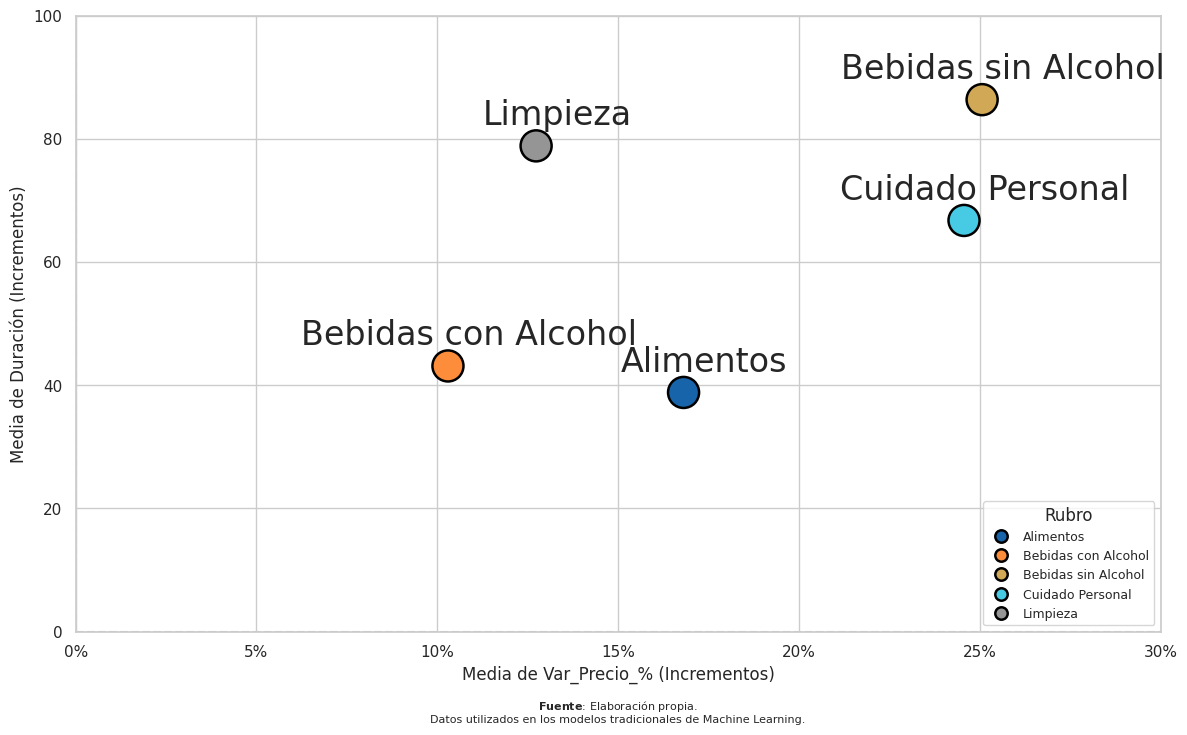

/content/Duracion_vs_VarPrecio_Rubro(incrementos).png

In [ ]:
## RELACIÓN ENTRE DURACIÓN Y VARIACIÓN RELATIVA DEL PRECIO PROMEDIOS POR RUBRO (DISCRIMINANDO ENTRE INCREMENTOS Y REDUCCIONES) ##

## INCREMENTOS

# Calculamos las medias para incrementos por Rubro
incrementos = df_price_spell_ML[df_price_spell_ML['Var_Precio_%'] > 0]
medias_incrementos = incrementos.groupby('Rubro').agg(
    Media_Duracion=('Duración', 'mean'),
    Media_Var_Precio=('Var_Precio_%', 'mean')
).reset_index()

# Calculamos las medias para reducciones por Rubro
reducciones = df_price_spell_ML[df_price_spell_ML['Var_Precio_%'] < 0]
medias_reducciones = reducciones.groupby('Rubro').agg(
    Media_Duracion=('Duración', 'mean'),
    Media_Var_Precio=('Var_Precio_%', 'mean')
).reset_index()

# Unimos los resultados por Rubro
media_duracion_var_precio = pd.merge(
    medias_incrementos,
    medias_reducciones,
    on='Rubro',
    suffixes=('_Incremento', '_Reduccion'),
    how='outer'
)

# Configuración de los gráficos
sns.set(style="whitegrid")

# Paleta de colores personalizada
palette = color_dict  # Usando el diccionario de colores definido previamente

# Función para anotar los puntos con nombres de rubros
def anotar_puntos(data, x_col, y_col, ax):
    for i in range(data.shape[0]):
        ax.annotate(
            data['Rubro'].iloc[i],
            (data[x_col].iloc[i], data[y_col].iloc[i]),
            textcoords="offset points",
            xytext=(15, 15),  # Desplazamiento estándar para evitar superposición
            ha='center',
            fontsize=24  # Agrandar los nombres de los puntos
        )

# Función para agregar el símbolo de % en los valores del eje X
def formato_porcentaje(x, _):
    return f"{x:.0f}%"  # Agregar el símbolo de %

# Gráfica para incrementos por Rubro
plt.figure(figsize=(14, 8))  # Agrandar la figura
ax1 = sns.scatterplot(
    data=media_duracion_var_precio,
    x='Media_Var_Precio_Incremento',
    y='Media_Duracion_Incremento',
    hue='Rubro',
    s=500,  # Agrandar los puntos
    palette=palette,
    edgecolor='black'
)

plt.xlabel('Media de Var_Precio_% (Incrementos)', fontsize=12)
plt.ylabel('Media de Duración (Incrementos)', fontsize=12)
plt.axhline(0, color='grey', linestyle='--', alpha=0.5, zorder=0)
plt.axvline(0, color='grey', linestyle='--', alpha=0.5, zorder=0)

# Aplicamos el formateador al eje X
ax1.xaxis.set_major_formatter(FuncFormatter(formato_porcentaje))

# Ajustamos los límites del eje
plt.xlim(0, 30)  # Eje X hasta 30
plt.ylim(0, 100)  # Eje Y hasta 100

# Anotamos los puntos
anotar_puntos(media_duracion_var_precio, 'Media_Var_Precio_Incremento', 'Media_Duracion_Incremento', plt.gca())

# Ajustamos la leyenda al vértice inferior derecho
plt.legend(title='Rubro', loc='lower right', fontsize=9, markerscale=0.4)

# Disclaimer
plt.text(0.5, -0.13,
         r'$\bf{Fuente}$: Elaboración propia.' + '\nDatos utilizados en los modelos tradicionales de Machine Learning.',
         ha='center', va='center', transform=plt.gca().transAxes, fontsize=8)

# Guardamos la imagen localmente en el directorio actual
filename = "Duracion_vs_VarPrecio_Rubro(incrementos).png"
plt.savefig(filename, dpi=300, bbox_inches='tight')

# Mostramos
plt.show()

# Creamos un enlace de descarga (queda guardado en entorno)
display(FileLink(filename))


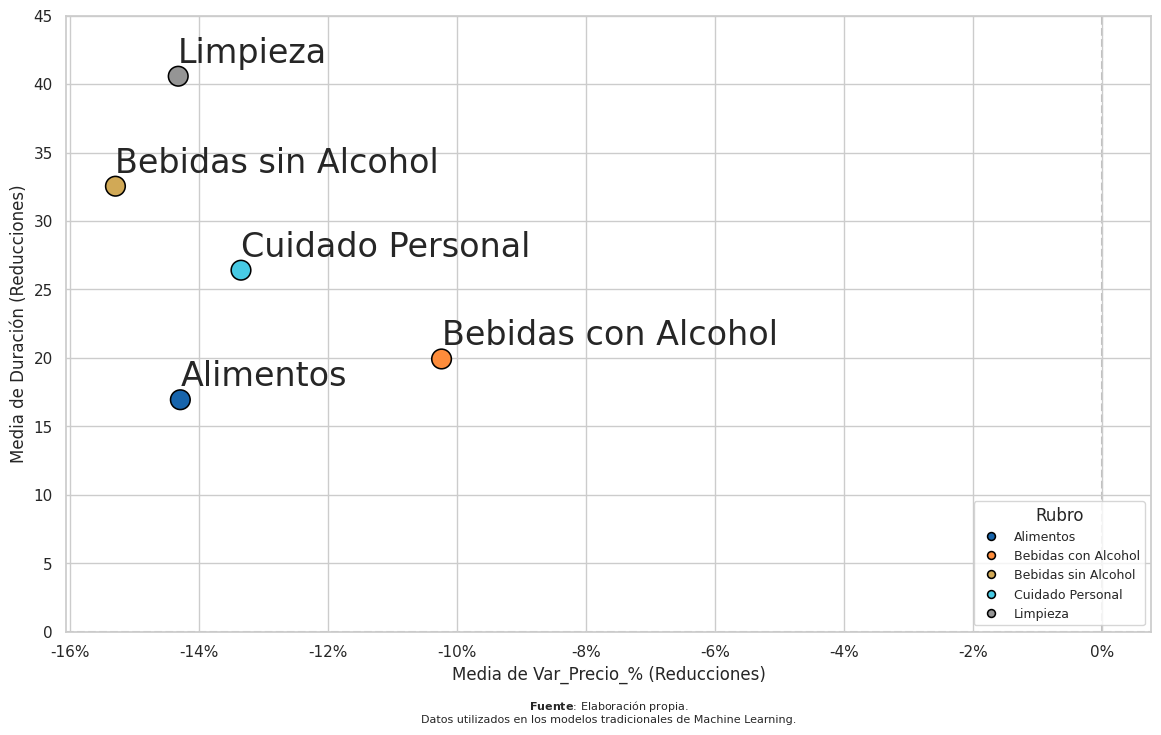

/content/Duracion_vs_VarPrecio_Rubro(reducciones).png

In [ ]:
## REDUCCIONES

# Calculamos las medias para incrementos por Rubro
incrementos = df_price_spell_ML[df_price_spell_ML['Var_Precio_%'] > 0]
medias_incrementos = incrementos.groupby('Rubro').agg(
    Media_Duracion=('Duración', 'mean'),
    Media_Var_Precio=('Var_Precio_%', 'mean')
).reset_index()

# Calculamos las medias para reducciones por Rubro
reducciones = df_price_spell_ML[df_price_spell_ML['Var_Precio_%'] < 0]
medias_reducciones = reducciones.groupby('Rubro').agg(
    Media_Duracion=('Duración', 'mean'),
    Media_Var_Precio=('Var_Precio_%', 'mean')
).reset_index()

# Unimos los resultados por Rubro
media_duracion_var_precio = pd.merge(
    medias_incrementos,
    medias_reducciones,
    on='Rubro',
    suffixes=('_Incremento', '_Reduccion'),
    how='outer'
)

# Configuración de los gráficos
sns.set(style="whitegrid")

# Paleta de colores personalizada
palette = color_dict  # Usamos el diccionario de colores definido previamente

# Función para anotar los puntos con nombres de rubros
def anotar_puntos(data, x_col, y_col, ax):
    for i in range(data.shape[0]):
        ax.annotate(
            data['Rubro'].iloc[i],
            (data[x_col].iloc[i], data[y_col].iloc[i]),
            textcoords="offset points",
            xytext=(0, 10),  # Desplazamiento estándar para evitar superposición
            ha='left',
            fontsize=24  # Agranda los nombres de los puntos
        )

# Función para agregar el símbolo de % en los valores del eje X
def formato_porcentaje(x, _):
    return f"{x:.0f}%"  # Agrega el símbolo de %

# Gráfica para reducciones por Rubro
plt.figure(figsize=(14, 8))  # Agranda la figura
ax2 = sns.scatterplot(
    data=media_duracion_var_precio,
    x='Media_Var_Precio_Reduccion',
    y='Media_Duracion_Reduccion',
    hue='Rubro',
    s=200,  # Agranda los puntos
    palette=palette,
    edgecolor='black'
)
plt.xlabel('Media de Var_Precio_% (Reducciones)', fontsize=12)
plt.ylabel('Media de Duración (Reducciones)', fontsize=12)
plt.axhline(0, color='grey', linestyle='--', alpha=0.5, zorder=0)
plt.axvline(0, color='grey', linestyle='--', alpha=0.5, zorder=0)

# Aplicamos el formateador al eje X
ax2.xaxis.set_major_formatter(FuncFormatter(formato_porcentaje))

# Ajustamos los límites del eje
plt.ylim(0, 45)  # Eje Y hasta 45

# Anotamos los puntos
anotar_puntos(media_duracion_var_precio, 'Media_Var_Precio_Reduccion', 'Media_Duracion_Reduccion', plt.gca())

# Ajustamos la leyenda al vértice inferior derecho
plt.legend(title='Rubro', loc='lower right', fontsize=9, markerscale=0.4)

# Disclaimer
plt.text(0.5, -0.13,
         r'$\bf{Fuente}$: Elaboración propia.' + '\nDatos utilizados en los modelos tradicionales de Machine Learning.',
         ha='center', va='center', transform=plt.gca().transAxes, fontsize=8)

# Guardamos la imagen localmente en el directorio actual
filename = "Duracion_vs_VarPrecio_Rubro(reducciones).png"
plt.savefig(filename, dpi=300, bbox_inches='tight')

# Mostramos
plt.show()

# Creamos un enlace de descarga (queda guardado en entorno)
display(FileLink(filename))


#### **3.3**  **Mapas de Calor de la Duración por** <ins>**Tipo de establecimiento y Categoría</ins>**

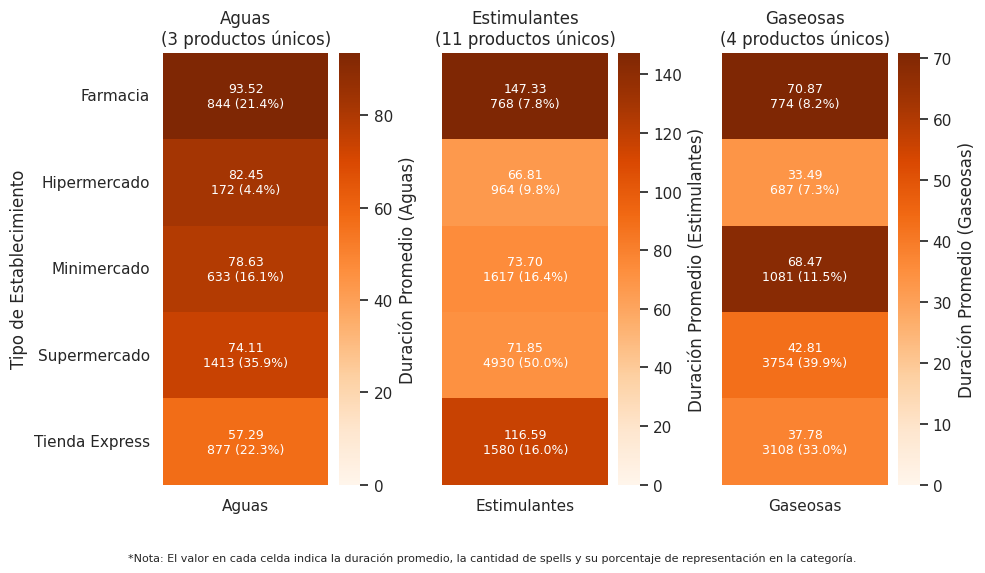

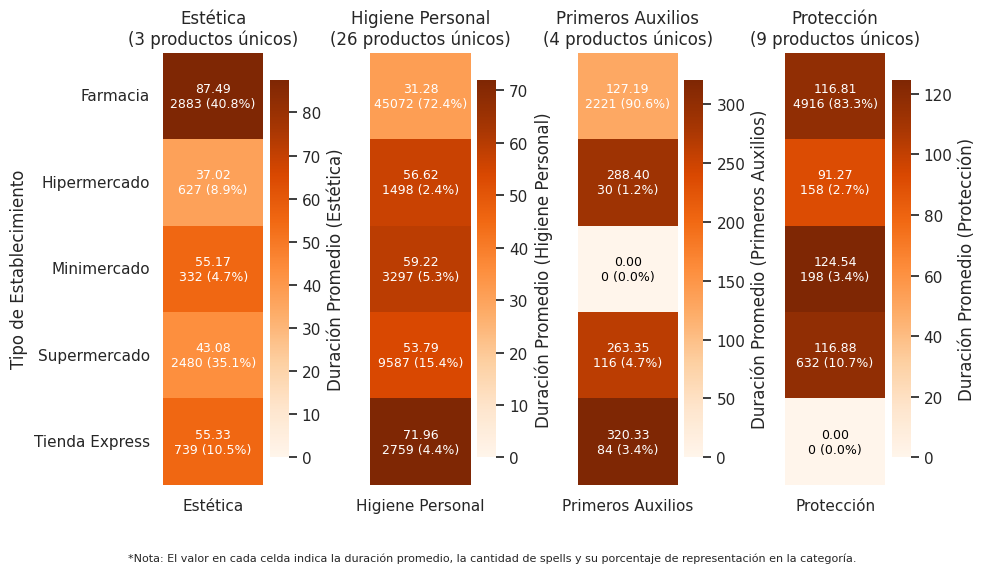

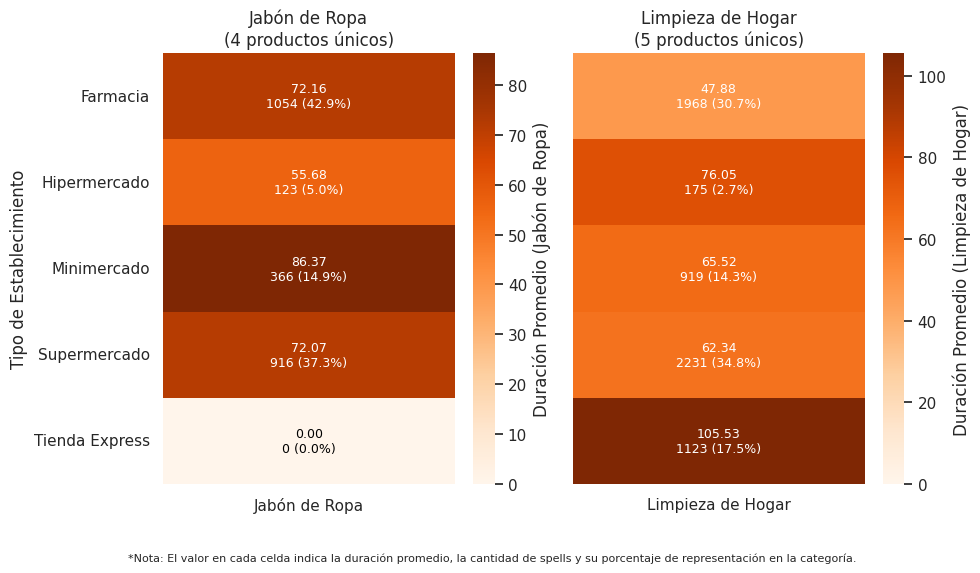

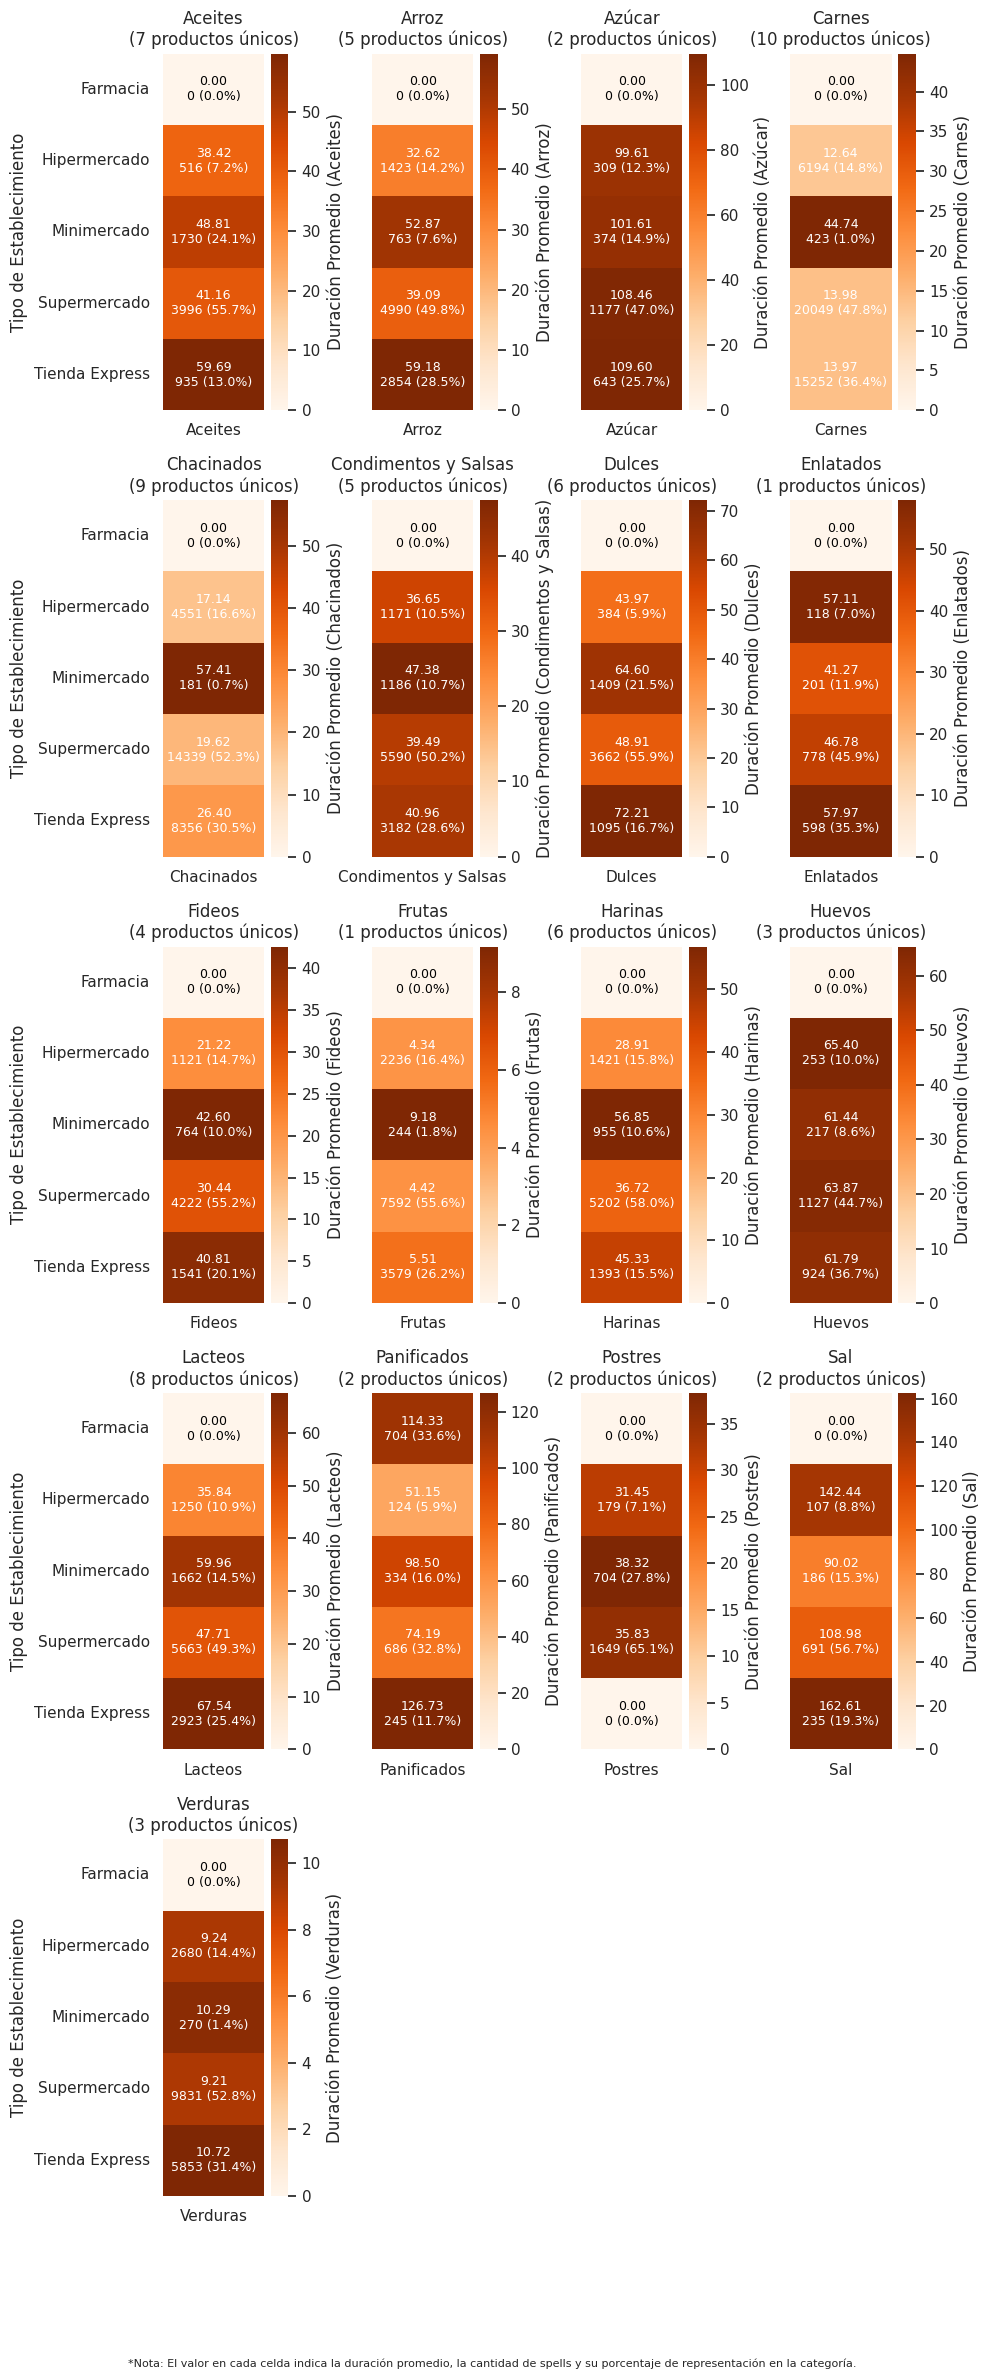

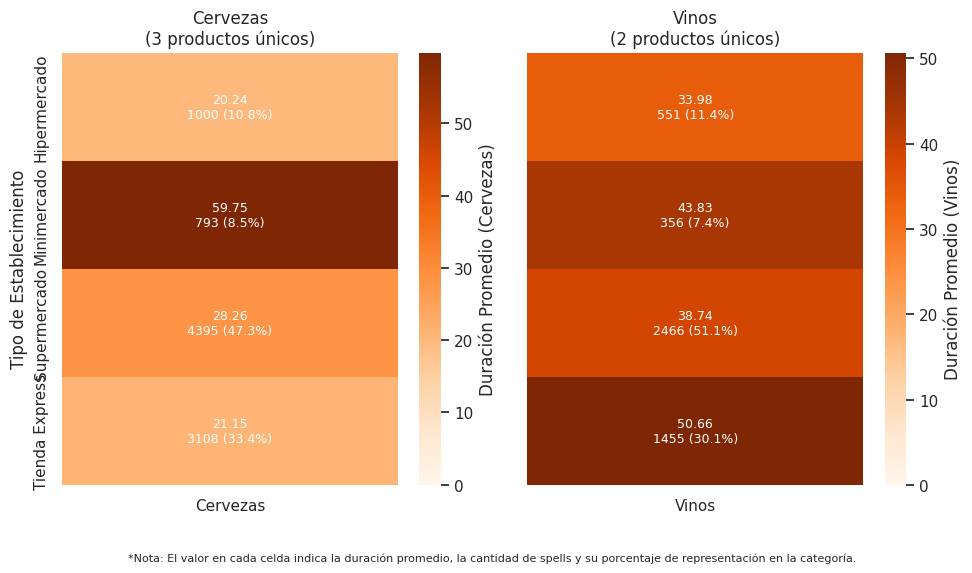

In [ ]:
## MAPAS DE CALOR DE DURACIÓN DE PRECIOS SEGÚN TIPO DE ESTABLECIMIENTO Y CATEGORÍA ## (sin totales para simplificar la comparación)

# Agrupamos por Tipo de Establecimiento, Categoria y Rubro para calcular la duración promedio y contar los casos
conteo_duracion = df_price_spell_ML.groupby(['Tipo_establecimiento', 'Categoria', 'Rubro']).agg(
    Duracion_Promedio=('Duración', 'mean'),  # Calcula la duración promedio
    Cantidad_Casos=('Duración', 'count')  # Cuenta la cantidad de spells
).reset_index()

# Agrupamos por Categoria y Rubro para contar los productos únicos en cada categoría
conteo_articulos_categoria = df_price_spell_ML.groupby(['Categoria', 'Rubro'])['ID_producto'].nunique().reset_index()
conteo_articulos_categoria.columns = ['Categoria', 'Rubro', 'Articulos_Unicos']

# Añadimos la cantidad de productos únicos a cada categoría en el DataFrame
conteo_duracion = pd.merge(conteo_duracion, conteo_articulos_categoria, on=['Categoria', 'Rubro'], how='left')

# Obtenemos la lista única de rubros
rubros_unicos = conteo_duracion['Rubro'].unique()

# Generamos un gráfico separado para cada rubro
for rubro in rubros_unicos:
    # Filtramos el DataFrame por el rubro actual
    df_rubro = conteo_duracion[conteo_duracion['Rubro'] == rubro]

    # Agrupamos nuevamente por Tipo_establecimiento y Categoria para evitar duplicados
    df_rubro = df_rubro.groupby(['Tipo_establecimiento', 'Categoria']).agg(
        Duracion_Promedio=('Duracion_Promedio', 'mean'),
        Cantidad_Casos=('Cantidad_Casos', 'sum'),
        Articulos_Unicos=('Articulos_Unicos', 'first')  # Usar 'first' o 'max' para evitar duplicados
    ).reset_index()

    # Pivotamos el DataFrame para crear el Mapa de calor
    matriz_confusion = df_rubro.pivot(index='Tipo_establecimiento', columns='Categoria', values='Duracion_Promedio').fillna(0)

    # Creamos una matriz para la cantidad de Spells
    matriz_casos = df_rubro.pivot(index='Tipo_establecimiento', columns='Categoria', values='Cantidad_Casos').fillna(0)

    # Calculamos la cantidad de productos únicos por categoría
    productos_unicos_categoria = df_rubro.groupby('Categoria')['Articulos_Unicos'].max()

    # Determinamos la cantidad de columnas y filas necesarias
    num_cols = min(4, matriz_confusion.shape[1])  # Máximo 4 columnas por fila
    num_rows = int(np.ceil(matriz_confusion.shape[1] / num_cols))  # Calculamos el número de filas necesarias

    # Ajustamos el tamaño de la figura en función de la cantidad de categorías y tipos de establecimiento
    fig_width = max(10, num_cols * 2)  # Ajuste del ancho según el número de columnas
    fig_height = max(6, matriz_confusion.shape[0] * num_rows)  # Ajuste de la altura según el número de filas y tipos de establecimiento

    # Creamos el gráfico de Mapa de calor
    plt.figure(figsize=(fig_width, fig_height))  # Establece el tamaño de la figura

    # Creamos subplots para cada columna (Categoría) del Mapa de calor
    for col_idx, col in enumerate(matriz_confusion.columns):
        ax = plt.subplot(num_rows, num_cols, col_idx + 1)

        # Calcular el rango de valores para esta categoría específica
        vmin = 0  # El valor mínimo siempre será 0 (blanco)
        vmax = matriz_confusion[col].max()

        # Decide si mostrar o no las etiquetas de los tipos de establecimiento
        show_yticklabels = (col_idx % 4 == 0)

        # Dibujamos el heatmap para la categoría específica con su propia escala de color
        sns.heatmap(matriz_confusion[[col]], annot=False, fmt=".1f", cmap="Oranges", cbar_kws={'label': f'Duración Promedio ({col})'},
                    vmin=vmin, vmax=vmax, ax=ax, yticklabels=show_yticklabels)

        # Añadimos etiquetas personalizadas con la duración promedio, cantidad de spells y porcentaje sobre el total de spells de la Categoría
        for y in range(matriz_confusion.shape[0]):
            precio = matriz_confusion.iloc[y, col_idx]
            cantidad = matriz_casos.iloc[y, col_idx]
            total_casos_categoria = matriz_casos.iloc[:, col_idx].sum()
            porcentaje = (cantidad / total_casos_categoria) * 100 if total_casos_categoria > 0 else 0

            # Decide el color del texto según el valor de precio
            color_texto = 'black' if precio == 0 else 'white'
            ax.text(0.5, y + 0.5, f'{precio:.2f}\n{int(cantidad)} ({porcentaje:.1f}%)',
                    ha='center', va='center', color=color_texto, fontsize=9)

        # Añadimos el nombre de la categoría y cantidad de productos únicos en el título de la categoría
        ax.set_title(f'{col}\n({productos_unicos_categoria[col]} productos únicos)', fontsize=12)
        ax.set_ylabel('' if col_idx % 4 != 0 else 'Tipo de Establecimiento', fontsize=12)
        ax.set_xlabel('')

    # Ajustamos el layout para evitar superposiciones
    plt.tight_layout(rect=[0, 0, 1, 0.90])

    # Añadimos una nota explicativa debajo del gráfico
    plt.figtext(0.5, -0.05, '*Nota: El valor en cada celda indica la duración promedio, la cantidad de spells y su porcentaje de representación en la categoría.', ha='center', fontsize=8)

    # Visualizamos los mapas
    plt.show()


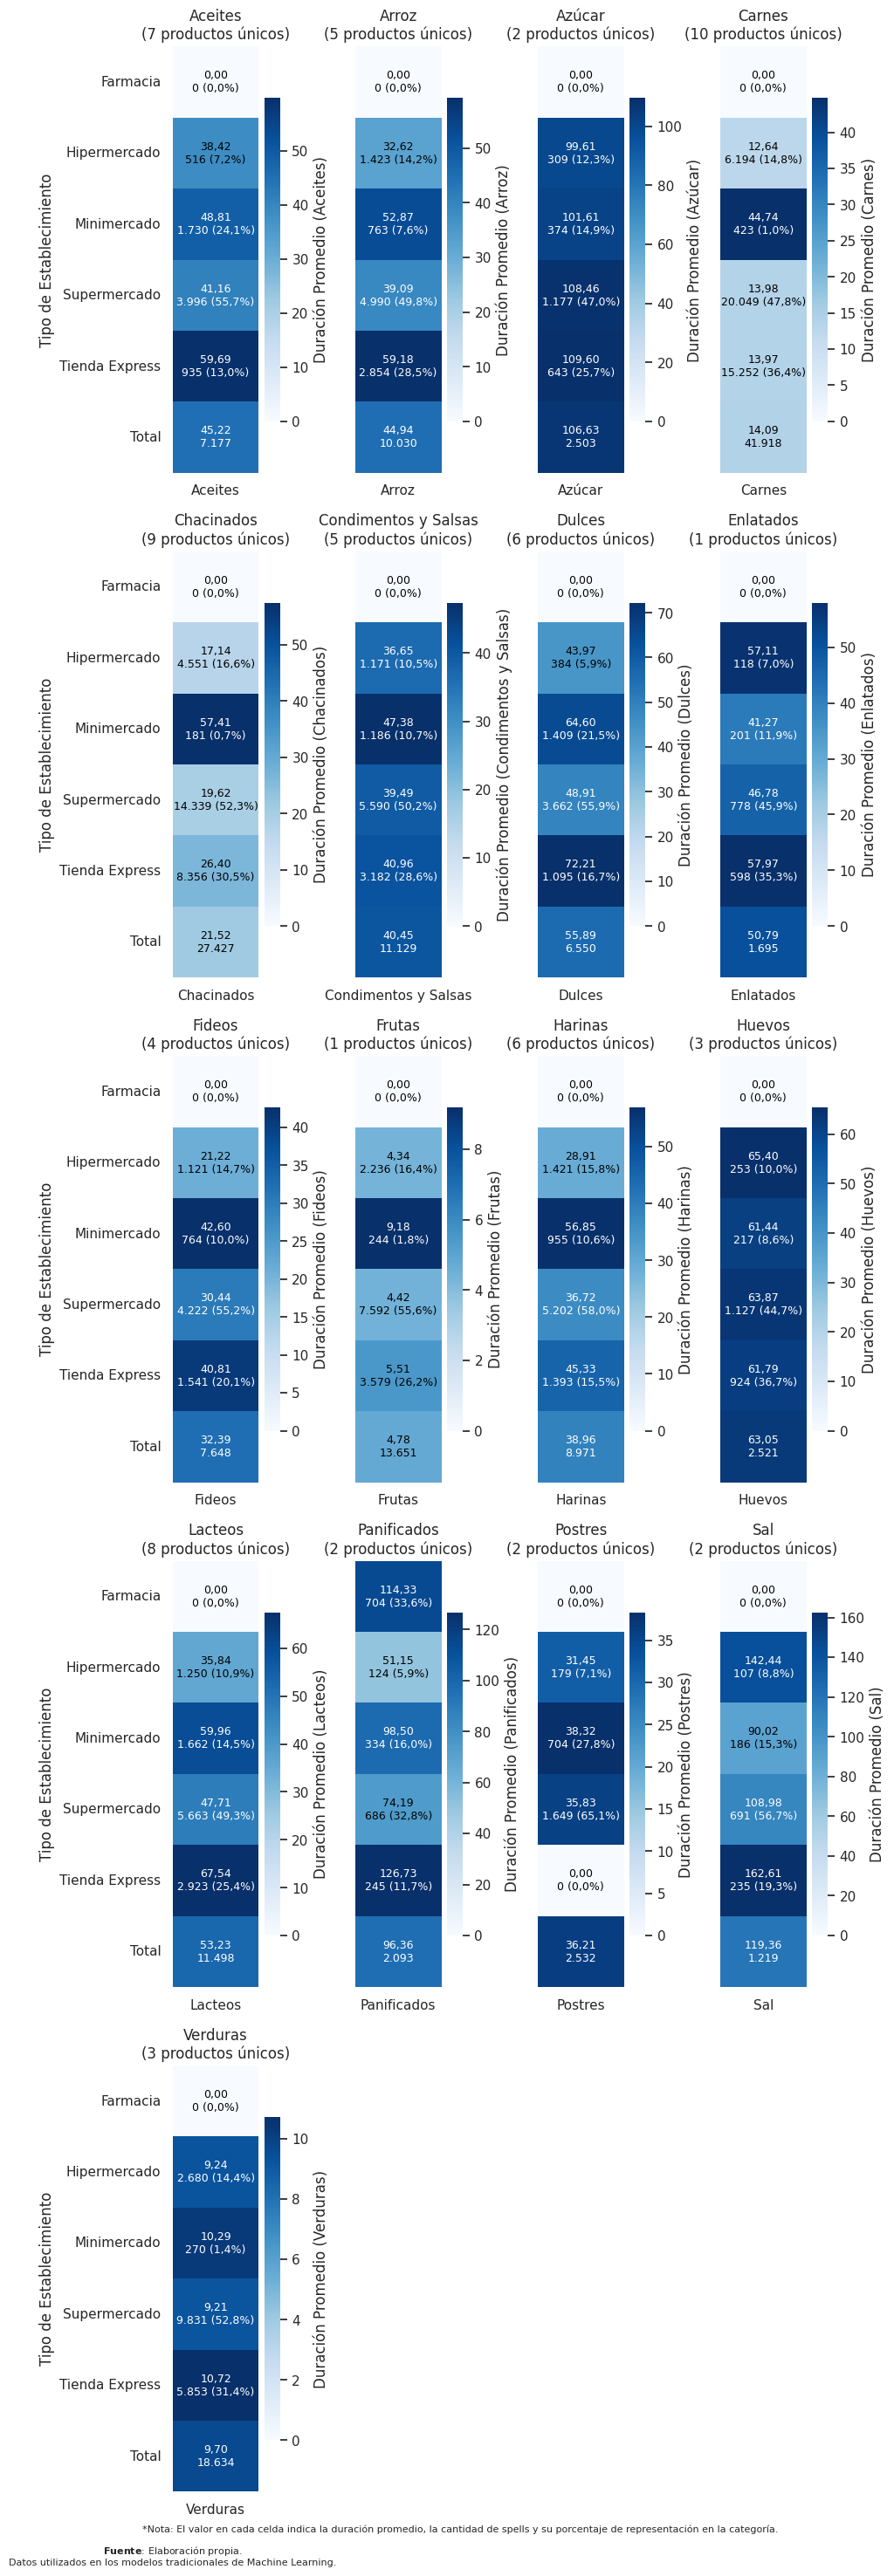

/content/1.3.3-Mapa de Calor (Alimentos).png

In [ ]:
## MAPAS DE CALOR DE DURACIÓN DE PRECIOS SEGÚN TIPO DE ESTABLECIMIENTO Y CATEGORÍA ## (generamos de a 1 imagen por Rubro)

# Ajustamos el diccionario para asignar colormaps completos
color_dict = {
    'Alimentos': plt.get_cmap('Blues'),  # Paleta completa Blues
    'Bebidas con Alcohol': plt.get_cmap('Oranges'),  # Paleta completa Oranges
    'Bebidas sin Alcohol': cmap_dorados_muy_suave,  # Paleta dorados personalizada
    'Cuidado Personal': cmap_celestes_muy_suave,  # Paleta celestes personalizada
    'Limpieza': plt.get_cmap('Greys'),  # Paleta completa Greys
}

# Definimos el Rubro que quieres visualizar
rubro_seleccionado = "Alimentos"  # Reemplaza 'TuRubroEspecifico' por el rubro que desees ver.

# Definición del DataFrame conteo_duracion
# Agrupamos por Tipo de Establecimiento, Categoria y Rubro para calcular la duración promedio y contar los casos
conteo_duracion = df_price_spell_ML.groupby(['Tipo_establecimiento', 'Categoria', 'Rubro']).agg(
    Duracion_Promedio=('Duración', 'mean'),  # Calcula la duración promedio por Tipo de Establecimiento
    Cantidad_Casos=('Duración', 'count')  # Cuenta la cantidad de spells
).reset_index()

# Agrupamos por Categoria y Rubro para contar los productos únicos en cada categoría
conteo_articulos_categoria = df_price_spell_ML.groupby(['Categoria', 'Rubro'])['ID_producto'].nunique().reset_index()
conteo_articulos_categoria.columns = ['Categoria', 'Rubro', 'Articulos_Unicos']

# Añadimos la cantidad de productos únicos a cada categoría en el DataFrame
conteo_duracion = pd.merge(conteo_duracion, conteo_articulos_categoria, on=['Categoria', 'Rubro'], how='left')

# Agrupamos los datos por Categoria y Rubro para calcular la duración promedio global
duracion_promedio_global = df_price_spell_ML.groupby(['Categoria', 'Rubro'])['Duración'].mean().reset_index()
duracion_promedio_global.columns = ['Categoria', 'Rubro', 'Duracion_Promedio_Global']

# Hacemos un merge para añadir la duración promedio global al DataFrame de conteo_duracion
conteo_duracion = pd.merge(conteo_duracion, duracion_promedio_global, on=['Categoria', 'Rubro'], how='left')

# Filtramos el DataFrame para ese Rubro
df_rubro_seleccionado = conteo_duracion[conteo_duracion['Rubro'] == rubro_seleccionado]

# Añadimos una fila de Totales para cada Categoría, calculando la duración promedio global
totales_por_categoria = df_rubro_seleccionado.groupby('Categoria').agg(
    Duracion_Promedio=('Duracion_Promedio_Global', 'mean'),  # Utilizamos la duración promedio global
    Cantidad_Casos=('Cantidad_Casos', 'sum')
).reset_index()

totales_por_categoria['Tipo_establecimiento'] = 'Total'  # Define la fila de Total
df_rubro_seleccionado = pd.concat([df_rubro_seleccionado, totales_por_categoria], ignore_index=True)

# Pivotamos el DataFrame para crear el Mapa de calor
matriz_confusion = df_rubro_seleccionado.pivot(index='Tipo_establecimiento', columns='Categoria', values='Duracion_Promedio').fillna(0)
matriz_casos = df_rubro_seleccionado.pivot(index='Tipo_establecimiento', columns='Categoria', values='Cantidad_Casos').fillna(0)

# Calculamos la cantidad de productos únicos por categoría
productos_unicos_categoria = df_rubro_seleccionado.groupby('Categoria')['Articulos_Unicos'].max()

# Determinamos la cantidad de columnas y filas necesarias
num_cols = min(4, matriz_confusion.shape[1])  # Máximo 4 columnas por fila
num_rows = int(np.ceil(matriz_confusion.shape[1] / num_cols))  # Calculamos el número de filas necesarias

# Ajustamos el tamaño de la figura en función de la cantidad de categorías y tipos de establecimiento
fig_width = max(10, num_cols * 2)  # Ajuste del ancho según el número de columnas
fig_height = max(6, matriz_confusion.shape[0] * num_rows)  # Ajuste de la altura según el número de filas y tipos de establecimiento

# Creamos el gráfico de Mapa de calor
plt.figure(figsize=(fig_width, fig_height))  # Establece el tamaño de la figura

# Función para formatear números con punto para miles y coma para decimales
def formato_personalizado(numero, decimales=2):
    """Formatea números con punto para miles y coma para decimales"""
    return f'{numero:,.{decimales}f}'.replace(',', 'X').replace('.', ',').replace('X', '.')

import matplotlib.colors as mcolors

# Función para determinar el color del texto basado en la luminosidad del color de fondo
def obtener_color_texto(hex_color):
    """Devuelve 'blanco' o 'negro' dependiendo de la luminosidad del color de fondo."""
    rgb = mcolors.hex2color(hex_color)  # Convertir hex a RGB
    luminosidad = 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]  # Fórmula estándar
    return 'white' if luminosidad < 0.5 else 'black'

# Creación de mapas de calor por Categoría con colores dinámicos para el texto
for col_idx, col in enumerate(matriz_confusion.columns):
    ax = plt.subplot(num_rows, num_cols, col_idx + 1)

    # Obtenemos el colormap según el Rubro
    rubro = rubro_seleccionado  # Rubro seleccionado
    cmap = color_dict.get(rubro, plt.get_cmap('viridis'))

    vmin = 0
    vmax = matriz_confusion[col].max()
    show_yticklabels = (col_idx % num_cols == 0)

    # Dibujamos el heatmap
    heatmap = sns.heatmap(matriz_confusion[[col]], annot=False, fmt=".1f", cmap=cmap,
                          cbar_kws={'label': f'Duración Promedio ({col})'},
                          vmin=vmin, vmax=vmax, ax=ax, yticklabels=show_yticklabels)

    # Excluimos la fila "Totales" al calcular porcentajes
    matriz_casos_sin_totales = matriz_casos.drop(index='Total', errors='ignore')
    total_casos_categoria_sin_totales = matriz_casos_sin_totales[col].sum()

    # Añadimos etiquetas personalizadas (duración promedio, cantidad y porcentaje)
    for y in range(matriz_confusion.shape[0]):
        precio = matriz_confusion.iloc[y, col_idx]  # Duración promedio
        cantidad = matriz_casos.iloc[y, col_idx]   # Cantidad de casos

        # Obtenemos el color de fondo de la celda
        color_fondo = cmap((precio - vmin) / (vmax - vmin))  # Normaliza el color dentro del rango
        hex_color = mcolors.rgb2hex(color_fondo)  # Convierte RGB a hexadecimal
        color_texto = obtener_color_texto(hex_color)  # Determina blanco o negro según luminosidad

        if matriz_confusion.index[y] == 'Total':  # Si es fila de Totales
            ax.text(0.5, y + 0.5, f'{formato_personalizado(precio)}\n{formato_personalizado(cantidad, 0)}',
                    ha='center', va='center', color=color_texto, fontsize=9)
        else:
            # Calculamos el porcentaje excluyendo la fila de Totales
            porcentaje = (cantidad / total_casos_categoria_sin_totales) * 100 if total_casos_categoria_sin_totales > 0 else 0
            ax.text(0.5, y + 0.5, f'{formato_personalizado(precio)}\n{formato_personalizado(cantidad, 0)} ({formato_personalizado(porcentaje, 1)}%)',
                    ha='center', va='center', color=color_texto, fontsize=9)

    # Añadimos título con la categoría y productos únicos
    ax.set_title(f'{col}\n({int(productos_unicos_categoria[col])} productos únicos)', fontsize=12)
    ax.set_ylabel('' if col_idx % num_cols != 0 else 'Tipo de Establecimiento', fontsize=12)
    ax.set_xlabel('')

# Ajustamos el layout del gráfico para reducir el espacio entre la nota y los mapas
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Ajustamos el rectángulo: el último valor reduce la distancia vertical.
plt.figtext(0.5, 0.000005, '*Nota: El valor en cada celda indica la duración promedio, la cantidad de spells y su porcentaje de representación en la categoría.', ha='center', fontsize=8) # Añadimos una nota explicativa debajo del gráfico

# Disclaimer
plt.text(0, -0.15,
         r'$\bf{Fuente}$: Elaboración propia.' +
         '\nDatos utilizados en los modelos tradicionales de Machine Learning.',
         ha='center', va='center', transform=plt.gca().transAxes, fontsize=8)

# Guardamos la imagen localmente en el directorio actual
filename = f"1.3.3-Mapa de Calor ({rubro_seleccionado}).png"
plt.savefig(filename, dpi=300, bbox_inches='tight')

# Mostramos
plt.show()

# Creamos un enlace de descarga (queda guardado en entorno)
display(FileLink(filename))



#### **3.4**  **Análisis spells de <ins>Variaciones de Precio</ins>** *(Incrementos y Reducciones)*

In [ ]:
# Creamos las máscaras para Incremento y Reducción
incremento_mask = df_price_spell_ML['Incremento'] == 1
reduccion_mask = df_price_spell_ML['Reducción'] == 1

# Definimos las filas de resumen: Incremento, Reducción y Total (máscara siempre True para Total)
filas = {
    'Incremento': incremento_mask,
    'Reducción': reduccion_mask,
    'Total': df_price_spell_ML.index > -1
}

# Inicializamos un diccionario para almacenar los resultados
resumen = {
    'Spells': [],
    '%_Spells': [],
    'Promoción': [],
    '%_Promoción': [],
    '%_Spells_en_Promoción': [],
    'Duración_Media': [],
    'Duración_Mediana': [],
    'Duración_Desvío': [],
    'Var_Precio_%_Medio': [],
    'Var_Precio_%_Mediana': [],
    'Var_Precio_%_Desvío': []
}

# Calculamos totales globales
total_spells = len(df_price_spell_ML)
total_promocion = df_price_spell_ML[df_price_spell_ML['Promoción'] == 1].shape[0]

# Calculamos métricas para cada categoría (Incremento, Reducción, Total)
for key, mask in filas.items():
    df_filtrado = df_price_spell_ML[mask]

    # Spells y % del total
    spells = df_filtrado.shape[0]
    resumen['Spells'].append(spells)
    resumen['%_Spells'].append(round((spells / total_spells) * 100, 2))

    # Promociones y % del total de promociones
    promocion = df_filtrado[df_filtrado['Promoción'] == 1].shape[0]
    resumen['Promoción'].append(promocion)
    resumen['%_Promoción'].append(round((promocion / total_promocion) * 100, 2) if total_promocion > 0 else 0)

    # % de spells en promoción sobre spells del grupo
    resumen['%_Spells_en_Promoción'].append(round((promocion / spells) * 100, 2) if spells > 0 else 0)

    # Duración: media, mediana, desvío
    resumen['Duración_Media'].append(round(df_filtrado['Duración'].mean(), 2))
    resumen['Duración_Mediana'].append(round(df_filtrado['Duración'].median(), 2))
    resumen['Duración_Desvío'].append(round(df_filtrado['Duración'].std(), 2))

    # Var_Precio_%: media, mediana, desvío
    resumen['Var_Precio_%_Medio'].append(round(df_filtrado['Var_Precio_%'].mean(), 2))
    resumen['Var_Precio_%_Mediana'].append(round(df_filtrado['Var_Precio_%'].median(), 2))
    resumen['Var_Precio_%_Desvío'].append(round(df_filtrado['Var_Precio_%'].std(), 2))

# Convertimos el resumen a un DataFrame
resumen_df = pd.DataFrame(resumen, index=['Incremento', 'Reducción', 'Total'])

# Visualizamos la tabla final
resumen_df


Spells  %_Spells  Promoción  %_Promoción  %_Spells_en_Promoción  \
Incremento  174043     57.82      28013        32.76                  16.10   
Reducción   126983     42.18      57491        67.24                  45.27   
Total       301026    100.00      85504       100.00                  28.40   

            Duración_Media  Duración_Mediana  Duración_Desvío  \
Incremento           51.88              20.0            75.73   
Reducción            20.95               7.0            40.98   
Total                38.83              14.0            65.25   

            Var_Precio_%_Medio  Var_Precio_%_Mediana  Var_Precio_%_Desvío  
Incremento               19.10                  8.57                65.43  
Reducción               -13.91                -11.03                12.62  
Total                     5.18                  3.39                52.99

In [ ]:
## INFORMACIÓN POR CATEGORÍA ##

# Obtenemos las categorías únicas
categorias_unicas = df_price_spell_ML['Categoria'].unique()

# Inicializamos un diccionario para almacenar los resultados
resumen = {
    'Categoría': [],
    'Incrementos': [],  # Nueva columna para la cantidad de incrementos
    'Reducciones': [],   # Nueva columna para la cantidad de reducciones
    'Spells': [],
    '%_Spells': [],  # Renombrada de Porcentaje a %_Spells
    'Promoción': [],
    '%_Promoción': [],  # Nueva columna para la proporción de promociones
    'Duración_Media': [],
    'Var_Precio_%_Medio': []  # Nueva columna para la media de 'Var_Precio_%'
}

# Calculamos los valores para cada categoría
total_spells = len(df_price_spell_ML)  # Total de observaciones en la base
total_promocion = df_price_spell_ML[df_price_spell_ML['Promoción'] == 1].shape[0]  # Total de promociones

# Inicializamos contadores para los totales
total_incrementos = 0
total_reducciones = 0
total_spells_sum = 0
total_promocion_sum = 0
total_duracion = 0
total_var_precio = 0

for categoria in categorias_unicas:
    mask_categoria = df_price_spell_ML['Categoria'] == categoria  # Crear máscara para la categoría actual

    # Calculamos la cantidad de observaciones (Spells) para la categoría
    spells = df_price_spell_ML[mask_categoria].shape[0]
    resumen['Categoría'].append(categoria)
    resumen['Spells'].append(spells)
    total_spells_sum += spells  # Acumular total de spells

    # Calculamos el porcentaje de Spells respecto al total
    porcentaje_spells = (spells / total_spells) * 100
    resumen['%_Spells'].append(round(porcentaje_spells, 2))

    # Calculamos la cantidad de observaciones con Promoción = 1 en la categoría
    promocion = df_price_spell_ML[mask_categoria & (df_price_spell_ML['Promoción'] == 1)].shape[0]
    resumen['Promoción'].append(promocion)
    total_promocion_sum += promocion  # Acumular total de promociones

    # Calculamos el porcentaje de promociones respecto al total de promociones
    porcentaje_promocion = (promocion / total_promocion) * 100 if total_promocion > 0 else 0
    resumen['%_Promoción'].append(round(porcentaje_promocion, 2))

    # Calculamos la media de la duración para la categoría
    duracion_media = df_price_spell_ML[mask_categoria]['Duración'].mean()
    resumen['Duración_Media'].append(round(duracion_media, 2))
    total_duracion += duracion_media  # Acumular duración total

    # Calcular la media de Var_Precio_% para la categoría
    var_precio_medio = df_price_spell_ML[mask_categoria]['Var_Precio_%'].mean()
    resumen['Var_Precio_%_Medio'].append(round(var_precio_medio, 2))

    # Calculamos cantidad de Incrementos y Reducciones para la categoría
    incrementos = df_price_spell_ML[mask_categoria]['Incremento'].sum()
    reducciones = df_price_spell_ML[mask_categoria]['Reducción'].sum()
    resumen['Incrementos'].append(incrementos)
    resumen['Reducciones'].append(reducciones)

    # Acumulamos totales de Incrementos y Reducciones
    total_incrementos += incrementos
    total_reducciones += reducciones

# Agregamos fila de Totales
resumen['Categoría'].append('Total')
resumen['Incrementos'].append(total_incrementos)
resumen['Reducciones'].append(total_reducciones)
resumen['Spells'].append(total_spells_sum)
resumen['%_Spells'].append(round((total_spells_sum / total_spells) * 100, 2))
resumen['Promoción'].append(total_promocion_sum)
resumen['%_Promoción'].append(round((total_promocion_sum / total_promocion) * 100 if total_promocion > 0 else 0, 2))
resumen['Duración_Media'].append(round(total_duracion / len(categorias_unicas), 2))  # Media de duración total
resumen['Var_Precio_%_Medio'].append(round(total_var_precio / len(categorias_unicas), 2))  # Media de var precio total

# Convertimos el resumen a un DataFrame
resumen_df = pd.DataFrame(resumen)

# Reorganizarmos las columnas para que 'Incrementos' y 'Reducciones' sean las primeras
column_order = ['Categoría', 'Incrementos', 'Reducciones', 'Spells', '%_Spells', 'Promoción', '%_Promoción', 'Duración_Media', 'Var_Precio_%_Medio']
resumen_df = resumen_df[column_order]

# Ordenamos el DataFrame por 'Spells' en orden decreciente, excluyendo la fila de Totales
resumen_df_sorted = resumen_df[:-1].sort_values(by='Spells', ascending=False)  # Ordenar las filas que no son 'Total'
resumen_df_sorted = pd.concat([resumen_df_sorted, resumen_df.iloc[[-1]]])  # Agregar la fila de 'Total' al final

# Visualizamos la tabla final
resumen_df_sorted

Categoría  Incrementos  Reducciones  Spells  %_Spells  \
7       Higiene Personal        35362        26851   62213     20.67   
14                Carnes        22309        19609   41918     13.93   
11            Chacinados        14949        12478   27427      9.11   
25              Verduras         9471         9163   18634      6.19   
26                Frutas         6639         7012   13651      4.53   
19               Lacteos         7231         4267   11498      3.82   
20  Condimentos y Salsas         6215         4914   11129      3.70   
2                  Arroz         5714         4316   10030      3.33   
5           Estimulantes         6029         3830    9859      3.28   
13              Gaseosas         6319         3085    9404      3.12   
6               Cervezas         5052         4244    9296      3.09   
15               Harinas         4921         4050    8971      2.98   
10                Fideos         4618         3030    7648      2.54   
0                Aceites         4306         2871    7177      2.38   
24              Estética         4477         2584    7061      2.35   
9                 Dulces         4457         2093    6550      2.18   
8      Limpieza de Hogar         4573         1843    6416      2.13   
23            Protección         3826         2078    5904      1.96   
22                 Vinos         2696         2132    4828      1.60   
1                  Aguas         2666         1273    3939      1.31   
16               Postres         1432         1100    2532      0.84   
17                Huevos         1709          812    2521      0.84   
4                 Azúcar         2027          476    2503      0.83   
18         Jabón de Ropa         1847          612    2459      0.82   
27     Primeros Auxilios         1731          720    2451      0.81   
12           Panificados         1608          485    2093      0.70   
3              Enlatados          929          766    1695      0.56   
21                   Sal          930          289    1219      0.40   
28                 Total       174043       126983  301026    100.00   

    Promoción  %_Promoción  Duración_Media  Var_Precio_%_Medio  
7        4521         5.29           38.64                5.46  
14      14430        16.88           14.09                2.14  
11      11328        13.25           21.52                4.03  
25       5283         6.18            9.70                2.70  
26      11291        13.21            4.78                1.79  
19       3235         3.78           53.23                5.24  
20       3651         4.27           40.45                2.68  
2        4765         5.57           44.94                3.22  
5        2715         3.18           84.71                5.06  
13       3686         4.31           45.72                2.81  
6        6541         7.65           27.71                1.31  
15       2715         3.18           38.96                3.24  
10       2194         2.57           32.39                3.37  
0         818         0.96           45.22                2.68  
24       1338         1.56           62.53               14.98  
9         948         1.11           55.89                3.40  
8         412         0.48           66.29                5.06  
23        657         0.77          116.39               31.43  
22       1081         1.26           42.17                0.47  
1         587         0.69           75.61               44.35  
16        585         0.68           36.21                2.28  
17       1302         1.52           63.05                4.89  
4         645         0.75          106.63                5.50  
18        108         0.13           73.42                5.74  
27         69         0.08          142.23               22.10  
12        227         0.27           96.36                8.56  
3         353         0.41           50.79                2.60  
21         19         0.02        

In [ ]:
## INFORMACIÓN POR CADENA ##

# Obtenemos las cadenas únicas
cadenas_unicas = df_price_spell_ML['Cadena'].unique()

# Inicializamos un diccionario para almacenar los resultados
resumen = {
    'Cadena': [],
    'Incrementos': [],  # Nueva columna para la cantidad de incrementos
    'Reducciones': [],   # Nueva columna para la cantidad de reducciones
    'Spells': [],
    '%_Spells': [],  # Renombrada de Porcentaje a %_Spells
    'Promoción': [],
    '%_Promoción': [],  # Nueva columna para la proporción de promociones
    'Duración_Media': [],
    'Var_Precio_%_Medio': []  # Nueva columna para la media de 'Var_Precio_%'
}

# Calculamos los valores para cada cadena
total_spells = len(df_price_spell_ML)  # Total de observaciones en la base
total_promocion = df_price_spell_ML[df_price_spell_ML['Promoción'] == 1].shape[0]  # Total de promociones

# Inicializamos contadores para los totales
total_incrementos = 0
total_reducciones = 0
total_spells_sum = 0
total_promocion_sum = 0
total_duracion = 0
total_var_precio = 0

for cadena in cadenas_unicas:
    mask_cadena = df_price_spell_ML['Cadena'] == cadena  # Crear máscara para la cadena actual

    # Calculamos la cantidad de observaciones (Spells) para la cadena
    spells = df_price_spell_ML[mask_cadena].shape[0]
    resumen['Cadena'].append(cadena)
    resumen['Spells'].append(spells)
    total_spells_sum += spells  # Acumular total de spells

    # Calculamos el porcentaje de Spells respecto al total
    porcentaje_spells = (spells / total_spells) * 100
    resumen['%_Spells'].append(round(porcentaje_spells, 2))

    # Calcular la cantidad de observaciones con Promoción = 1 en la cadena
    promocion = df_price_spell_ML[mask_cadena & (df_price_spell_ML['Promoción'] == 1)].shape[0]
    resumen['Promoción'].append(promocion)
    total_promocion_sum += promocion  # Acumular total de promociones

    # Calculamos el porcentaje de promociones respecto al total de promociones
    porcentaje_promocion = (promocion / total_promocion) * 100 if total_promocion > 0 else 0
    resumen['%_Promoción'].append(round(porcentaje_promocion, 2))

    # Calculamos la media de la duración para la cadena
    duracion_media = df_price_spell_ML[mask_cadena]['Duración'].mean()
    resumen['Duración_Media'].append(round(duracion_media, 2))
    total_duracion += duracion_media  # Acumular duración total

    # Calculamos la media de Var_Precio_% para la cadena
    var_precio_medio = df_price_spell_ML[mask_cadena]['Var_Precio_%'].mean()
    resumen['Var_Precio_%_Medio'].append(round(var_precio_medio, 2))

    # Calculamos cantidad de Incrementos y Reducciones para la cadena
    incrementos = df_price_spell_ML[mask_cadena]['Incremento'].sum()
    reducciones = df_price_spell_ML[mask_cadena]['Reducción'].sum()
    resumen['Incrementos'].append(incrementos)
    resumen['Reducciones'].append(reducciones)

    # Acumulamos totales de Incrementos y Reducciones
    total_incrementos += incrementos
    total_reducciones += reducciones

# Agregamos fila de Totales
resumen['Cadena'].append('Total')
resumen['Incrementos'].append(total_incrementos)
resumen['Reducciones'].append(total_reducciones)
resumen['Spells'].append(total_spells_sum)
resumen['%_Spells'].append(round((total_spells_sum / total_spells) * 100, 2))
resumen['Promoción'].append(total_promocion_sum)
resumen['%_Promoción'].append(round((total_promocion_sum / total_promocion) * 100 if total_promocion > 0 else 0, 2))
resumen['Duración_Media'].append(round(total_duracion / len(cadenas_unicas), 2))  # Media de duración total
resumen['Var_Precio_%_Medio'].append(round(total_var_precio / len(cadenas_unicas), 2))  # Media de var precio total

# Convertimos el resumen a un DataFrame
resumen_df = pd.DataFrame(resumen)

# Reorganizamos las columnas para que 'Incrementos' y 'Reducciones' sean las primeras
column_order = ['Cadena', 'Incrementos', 'Reducciones', 'Spells', '%_Spells', 'Promoción', '%_Promoción', 'Duración_Media', 'Var_Precio_%_Medio']
resumen_df = resumen_df[column_order]

# Ordenamos el DataFrame por 'Spells' en orden decreciente, excluyendo la fila de Totales
resumen_df_sorted = resumen_df[:-1].sort_values(by='Spells', ascending=False)  # Ordena las filas que no son 'Total'
resumen_df_sorted = pd.concat([resumen_df_sorted, resumen_df.iloc[[-1]]])  # Agrega la fila de 'Total' al final

# Visualizamos la tabla final
resumen_df_sorted

Cadena  Incrementos  Reducciones  Spells  %_Spells  \
2                    Disco        35675        30626   66301     22.03   
17          Devoto Express        31348        24928   56276     18.69   
19               Farmashop        29278        20030   49308     16.38   
1                   Devoto        19581        15809   35390     11.76   
0               Red Expres        13589         9057   22646      7.52   
15              Sin Cadena         5529         3129    8658      2.88   
13    Supermercados Grupal         4840         3227    8067      2.68   
11              Red Market         4922         2708    7630      2.53   
20               San Roque         3746         3696    7442      2.47   
5           Tienda Inglesa         4138         2513    6651      2.21   
4   Macromercado Mayorista         3893         2635    6528      2.17   
22                   Kinko         4850         1368    6218      2.07   
21                 Pigalle         2651         1803    4454      1.48   
7               Super Tico         2218          790    3008      1.00   
8                    Frigo         1726          969    2695      0.90   
14       Supercados Grupal         1115          768    1883      0.63   
16                   Géant         1002          813    1815      0.60   
6              Micro Macro          892          694    1586      0.53   
9              La Colonial         1193          253    1446      0.48   
10                  Ubesur          848          516    1364      0.45   
12                 Tamisur          610          322     932      0.31   
3                  Ta - Ta          209          158     367      0.12   
18                    Frog          190          171     361      0.12   
23                   Total       174043       126983  301026    100.00   

    Promoción  %_Promoción  Duración_Media  Var_Precio_%_Medio  
2       30879        36.11           21.97                2.38  
17      22485        26.30           30.99                3.30  
19          0         0.00           51.20               14.41  
1       17998        21.05           30.39                2.96  
0        3917         4.58           47.68                2.00  
15        820         0.96           56.27                3.15  
13       1540         1.80           47.60                3.59  
11       1115         1.30           57.48                2.42  
20          0         0.00           27.25                4.52  
5        1725         2.02           44.47                3.76  
4         315         0.37           37.81                1.79  
22        447         0.52           90.96                9.00  
21       1936         2.26           64.90               20.44  
7           4         0.00           90.23                3.74  
8         546         0.64           51.95                2.96  
14        387         0.45           45.05                8.05  
16        869         1.02           33.18                3.05  
6          36         0.04           35.12                3.16  
9           0         0.00           85.18                4.19  
10        368         0.43           56.68                5.28  
12          0         0.00           63.04                1.91  
3           3         0.00           34.09                2.82  
18        114         0.13           44.58                1.80  
23      85504       100.00           49.92                0.00

#### **3.5**  **Análisis de Correlaciones**

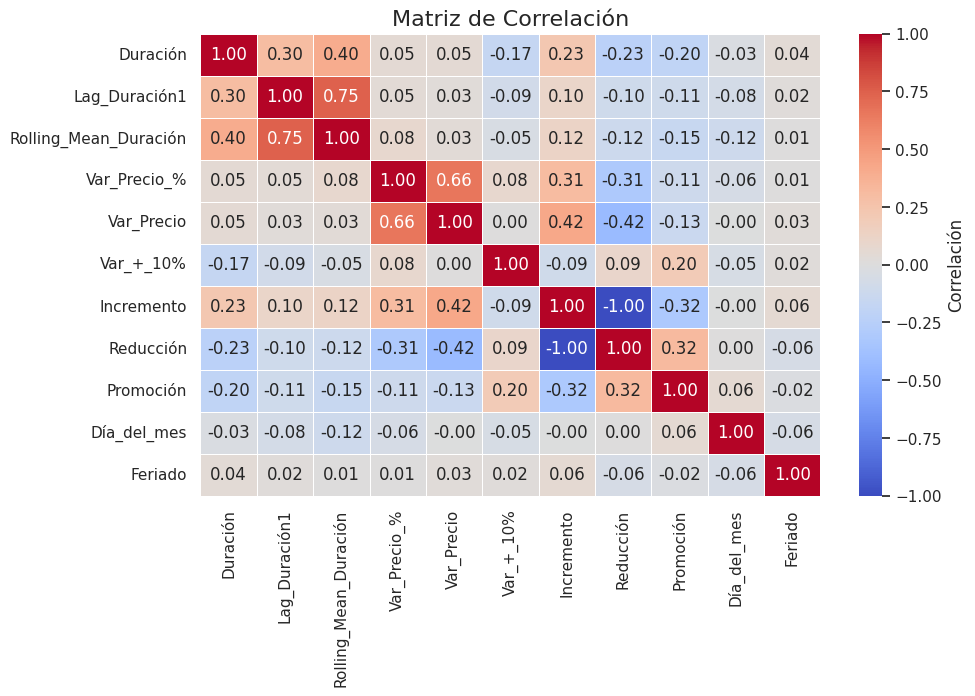

Variables significativas respecto a 'Duración' (p-value < 0.05):
['Lag_Duración1', 'Rolling_Mean_Duración', 'Var_Precio_%', 'Var_Precio', 'Var_+_10%', 'Incremento', 'Reducción', 'Promoción', 'Día_del_mes', 'Feriado']

Variables no significativas respecto a 'Duración' (p-value >= 0.05):
['Duración']


In [ ]:
# HEATMAP CON P VALUES

# Función para calcular la matriz de correlación y p-valores
def correlation_with_pvalues(df):
    # Número de variables
    n = df.shape[1]
    corr_matrix = df.corr()
    p_matrix = np.zeros((n, n))  # Matriz de p-valores

    # Calcula p-valores para cada par de variables
    for i in range(n):
        for j in range(i, n):
            _, p_value = stats.pearsonr(df.iloc[:, i], df.iloc[:, j])
            p_matrix[i, j] = p_matrix[j, i] = p_value

    return corr_matrix, p_matrix

# Seleccionamos solo las variables numéricas que deseas analizar
variables = df_price_spell_ML[['Duración', 'Lag_Duración1', 'Rolling_Mean_Duración', 'Var_Precio_%',
                                     'Var_Precio', 'Var_+_10%', 'Incremento', 'Reducción', 'Promoción',
                                     'Día_del_mes', 'Feriado']]

# Calculamos la matriz de correlación y p-valores
corr_matrix, p_matrix = correlation_with_pvalues(variables)

# Creamos un heatmap de correlaciones
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,
            cbar_kws={'label': 'Correlación'}, vmin=-1, vmax=1)

# Título del gráfico
plt.title("Matriz de Correlación", fontsize=16)

# Mostramos el gráfico
plt.show()

# Creamos una tabla de correlaciones y p-valores
correlation_results = pd.DataFrame(corr_matrix, columns=variables.columns, index=variables.columns)
p_value_results = pd.DataFrame(p_matrix, columns=variables.columns, index=variables.columns)

# Clasificamos variables en significativas y no significativas respecto a 'Duración'
significant_vars = []
non_significant_vars = []

# Iteramos sobre la fila de la variable 'Duración' (que está en la primera columna)
for var in variables.columns:
    p_value = p_value_results.loc['Duración', var]
    if p_value < 0.05 and var != 'Duración':  # Evita incluir la misma variable
        significant_vars.append(var)
    else:
        non_significant_vars.append(var)

# Imprime resultados
print("Variables significativas respecto a 'Duración' (p-value < 0.05):")
print(significant_vars)

print("\nVariables no significativas respecto a 'Duración' (p-value >= 0.05):")
print(non_significant_vars)


#### **3.6**  **Skewness y kurtosis**
Asimetría  - verificar si los datos están sesgados hacia la derecha o la izquierda.

Curtosis - si los datos tienen colas más largas o más cortas de lo esperado.

In [ ]:
# Calculamos asimetría y curtosis
skewness = skew(df_price_spell_ML['Duración'])
kurt = kurtosis(df_price_spell_ML['Duración'])

print(f"Asimetría (skewness) de la variable 'Duración': {skewness:.2f} - Positiva fuerte, mayoría de valores son bajos pero hay un pequeño número de valores mucho más altos.")
print(f"Curtosis de la variable 'Duración': {kurt:.2f} - Alta, distribución tiene un pico muy pronunciado y una gran cantidad de valores outliers.")


Asimetría (skewness) de la variable 'Duración': 3.63 - Positiva fuerte, mayoría de valores son bajos pero hay un pequeño número de valores mucho más altos.
Curtosis de la variable 'Duración': 22.72 - Alta, distribución tiene un pico muy pronunciado y una gran cantidad de valores outliers.


#### **3.7**  **Duración diaria - tabla y gráfico temporal**
Criterios para cálculo de Duración diaria media y mediana:
* Duración_media/mediana - considera spells activos del día en cuestión, es decir, aquellos con Fecha_inicio menor o igual al día de cálculo y Fecha_fin mayor o igual a dicho día. Para cada uno de los spells que cumplan dicha condición se calcula la Duración desde su Fecha_inicio hasta el día de cálculo.* Q_Spells - cantidad de spells considerados en el cálculo.

In [ ]:
# TABLA CON DURACIÓN DIARIA MEDIA Y MEDIANA GENERAL

# Rango de fechas a considerar
fecha_min = df_price_spell_ML["Fecha_inicio"].min()
fecha_max = df_price_spell_ML["Fecha_fin"].max()
rango_fechas = pd.date_range(start=fecha_min, end=fecha_max, freq="D")

# Lista para almacenar resultados
resultados = []

# Iteramos sobre cada fecha con barra de progreso
for fecha in tqdm(rango_fechas, desc="Calculando duración media por día"):
    # Filtramos spells activos en la fecha
    spells_activos = df_price_spell_ML[
        (df_price_spell_ML["Fecha_inicio"] <= fecha) &
        (df_price_spell_ML["Fecha_fin"] >= fecha)
    ]

    # Calculamos la duración de cada spell hasta la fecha actual
    spells_activos["Duración_actualizada"] = (fecha - spells_activos["Fecha_inicio"]).dt.days + 1

    # Calculamos duración media y mediana, y la cantidad de spells
    duracion_media = spells_activos["Duración_actualizada"].mean() if not spells_activos.empty else np.nan
    duracion_mediana = spells_activos["Duración_actualizada"].median() if not spells_activos.empty else np.nan
    q_spells = len(spells_activos)

     # Guardamos resultados
    resultados.append([fecha, q_spells, round(duracion_media, 2), round(duracion_mediana, 2)])

# Convertimos resultados en DataFrame
df_duracion_media = pd.DataFrame(resultados, columns=["Fecha", "Q_Spells", "Duración_media","Duración_mediana"])

# Mostramos los primeros registros
df_duracion_media.head()


Calculando duración media por día: 100%|██████████| 1275/1275 [00:17<00:00, 74.92it/s] 


Fecha  Q_Spells  Duración_media  Duración_mediana
0 2021-01-02       249            1.00               1.0
1 2021-01-03       342            1.65               2.0
2 2021-01-04       487            2.12               2.0
3 2021-01-05       743            2.33               2.0
4 2021-01-06      1051            2.56               2.0

In [ ]:
df_duracion_media.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Fecha             1275 non-null   datetime64[ns]
 1   Q_Spells          1275 non-null   int64         
 2   Duración_media    1275 non-null   float64       
 3   Duración_mediana  1275 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 40.0 KB


In [ ]:
## TABLA CON DURACIÓN DIARIA MEDIA GENERAL Y POR RUBROS ##

# Rango de fechas a considerar
fecha_min = df_price_spell_ML["Fecha_inicio"].min()
fecha_max = df_price_spell_ML["Fecha_fin"].max()
rango_fechas = pd.date_range(start=fecha_min, end=fecha_max, freq="D")

# Identificamos los rubros únicos
rubros_unicos = df_price_spell_ML["Rubro"].unique()

# Lista para almacenar resultados
resultados = []

# Iteramos sobre cada fecha con barra de progreso
for fecha in tqdm(rango_fechas, desc="Calculando duración media por día y rubro"):
    # Filtramos spells activos en la fecha
    spells_activos = df_price_spell_ML[
        (df_price_spell_ML["Fecha_inicio"] <= fecha) &
        (df_price_spell_ML["Fecha_fin"] >= fecha)
    ]

    # Calculamos la duración de cada spell hasta la fecha actual
    spells_activos["Duración_actualizada"] = (fecha - spells_activos["Fecha_inicio"]).dt.days + 1

    # Calculamos duración media y cantidad de spells a nivel general
    duracion_media = spells_activos["Duración_actualizada"].mean() if not spells_activos.empty else np.nan
    q_spells = len(spells_activos)

    # Diccionario para almacenar resultados de rubros
    rubro_data = {}

    for rubro in rubros_unicos:
        spells_rubro = spells_activos[spells_activos["Rubro"] == rubro]
        duracion_rubro = spells_rubro["Duración_actualizada"].mean() if not spells_rubro.empty else np.nan
        q_spells_rubro = len(spells_rubro)

        # Guardamos en el diccionario con nombres dinámicos
        rubro_data[f"Rubro_Duración_{rubro}"] = round(duracion_rubro, 2)
        rubro_data[f"Rubro_Spells_{rubro}"] = q_spells_rubro

    # Guardamos resultados
    resultados.append([fecha, round(duracion_media, 2), q_spells] + list(rubro_data.values()))

# Crear nombres de columnas
columnas = ["Fecha", "Duración_media", "Q_Spells"] + list(rubro_data.keys())

# Convertimos resultados en DataFrame
df_duracion_media_rubro = pd.DataFrame(resultados, columns=columnas)

# Mostramow los primeros registros
df_duracion_media_rubro.head()


Calculando duración media por día y rubro: 100%|██████████| 1275/1275 [00:54<00:00, 23.43it/s]


Fecha  Duración_media  Q_Spells  Rubro_Duración_Alimentos  \
0 2021-01-02            1.00       249                      1.00   
1 2021-01-03            1.65       342                      1.88   
2 2021-01-04            2.12       487                      2.05   
3 2021-01-05            2.33       743                      2.06   
4 2021-01-06            2.56      1051                      2.57   

   Rubro_Spells_Alimentos  Rubro_Duración_Bebidas sin Alcohol  \
0                     112                                1.00   
1                     124                                1.97   
2                     221                                2.92   
3                     413                                3.09   
4                     515                                3.88   

   Rubro_Spells_Bebidas sin Alcohol  Rubro_Duración_Bebidas con Alcohol  \
0                                38                                1.00   
1                                39                                2.00   
2                                40                                2.78   
3                                56                                3.78   
4                                56                                4.78   

   Rubro_Spells_Bebidas con Alcohol  Rubro_Duración_Cuidado Personal  \
0                                 8                             1.00   
1                                 8                             1.34   
2                                 9                             1.96   
3                                 9                             2.57   
4                                 9                             2.27   

   Rubro_Spells_Cuidado Personal  Rubro_Duración_Limpieza  \
0                             78                     1.00   
1                            156                     1.87   
2                            202                     2.80   
3                            235                     2.40   
4                            441                     3.40   

   Rubro_Spells_Limpieza  
0                     13  
1                     15  
2                     15  
3                     30  
4                     30

In [ ]:
df_duracion_media_rubro.tail()

Fecha  Duración_media  Q_Spells  Rubro_Duración_Alimentos  \
1270 2024-06-25           28.17       632                     14.71   
1271 2024-06-26           42.96       371                     24.67   
1272 2024-06-27           23.74       266                     25.08   
1273 2024-06-28           13.89       218                     13.32   
1274 2024-06-29           16.86        36                     49.50   

      Rubro_Spells_Alimentos  Rubro_Duración_Bebidas sin Alcohol  \
1270                     475                               90.65   
1271                     226                               89.63   
1272                     205                               12.58   
1273                     161                               12.50   
1274                       6                                4.07   

      Rubro_Spells_Bebidas sin Alcohol  Rubro_Duración_Bebidas con Alcohol  \
1270                               105                               19.00   
1271                               105                               20.00   
1272                                24                               21.00   
1273                                24                               13.22   
1274                                14                               28.67   

      Rubro_Spells_Bebidas con Alcohol  Rubro_Duración_Cuidado Personal  \
1270                                 9                            26.59   
1271                                 9                            25.07   
1272                                 9                            24.33   
1273                                 9                            18.15   
1274                                 3                            12.85   

      Rubro_Spells_Cuidado Personal  Rubro_Duración_Limpieza  \
1270                             39                     22.5   
1271                             27                     23.5   
1272                             24                     24.5   
1273                             20                     25.5   
1274                             13                      NaN   

      Rubro_Spells_Limpieza  
1270                      4  
1271                      4  
1272                      4  
1273                      4  
1274                      0

In [ ]:
df_duracion_media_rubro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 13 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Fecha                               1275 non-null   datetime64[ns]
 1   Duración_media                      1275 non-null   float64       
 2   Q_Spells                            1275 non-null   int64         
 3   Rubro_Duración_Alimentos            1275 non-null   float64       
 4   Rubro_Spells_Alimentos              1275 non-null   int64         
 5   Rubro_Duración_Bebidas sin Alcohol  1275 non-null   float64       
 6   Rubro_Spells_Bebidas sin Alcohol    1275 non-null   int64         
 7   Rubro_Duración_Bebidas con Alcohol  1275 non-null   float64       
 8   Rubro_Spells_Bebidas con Alcohol    1275 non-null   int64         
 9   Rubro_Duración_Cuidado Personal     1275 non-null   float64       
 10  Rubro_Spells_Cuidado Per

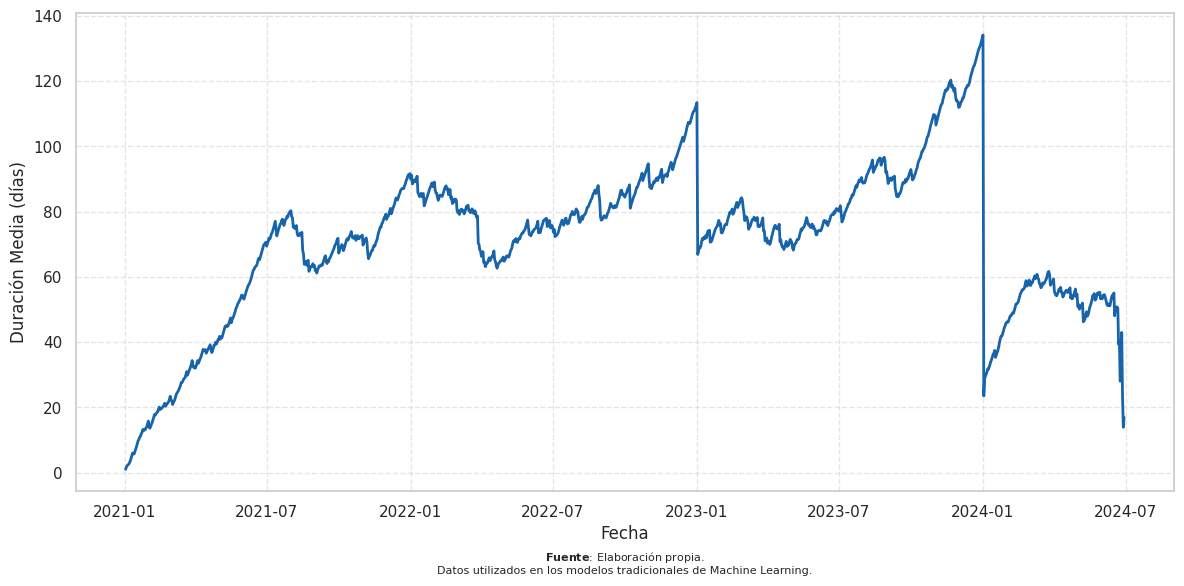

/content/Serie Duracion Diaria (general).png

In [ ]:
# VISUALIZACIÓN DE DURACIÓN MEDIA CONJUNTA

# Configuramos el tamaño del gráfico
plt.figure(figsize=(12, 6))

# Graficamos solo la duración media general en negro
plt.plot(
    df_duracion_media_rubro["Fecha"],
    df_duracion_media_rubro["Duración_media"],
    linewidth=2,
    color=header_color
)

# Etiquetas de ejes (sin título general)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Duración Media (días)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5) #Otros valores posibles: "-" (línea sólida), ":" (punteada), "-." (línea-punto).

# Negrita solo en "Fuente:" usando formato LaTeX
plt.text(0.5, -0.15,
         r'$\bf{Fuente}$: Elaboración propia.' + '\nDatos utilizados en los modelos tradicionales de Machine Learning.',
         ha='center', va='center', transform=plt.gca().transAxes, fontsize=8)

# Mostramos el gráfico
plt.tight_layout()

# Guardamos la imagen localmente en el directorio actual
filename = "Serie Duracion Diaria (general).png"
plt.savefig(filename, dpi=300, bbox_inches='tight')

# Mostramos
plt.show()

# Creamos un enlace de descarga (queda guardado en entorno)
display(FileLink(filename))


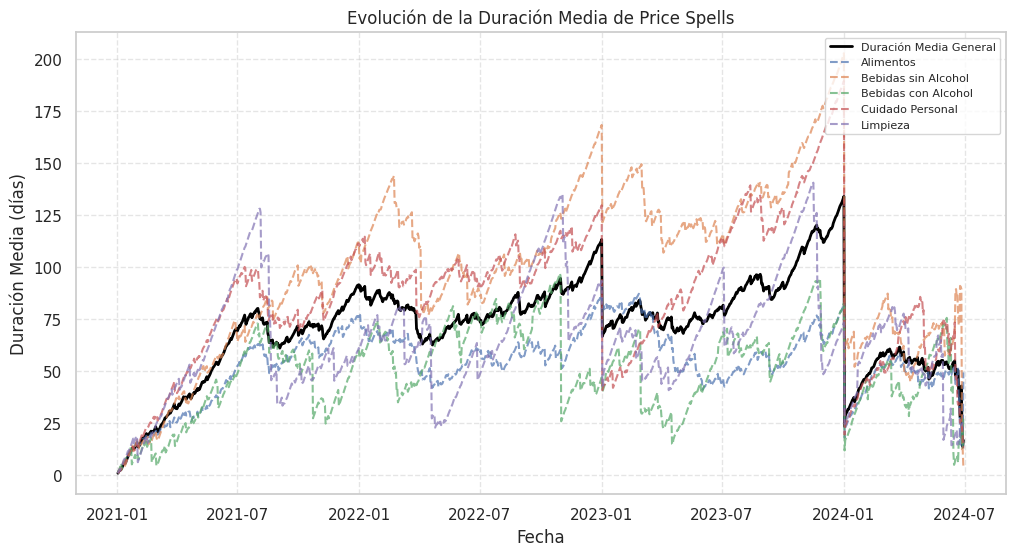

In [ ]:
# VISUALIZACIÓN DE DURACIÓN MEDIA CONJUNTA

# Configuramos el tamaño del gráfico
plt.figure(figsize=(12, 6))

# Graficamos la duración media general
plt.plot(df_duracion_media_rubro["Fecha"], df_duracion_media_rubro["Duración_media"], label="Duración Media General", linewidth=2, color="black")

# Graficamos la duración media por Rubro
for columna in df_duracion_media_rubro.columns:
    if "Rubro_Duración_" in columna:  # Filtramos solo las columnas de duración por rubro
        plt.plot(df_duracion_media_rubro["Fecha"], df_duracion_media_rubro[columna], label=columna.replace("Rubro_Duración_", ""), linestyle="--", alpha=0.7)

# Configuramos títulos y etiquetas
plt.title("Evolución de la Duración Media de Price Spells")
plt.xlabel("Fecha")
plt.ylabel("Duración Media (días)")
plt.legend(loc="upper right", fontsize=8)
plt.grid(True, linestyle="--", alpha=0.5)

# Mostramos el gráfico
plt.show()


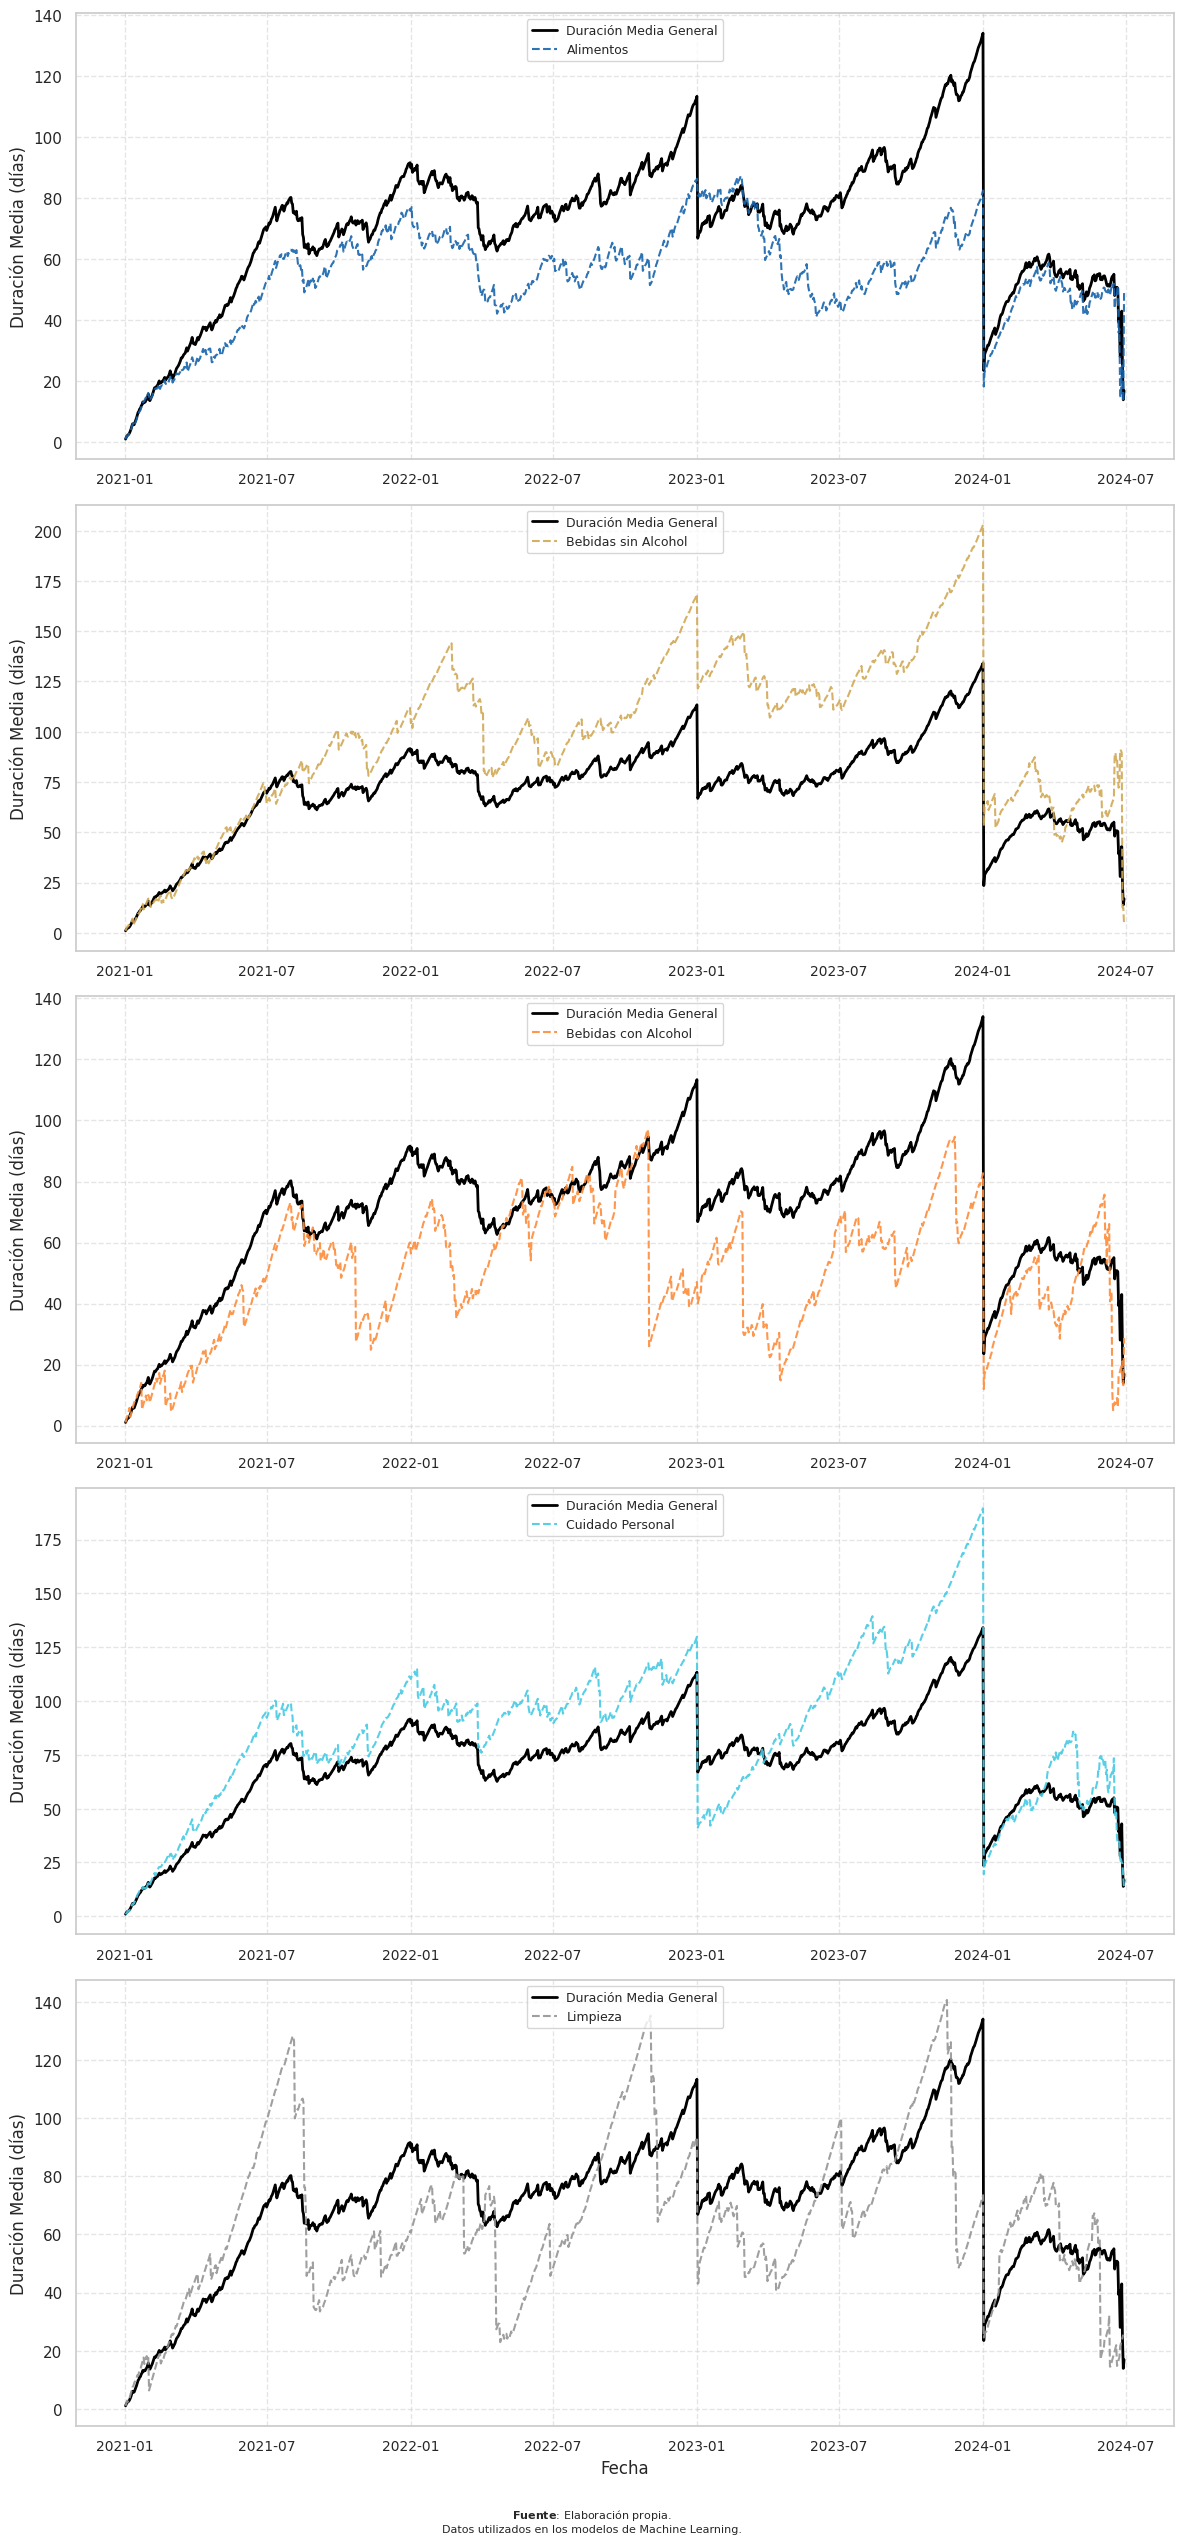

/content/Serie Duracion Diaria (Rubros).png

In [ ]:
## VISUALIZACIÓN DE DURACIÓN MEDIA POR RUBRO ##

# Filtramos las columnas de duración por Rubro
columnas_rubro = [col for col in df_duracion_media_rubro.columns if "Rubro_Duración_" in col]

# Configuramos el tamaño del gráfico y cantidad de subgráficos (ancho y altura)
num_rubros = len(columnas_rubro)
fig, axes = plt.subplots(nrows=num_rubros, ncols=1, figsize=(12, 5 * num_rubros), sharex=False)
plt.subplots_adjust(hspace=0.9)

# Si hay solo un rubro, convertir `axes` en una lista
if num_rubros == 1:
    axes = [axes]

# Iteramos sobre cada Rubro y generar su gráfico
for ax, columna in zip(axes, columnas_rubro):
    rubro = columna.replace("Rubro_Duración_", "")
    color = color_dict.get(rubro, "gray")  # Usar color del diccionario o gris por defecto

    # Graficamos la duración media general en negro
    ax.plot(df_duracion_media_rubro["Fecha"], df_duracion_media_rubro["Duración_media"],
            label="Duración Media General", linewidth=2, color="black")

    # Graficamos la duración media del rubro específico
    ax.plot(df_duracion_media_rubro["Fecha"], df_duracion_media_rubro[columna],
            label=rubro, linestyle="--", alpha=0.9, color=color)

    # Eliminamos título, mantener solo etiquetas de eje Y y leyenda
    ax.set_ylabel("Duración Media (días)")
    ax.legend(loc="upper center", fontsize=9)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.tick_params(axis='x', labelsize=10)

# Configuramos eje X en el último gráfico
axes[-1].set_xlabel("Fecha")

# Ajustamos diseño general
plt.tight_layout()

# Agregamos leyenda/disclaimer centrada debajo del último gráfico
fig.text(0.5, -0.005,
         r'$\bf{Fuente}$: Elaboración propia.' + '\nDatos utilizados en los modelos de Machine Learning.',
         ha='center', va='top', fontsize=8)

# Guardamos la imagen localmente en el directorio actual
filename = "Serie Duracion Diaria (Rubros).png"
plt.savefig(filename, dpi=300, bbox_inches='tight')

# Mostramos
plt.show()

# Creamos un enlace de descarga (queda guardado en entorno)
display(FileLink(filename))


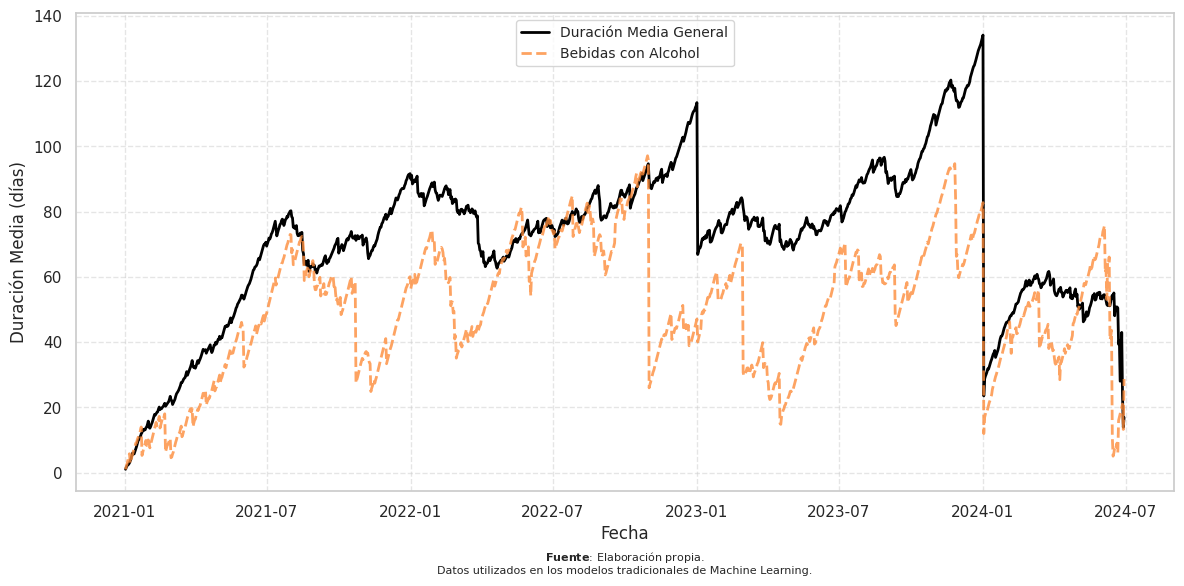

/content/Serie Duracion Diaria (Bebidas con Alcohol).png

In [ ]:
## GENERAMOS IMAGENES PARA TESIS ##

# Definimos el Rubro a graficar (debe coincidir con el formato en las columnas del DataFrame)
rubro_objetivo = "Bebidas con Alcohol"  # Cambiar por el rubro deseado

# Construimos el nombre de la columna específica para el rubro
columna_rubro = f"Rubro_Duración_{rubro_objetivo}"

# Verificamos que el rubro esté en el DataFrame
if columna_rubro not in df_duracion_media_rubro.columns:
    raise ValueError(f"No se encontró la columna para el rubro '{rubro_objetivo}'.")

# Obtenemos color desde el diccionario o gris si no está definido
color = color_dict.get(rubro_objetivo, "gray")

# Creamos figura
plt.figure(figsize=(12, 6))

# Graficamos la duración media general
plt.plot(df_duracion_media_rubro["Fecha"], df_duracion_media_rubro["Duración_media"],
         label="Duración Media General", linewidth=2, color="black")

# Graficamos la duración media del rubro específico
plt.plot(df_duracion_media_rubro["Fecha"], df_duracion_media_rubro[columna_rubro],
         label=rubro_objetivo, linestyle="--", linewidth=2, alpha=0.8, color=color)

# Etiquetas y leyenda
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Duración Media (días)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper center", fontsize=10)

# Agregamos leyenda/disclaimer centrado debajo del gráfico
plt.text(0.5, -0.15,
         r'$\bf{Fuente}$: Elaboración propia.' + '\nDatos utilizados en los modelos tradicionales de Machine Learning.',
         ha='center', va='center', transform=plt.gca().transAxes, fontsize=8)

# Ajuste de layout
plt.tight_layout()

# Guardamos la imagen localmente en el directorio actual
filename = f"Serie Duracion Diaria ({rubro_objetivo}).png"
plt.savefig(filename, dpi=300, bbox_inches='tight')

# Mostramos
plt.show()

# Creamos un enlace de descarga (queda guardado en entorno)
display(FileLink(filename))
